In [7]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from memory_profiler import memory_usage
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [8]:
class GrammaticalEvolution:
    def __init__(self, grammar, max_depth, crossover_rate):
        self.grammar = grammar
        self.max_depth = max_depth
        self.crossover_rate = crossover_rate
    
    def generate_individual(self):
        return 'DecisionTreeClassifier(max_depth={})'.format(np.random.choice(self.grammar['<depth>']))
    
    def evaluate_individual(self, individual, X_train, y_train, X_test, y_test):
        model = eval(individual)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='macro', zero_division=0)
        recall = recall_score(y_test, predictions, average='macro', zero_division=0)
        f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
        confusion = confusion_matrix(y_test, predictions)
        report = classification_report(y_test, predictions, zero_division=0)
        return accuracy, precision, recall, f1, confusion, report

In [9]:
def initialize_population_ge(population_size, ge):
    return [ge.generate_individual() for _ in range(population_size)]

def tournament_selection(population, fitness_scores, tournament_size):
    selected = []
    for _ in range(tournament_size):
        i = np.random.randint(0, len(population))
        selected.append((population[i], fitness_scores[i]))
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    if np.random.rand() < 0.5:
        return parent1
    else:
        return parent2

def mutate(individual, grammar):
    if np.random.rand() < 0.1:
        return 'DecisionTreeClassifier(max_depth={})'.format(np.random.choice(grammar['<depth>']))
    else:
        return individual

In [10]:
def generate_new_generation_ge(population, fitness_scores, tournament_size, mutation_rate, crossover_rate, ge, generation):
    new_population = []
    total_computational_cost = 0
    for i, individual in enumerate(population):
        parent1 = tournament_selection(population, fitness_scores, tournament_size)
        parent2 = tournament_selection(population, fitness_scores, tournament_size)
        child = crossover(parent1, parent2)
        if np.random.rand() < mutation_rate:
            child = mutate(child, ge.grammar)
        new_population.append(child)
        
        # Calculate computational cost
        computational_cost = fitness_scores[i] * len(population) * generation
        total_computational_cost += computational_cost
        
    return new_population, total_computational_cost

In [11]:
def read_source_data(file_path):
    OpenFile = pd.read_csv(file_path)
    X = OpenFile.iloc[:, :-1].values
    y = OpenFile.iloc[:, -1].values
    return X, y

def read_target_data1(file_path):
    OpenFile = pd.read_csv(file_path)
    
    # Create binary columns for each category
    label_encoder = LabelEncoder()
    label_encoder2 = LabelEncoder()
    OpenFile['gender'] = label_encoder.fit_transform(OpenFile['gender'])
    OpenFile['smoking_history'] = label_encoder2.fit_transform(OpenFile['smoking_history'])
    
    X = OpenFile.iloc[:, :-1].values
    y = OpenFile.iloc[:, -1].values
    
    return X, y

def read_target_data2(file_path):
    OpenFile = pd.read_csv(file_path)
    
    # Dealing with Gender
    gender_dummies = pd.get_dummies(OpenFile['Gender'])
    gender_dummies = gender_dummies.astype(int)

    OpenFile = pd.concat([gender_dummies, OpenFile], axis=1)

    label_encoder = LabelEncoder()
    OpenFile['Gender'] = label_encoder.fit_transform(OpenFile['Gender'])

    OpenFile.drop(columns=['Gender'], inplace=True)
    
    # Dealing with Class
    label_encoder = LabelEncoder()
    OpenFile['CLASS'] = label_encoder.fit_transform(OpenFile['CLASS'])
    
    X = OpenFile.iloc[:, :-1].values
    y = OpenFile.iloc[:, -1].values
    
    return X, y

In [12]:
def grammatical_evolution_without_transfer_learning(target_X_train, target_y_train, target_X_test, target_y_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations):
    ge = GrammaticalEvolution(grammar, max_depth, crossover_rate)
    population = initialize_population_ge(population_size, ge)
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'runtime': [],
        'memory': [],
        'confusion_matrix': [],
        'computational_cost': []
    }
    
    total_runtime = 0
    total_memory = 0
    total_computational_cost = 0
    
    for generation in range(generations):
        start_time = time.time()
        
        fitness_scores = []
        for individual in population:
            accuracy, precision, recall, f1, confusion, _ = ge.evaluate_individual(individual, target_X_train, target_y_train, target_X_test, target_y_test)
            fitness_scores.append(accuracy)
        
        best_individual_index = np.argmax(fitness_scores)
        best_individual = population[best_individual_index]
        accuracy, precision, recall, f1, confusion, report = ge.evaluate_individual(best_individual, target_X_train, target_y_train, target_X_test, target_y_test)
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['confusion_matrix'].append(confusion)
        
        print(f"Generation {generation}:")
        print(report)
        
        population, total_computational_cost = generate_new_generation_ge(population, fitness_scores, tournament_size, mutation_rate, crossover_rate, ge, generation)
        
        end_time = time.time()
        runtime = end_time - start_time
        mem_usage = max(memory_usage())
        
        total_runtime += runtime
        total_memory += mem_usage
        
        metrics['runtime'].append(runtime)
        metrics['memory'].append(mem_usage)
        metrics['computational_cost'].append(total_computational_cost)
    
    overall_accuracy = np.mean(metrics['accuracy'])
    overall_precision = np.mean(metrics['precision'])
    
    print("\nOverall Metrics Without Transfer Learning:")
    print(f"Overall Accuracy: {overall_accuracy}")
    print(f"Overall Precision: {overall_precision}")
    print(f"Total Runtime: {total_runtime} seconds")
    print(f"Total Memory Usage: {total_memory} MB")
    print(f"Total Computational Cost: {total_computational_cost}")
    
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(range(generations), metrics['accuracy'], label='Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Generations')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(range(generations), metrics['precision'], label='Precision')
    plt.xlabel('Generation')
    plt.ylabel('Precision')
    plt.title('Precision over Generations')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(range(generations), metrics['recall'], label='Recall')
    plt.xlabel('Generation')
    plt.ylabel('Recall')
    plt.title('Recall over Generations')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(range(generations), metrics['runtime'], label='Runtime')
    plt.xlabel('Generation')
    plt.ylabel('Runtime')
    plt.title('Runtime over Generations')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return best_individual, metrics, total_runtime, total_memory, total_computational_cost


In [13]:
def grammatical_evolution_with_transfer_learning(source_X, source_y, target_X_train, target_y_train, target_X_test, target_y_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations):
    ge = GrammaticalEvolution(grammar, max_depth, crossover_rate)
    source_tree = DecisionTreeClassifier(max_depth=max_depth)
    source_tree.fit(source_X, source_y)
    
    source_individual = 'DecisionTreeClassifier(max_depth={})'.format(max_depth)
    
    population = [source_individual] + initialize_population_ge(population_size - 1, ge)
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'runtime': [],
        'memory': [],
        'confusion_matrix': [],
        'computational_cost': []
    }
    
    total_runtime = 0
    total_memory = 0
    total_computational_cost = 0
    
    for generation in range(generations):
        start_time = time.time()
        
        fitness_scores = []
        for individual in population:
            accuracy, precision, recall, f1, confusion, _ = ge.evaluate_individual(individual, target_X_train, target_y_train, target_X_test, target_y_test)
            fitness_scores.append(accuracy)
        
        best_individual_index = np.argmax(fitness_scores)
        best_individual = population[best_individual_index]
        accuracy, precision, recall, f1, confusion, report = ge.evaluate_individual(best_individual, target_X_train, target_y_train, target_X_test, target_y_test)
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['confusion_matrix'].append(confusion)
        
        print(f"Generation {generation}:")
        print(report)
        
        population, total_computational_cost = generate_new_generation_ge(population, fitness_scores, tournament_size, mutation_rate, crossover_rate, ge, generation)
        
        end_time = time.time()
        runtime = end_time - start_time
        mem_usage = max(memory_usage())
        
        total_runtime += runtime
        total_memory += mem_usage
        
        metrics['runtime'].append(runtime)
        metrics['memory'].append(mem_usage)
        metrics['computational_cost'].append(total_computational_cost)
    
    overall_accuracy = np.mean(metrics['accuracy'])
    overall_precision = np.mean(metrics['precision'])
    
    print("\nOverall Metrics With Transfer Learning:")
    print(f"Overall Accuracy: {overall_accuracy}")
    print(f"Overall Precision: {overall_precision}")
    print(f"Total Runtime: {total_runtime} seconds")
    print(f"Total Memory Usage: {total_memory} MB")
    print(f"Total Computational Cost: {total_computational_cost}")
    
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(range(generations), metrics['accuracy'], label='Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Generations')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(range(generations), metrics['precision'], label='Precision')
    plt.xlabel('Generation')
    plt.ylabel('Precision')
    plt.title('Precision over Generations')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(range(generations), metrics['recall'], label='Recall')
    plt.xlabel('Generation')
    plt.ylabel('Recall')
    plt.title('Recall over Generations')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(range(generations), metrics['runtime'], label='Runtime')
    plt.xlabel('Generation')
    plt.ylabel('Runtime')
    plt.title('Runtime over Generations')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return best_individual, metrics, total_runtime, total_memory, total_computational_cost



Iteration 1:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg      

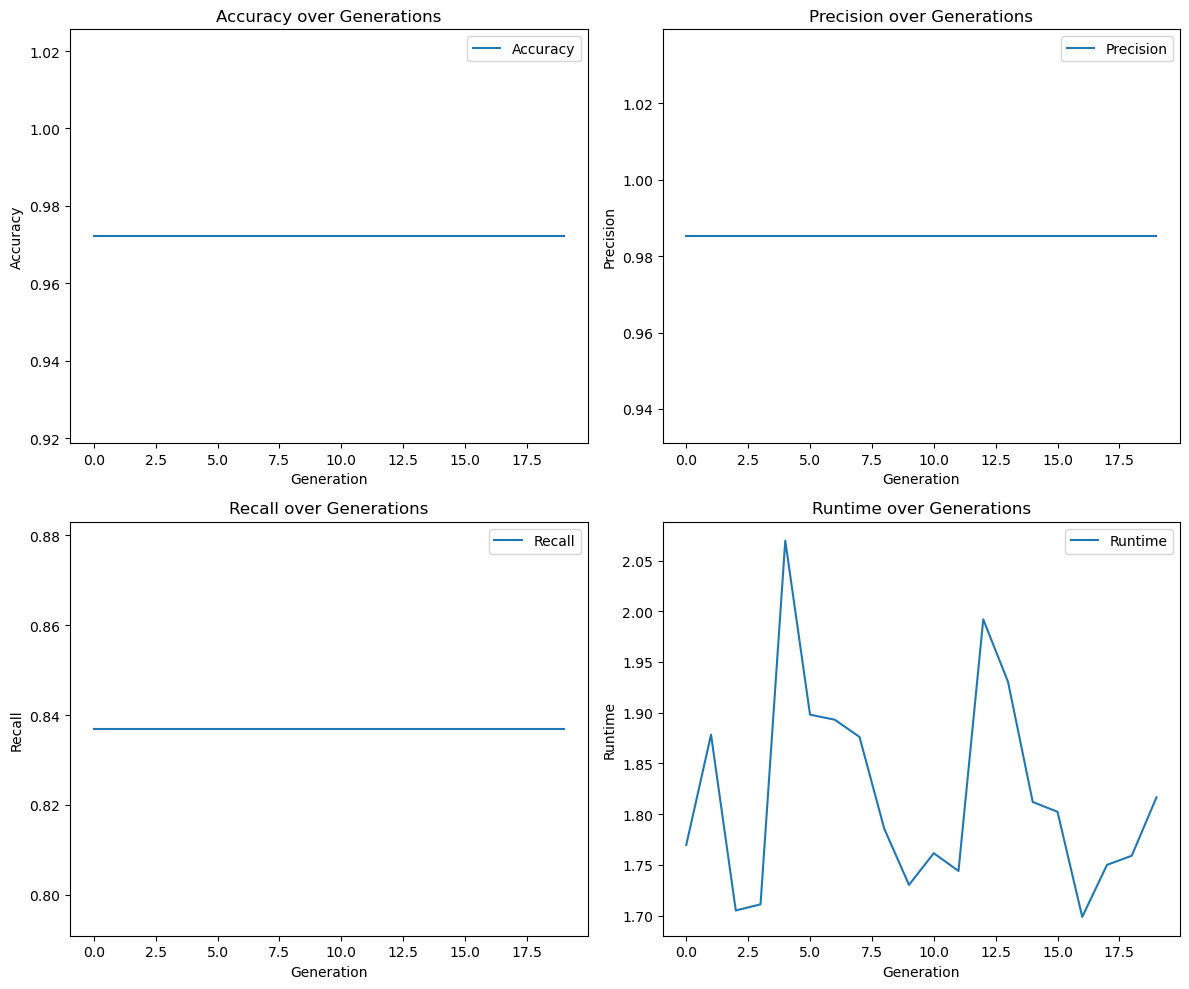

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

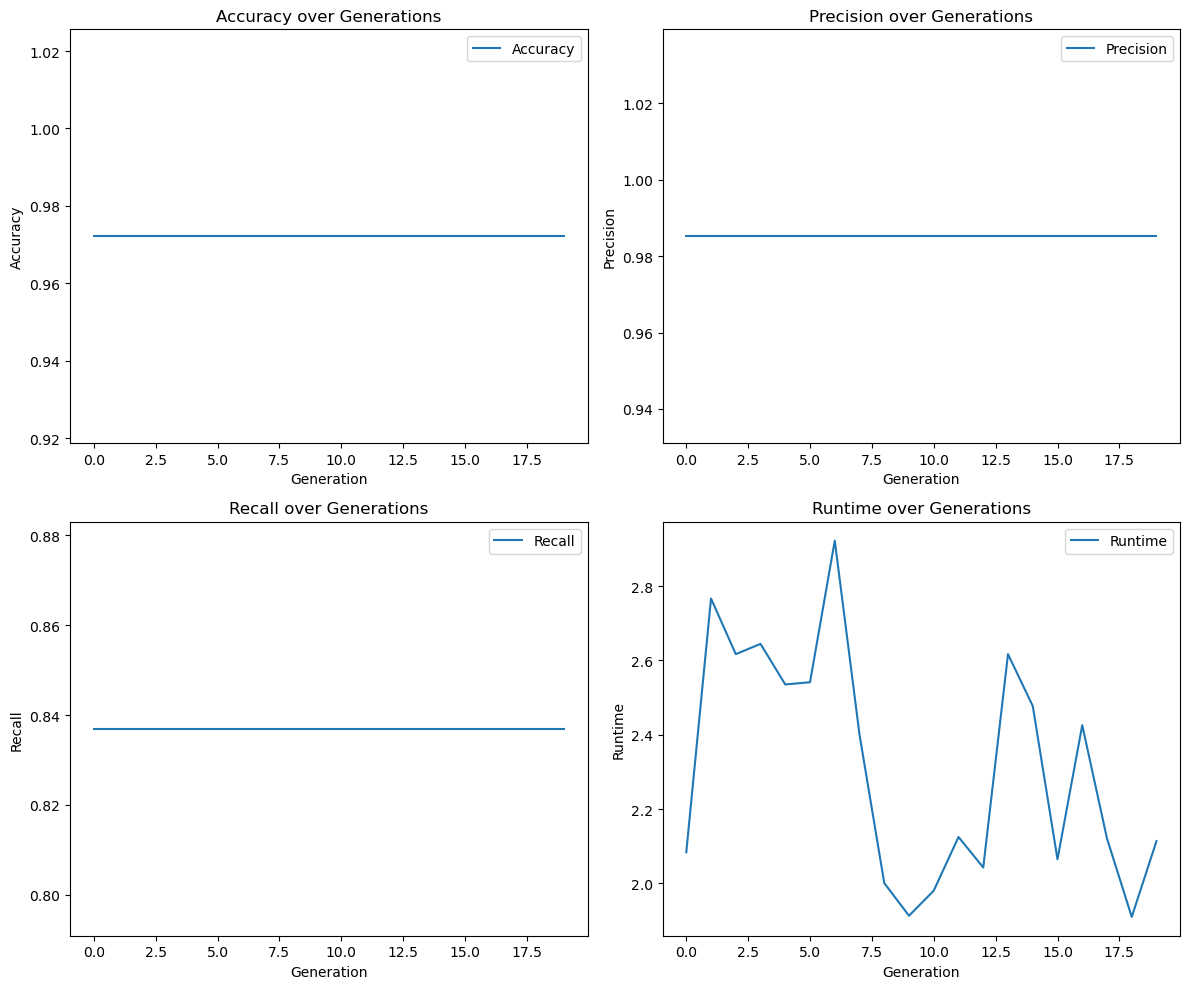

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9745000000000001
Overall Precision: 0.7151164803786726
Total Runtime: 6.900663375854492 seconds
Total Memory Usage: 1791.64453125 MB
Total Computational Cost: 11540.125


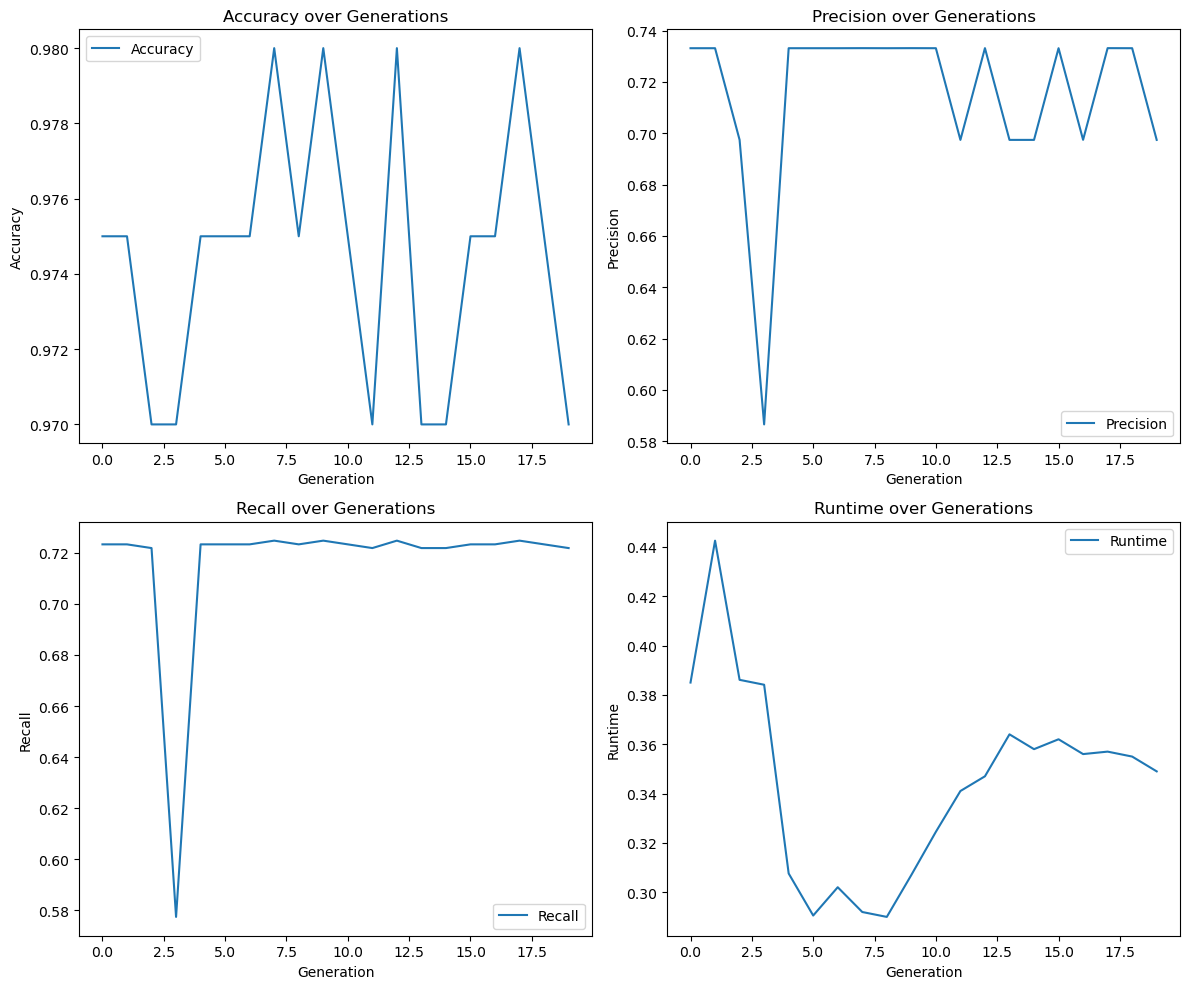

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.974
Overall Precision: 0.69169141369045

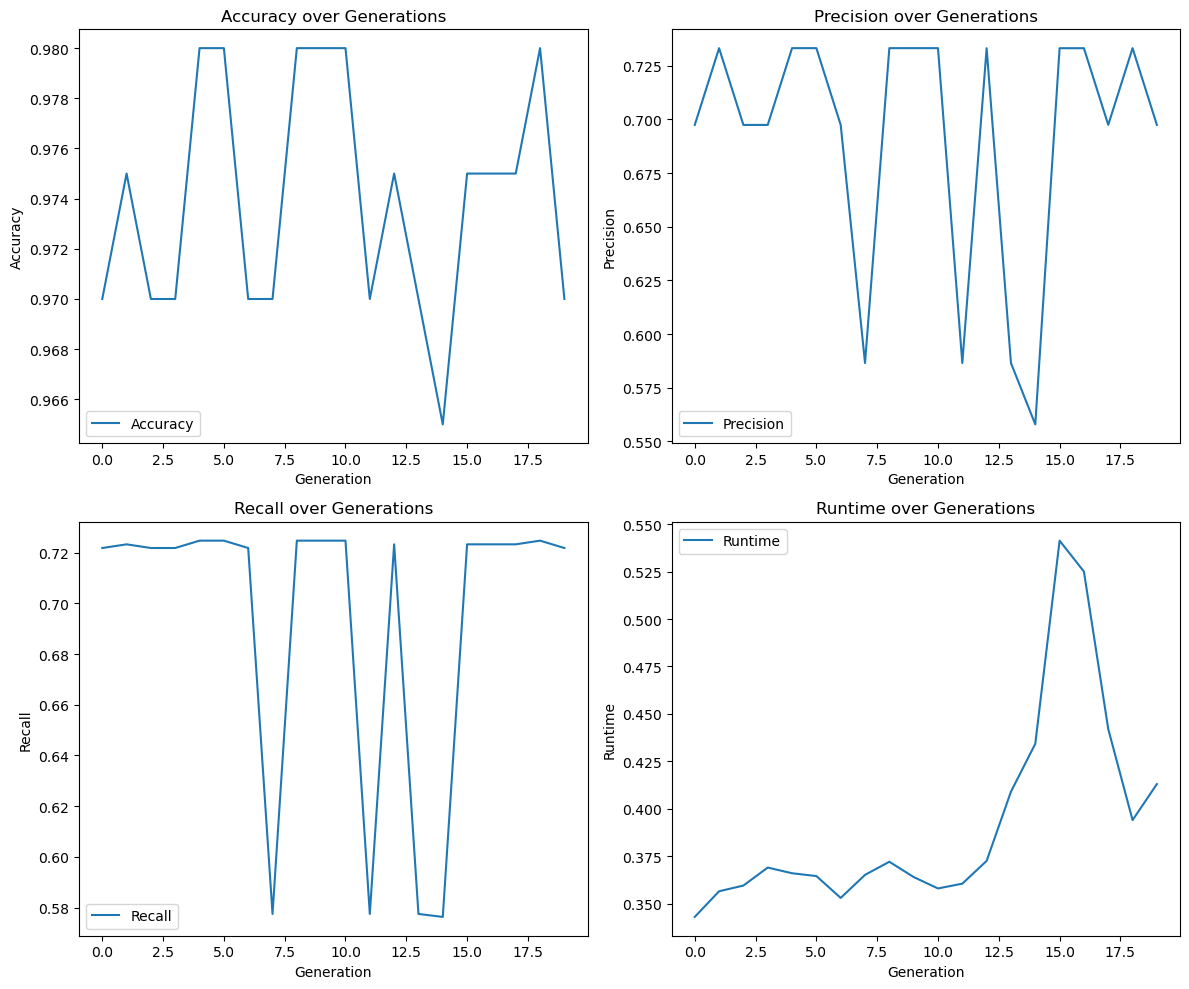


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 21.64225423336029 seconds
Average Memory Usage: 1537.935546875 MB
Average Computational Cost: 11542.203124999998
Average Accuracy: 0.973325

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 27.084322571754456 seconds
Average Memory Usage: 1788.16015625 MB
Average Computational Cost: 11555.265624999998
Average Accuracy: 0.9730749999999999

Iteration 2:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                      

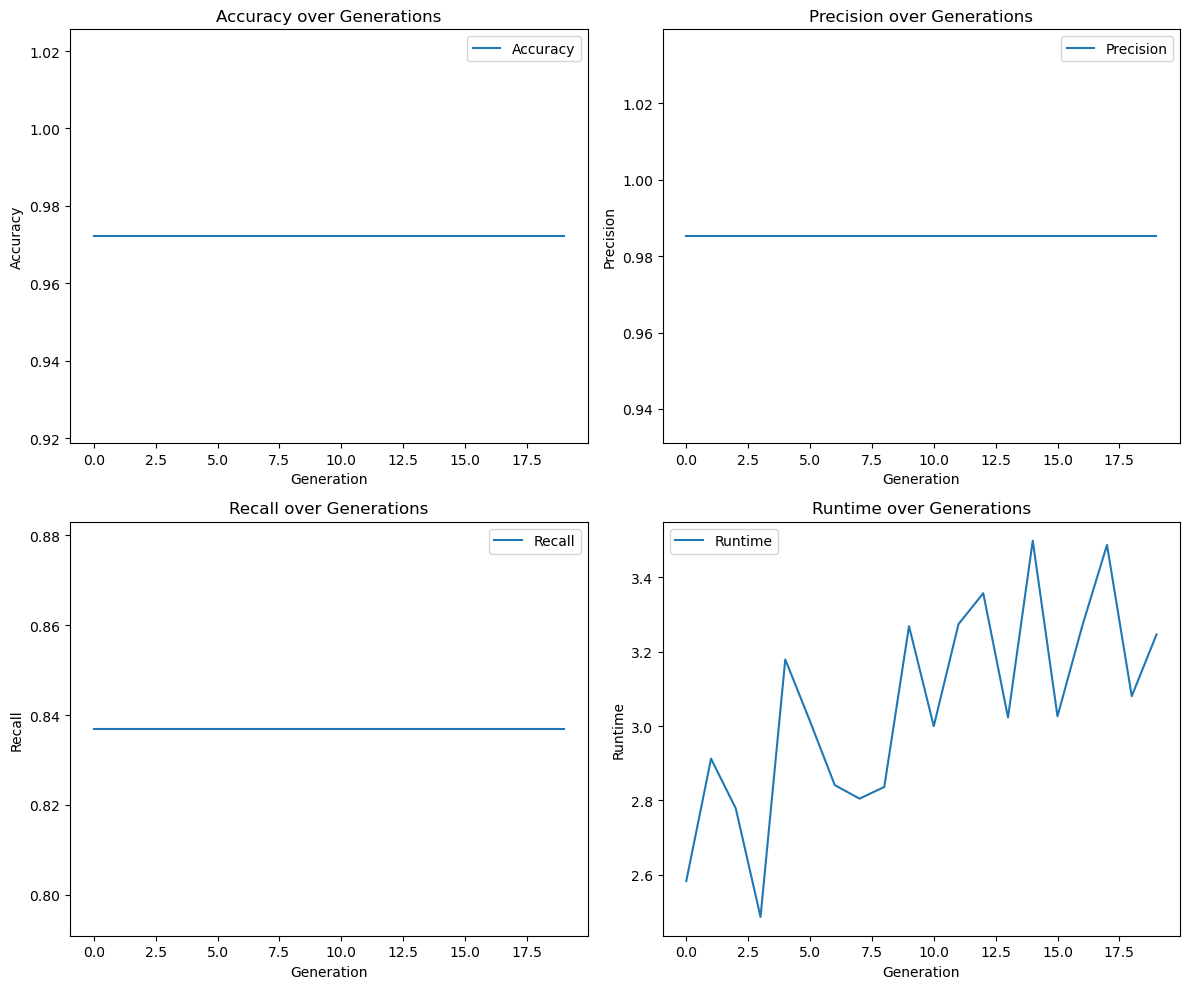

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

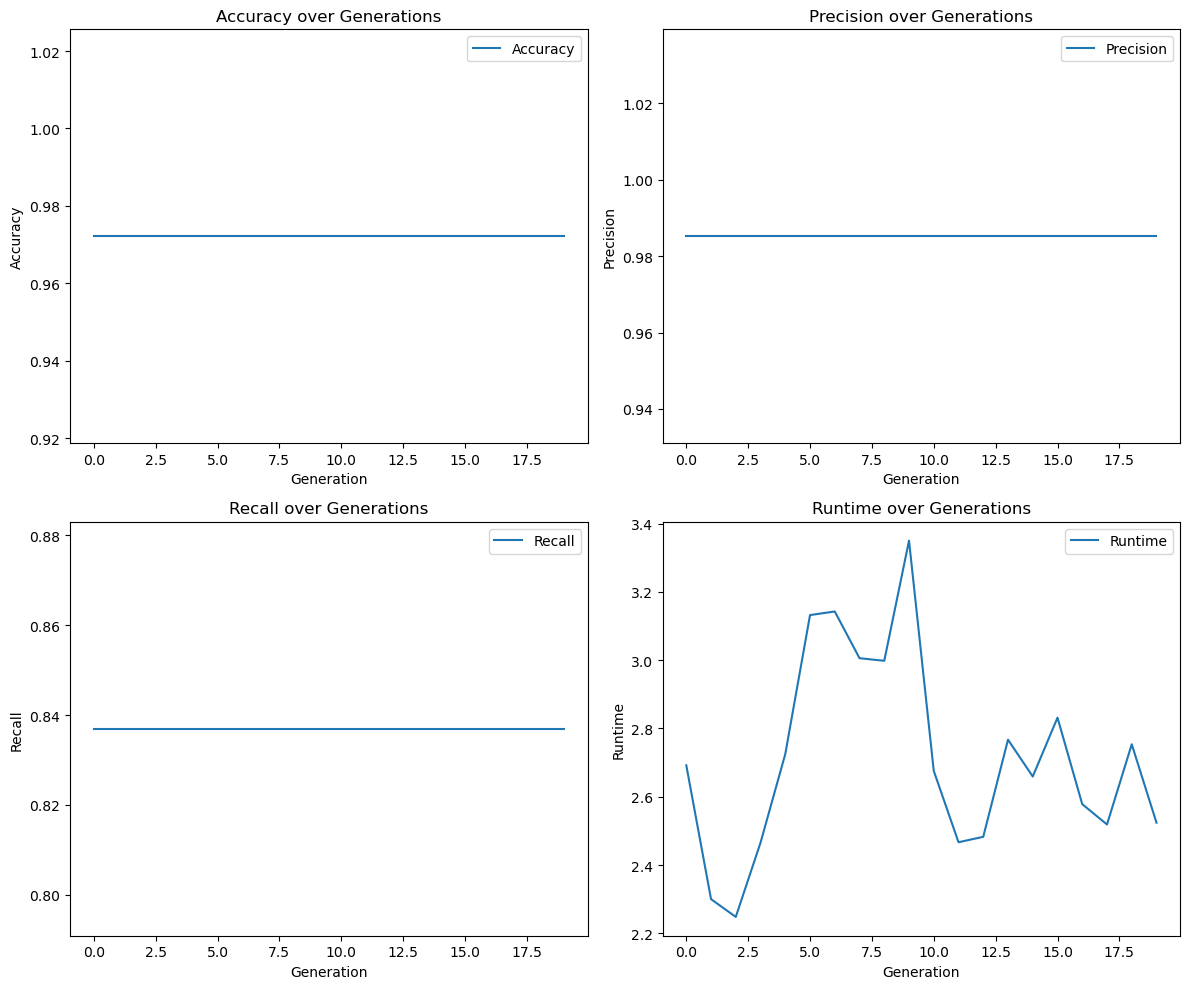

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall 

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9754999999999999
Overall Precision: 

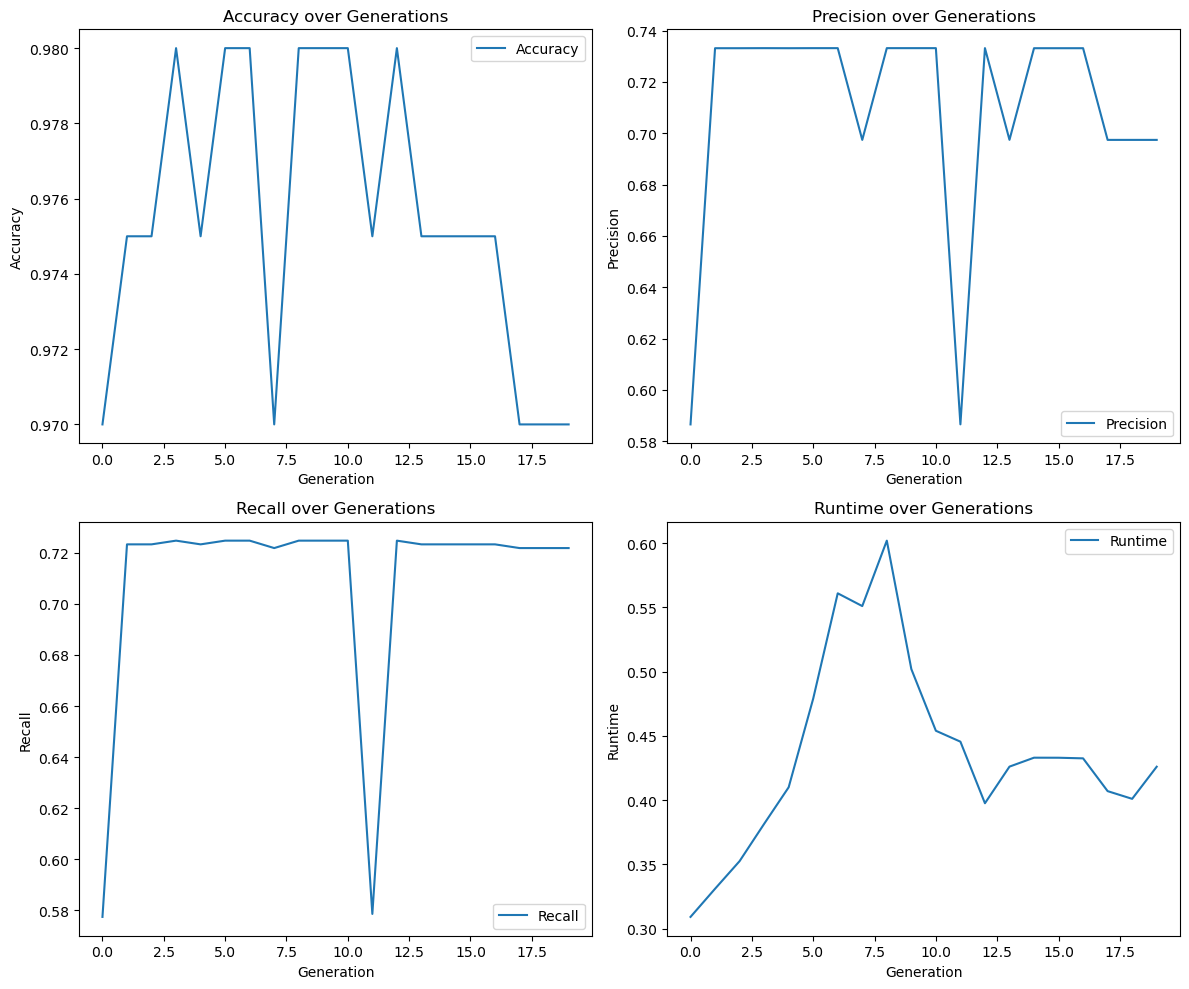

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9752500000000002
Overall Precision: 0.7

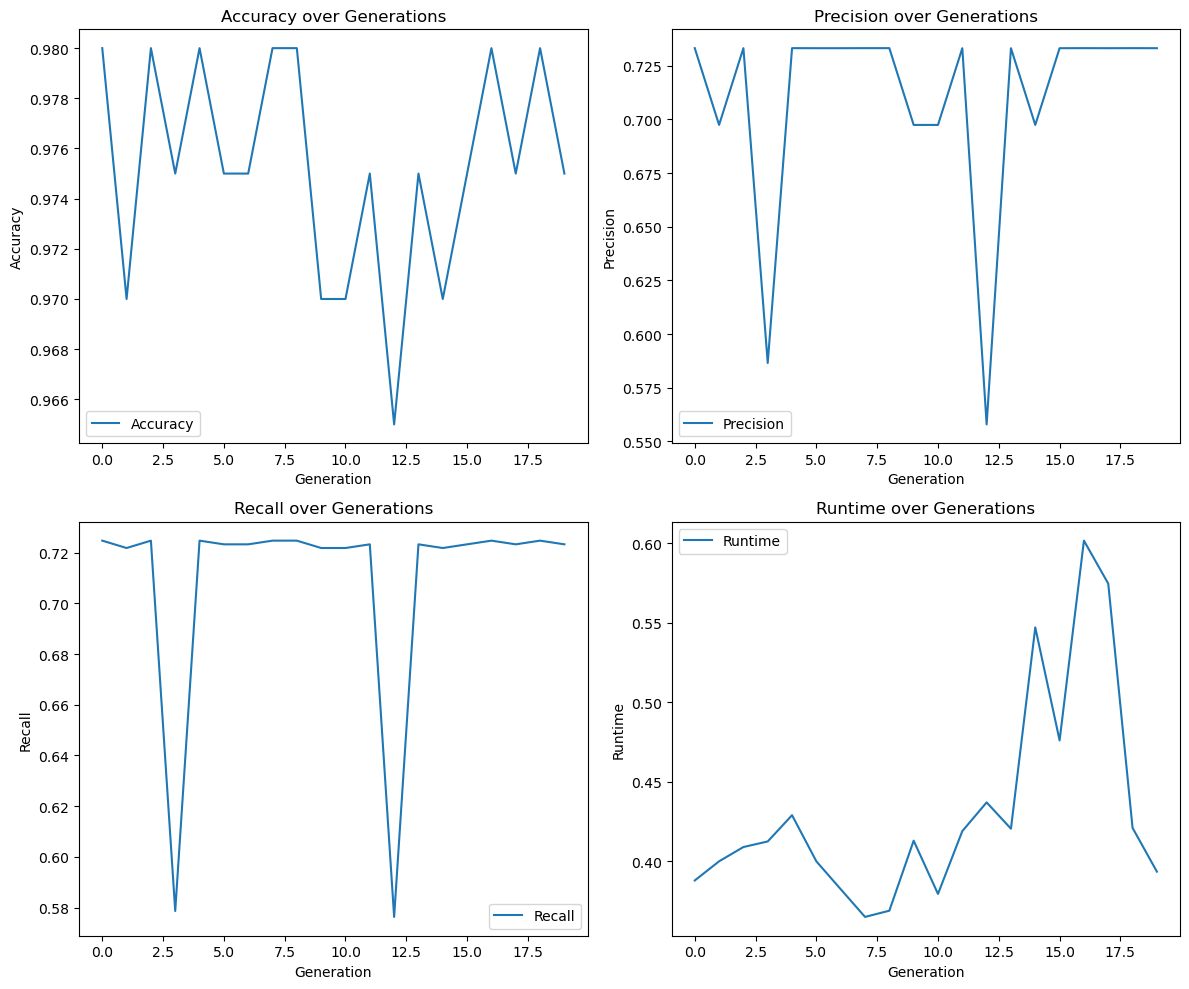


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 28.2454833984375 seconds
Average Memory Usage: 2646.76171875 MB
Average Computational Cost: 11550.515624999998
Average Accuracy: 0.973575

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 29.28075760602951 seconds
Average Memory Usage: 2819.3916015625 MB
Average Computational Cost: 11553.484374999998
Average Accuracy: 0.9733874999999999

Iteration 3:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                       

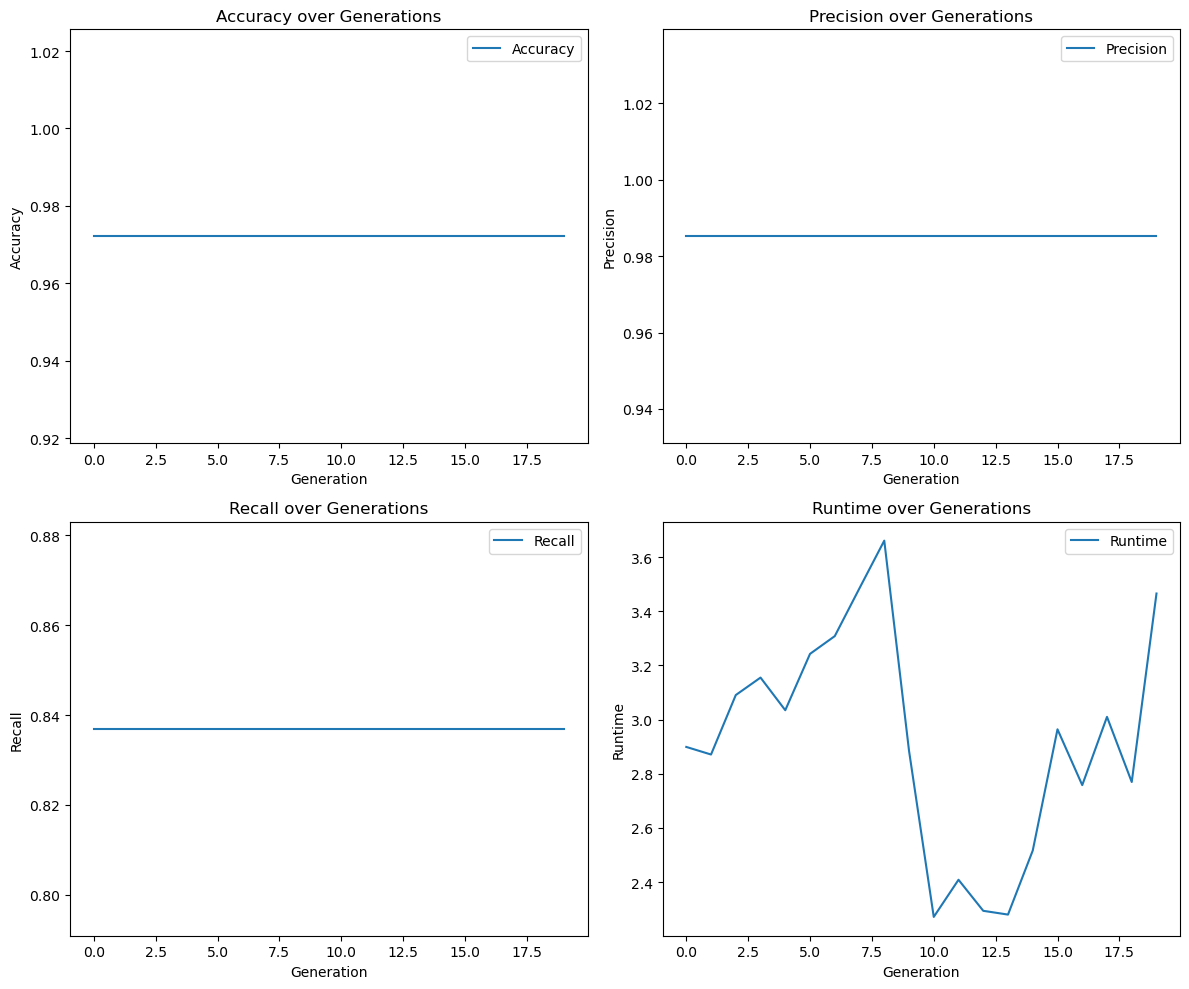

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

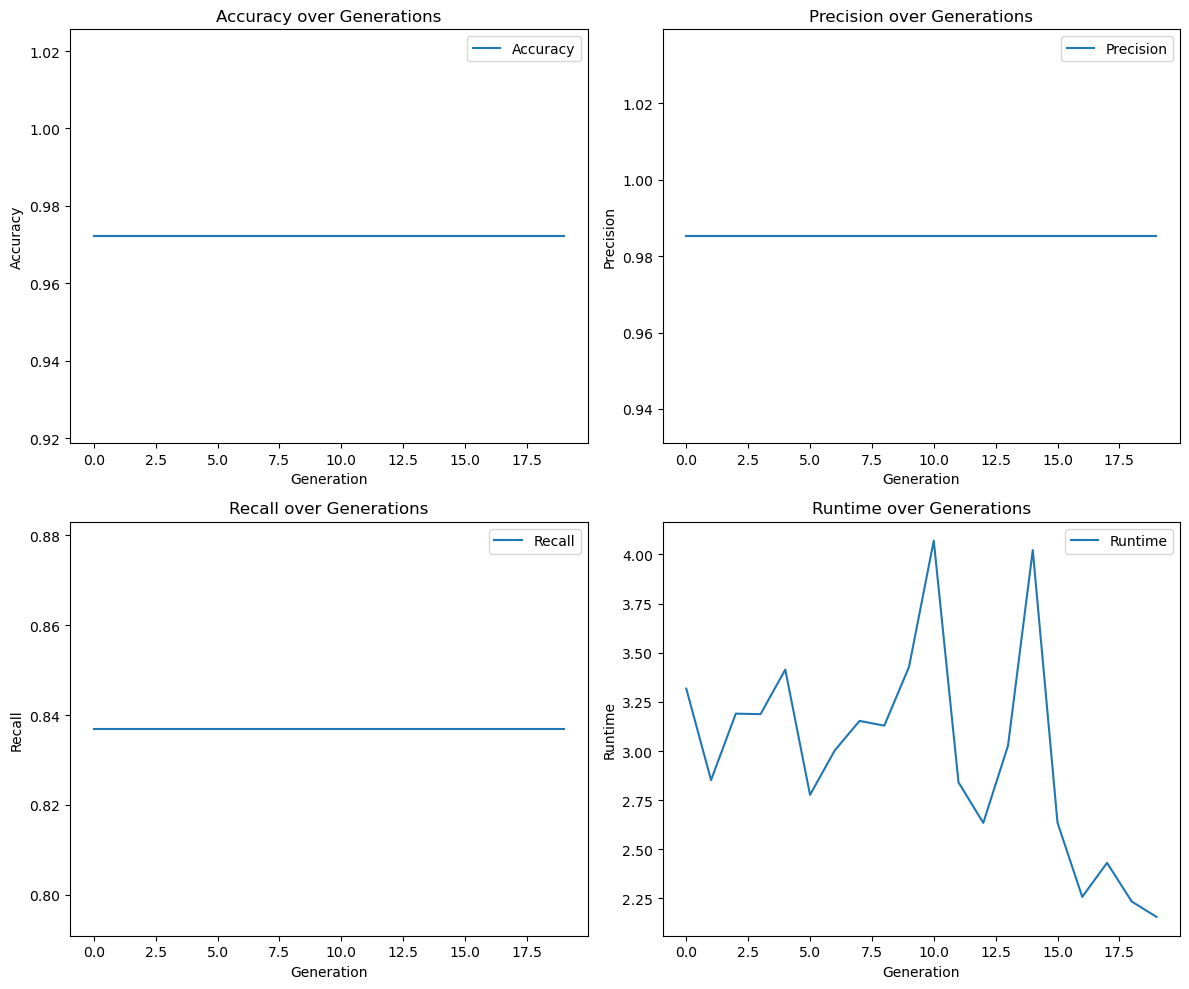

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 2:
              precision    recall 

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.97575
Overall Precision: 0.707791328

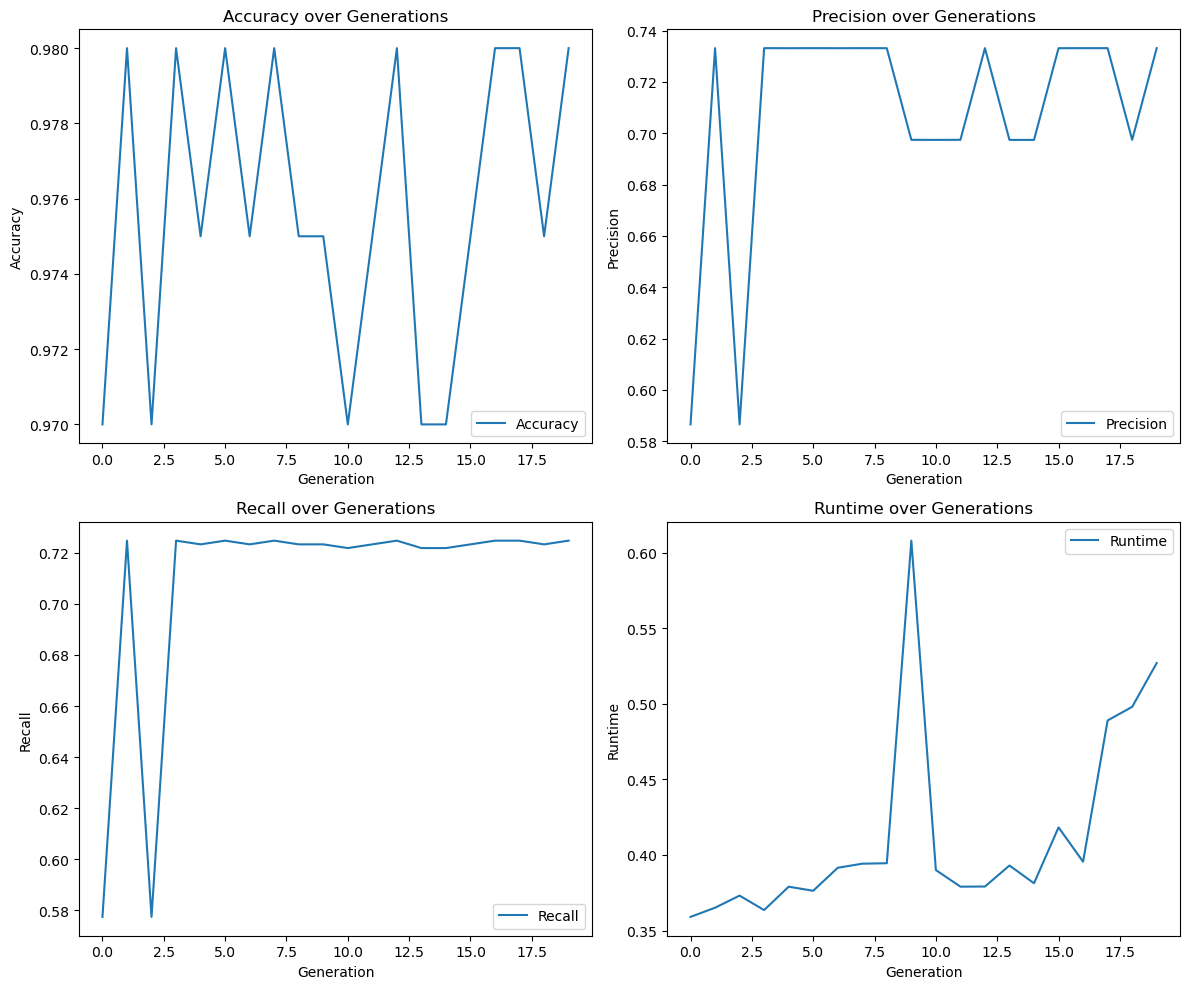

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9752500000000002
Overall Precision: 0.7

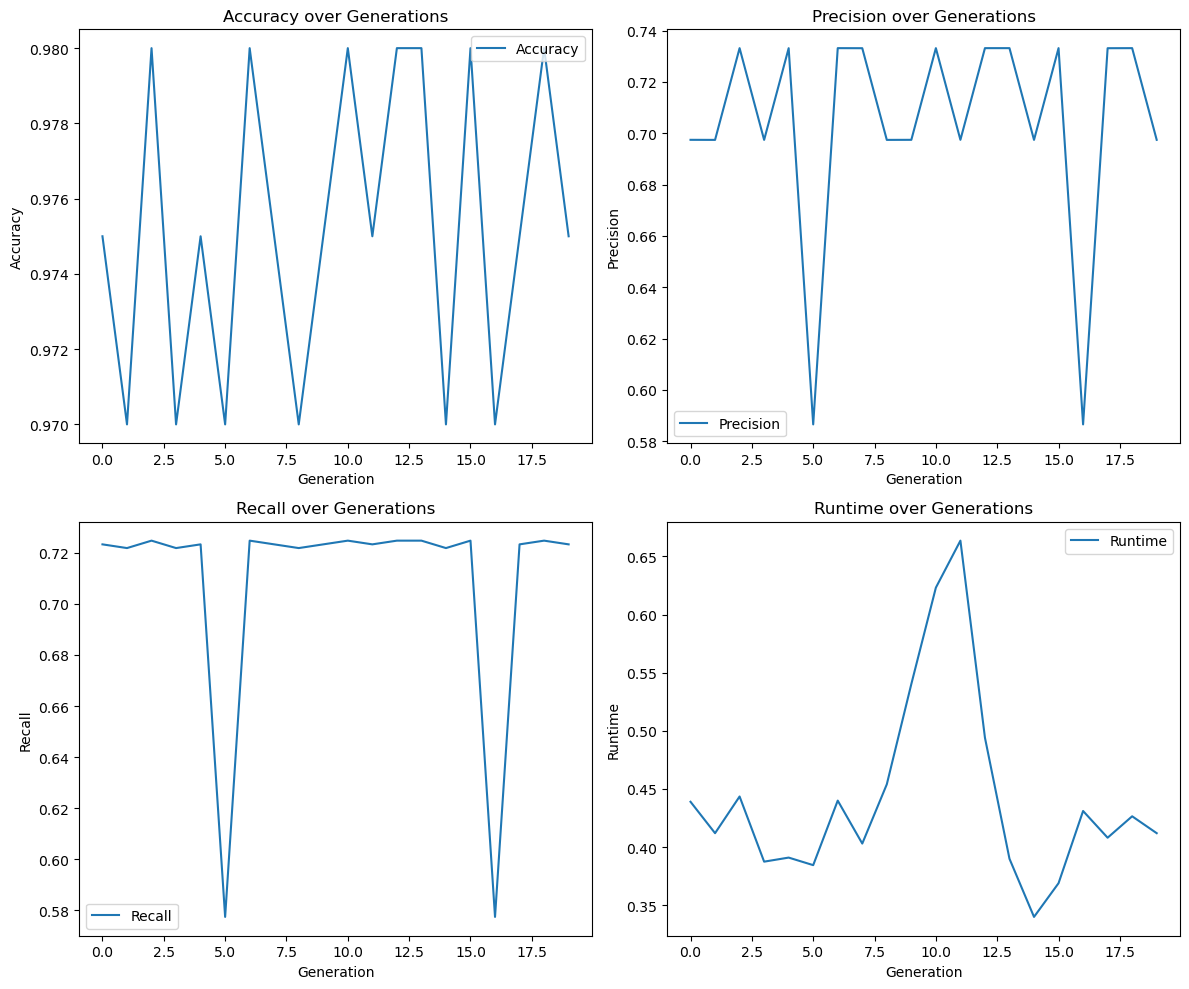


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 29.934260487556458 seconds
Average Memory Usage: 3030.7434895833335 MB
Average Computational Cost: 11552.09895833333
Average Accuracy: 0.9736999999999999

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 30.955901900927227 seconds
Average Memory Usage: 3181.8430989583335 MB
Average Computational Cost: 11554.078124999998
Average Accuracy: 0.9734916666666665

Iteration 4:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy   

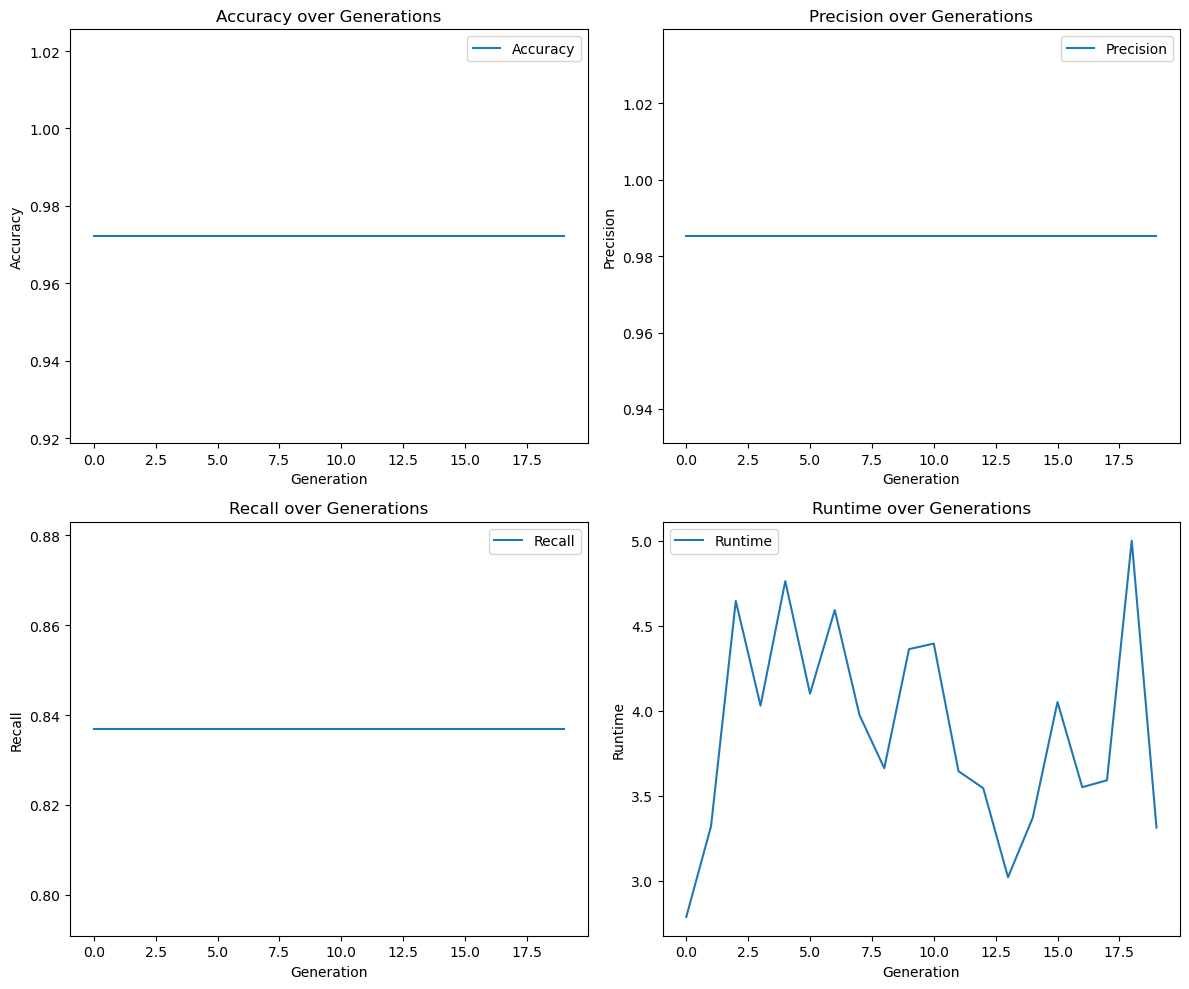

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

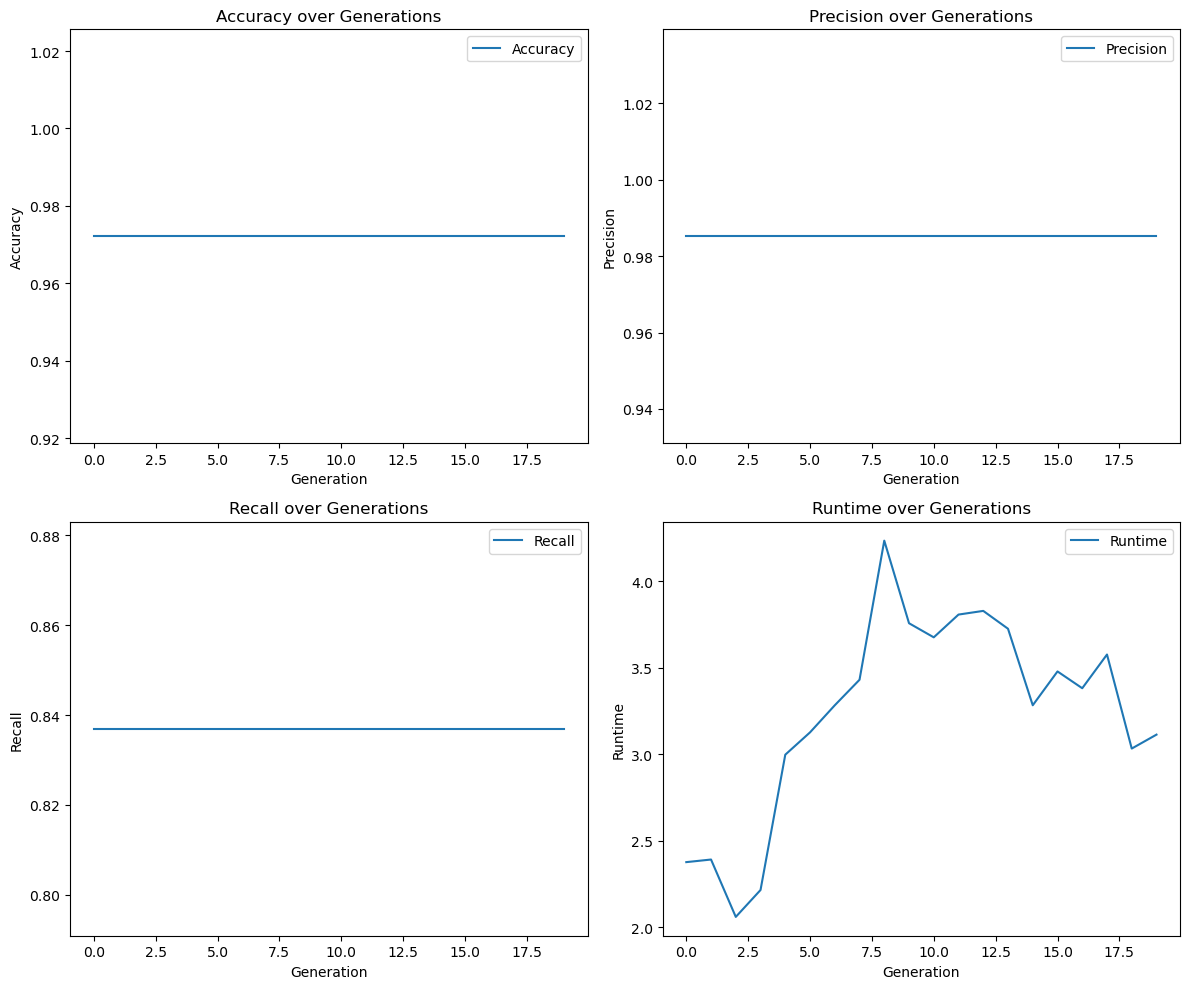

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.96       200
   macro avg       0.56      0.58      0.57       200
weighted avg       0.97      0.96      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Ov

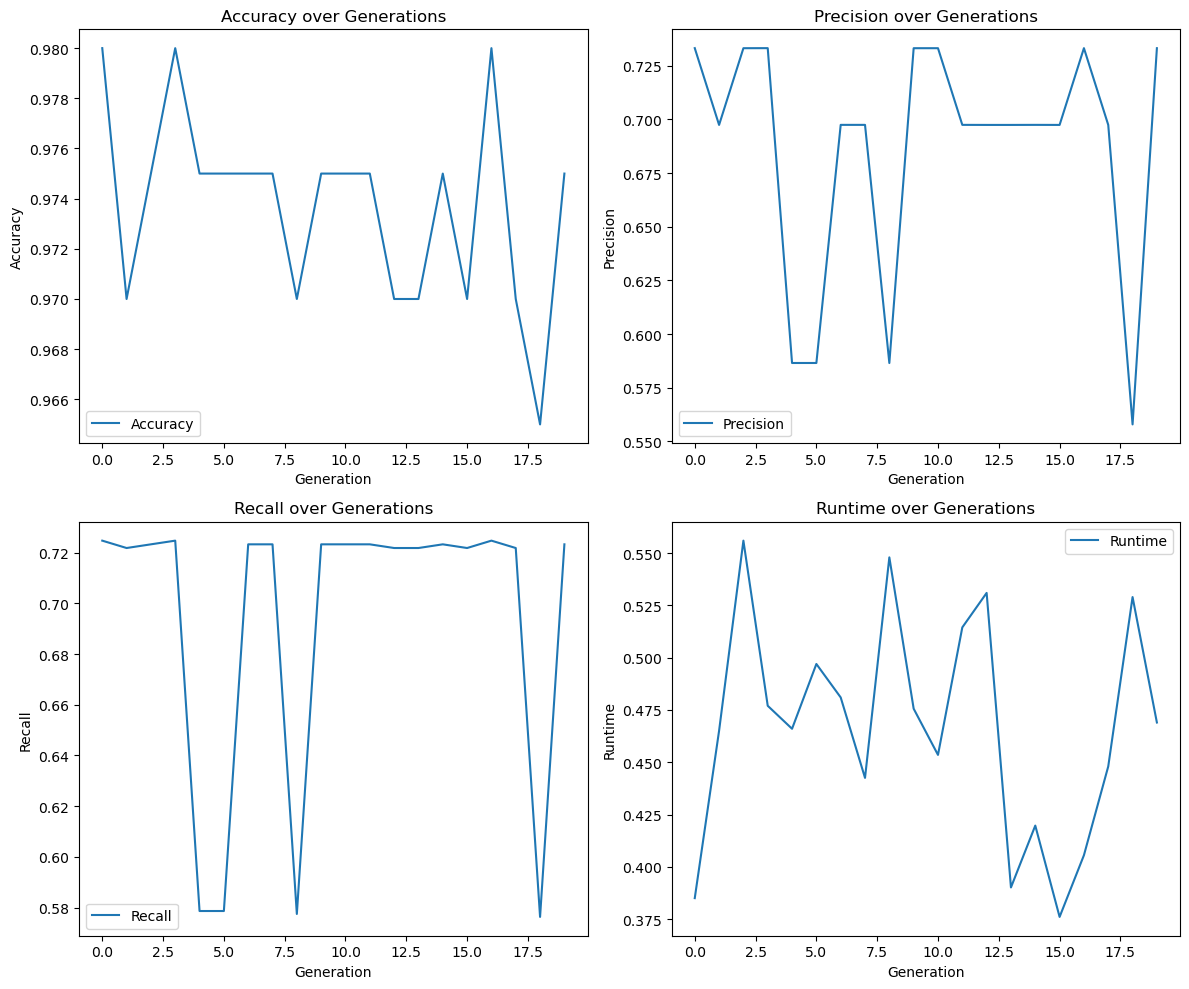

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.97575
Overall Precision: 0.7133369949149634
Total Runtime: 10.961721897125244 seconds
Total Memory Usage: 3587.77734375 MB
Total Computational Cost: 11578.125


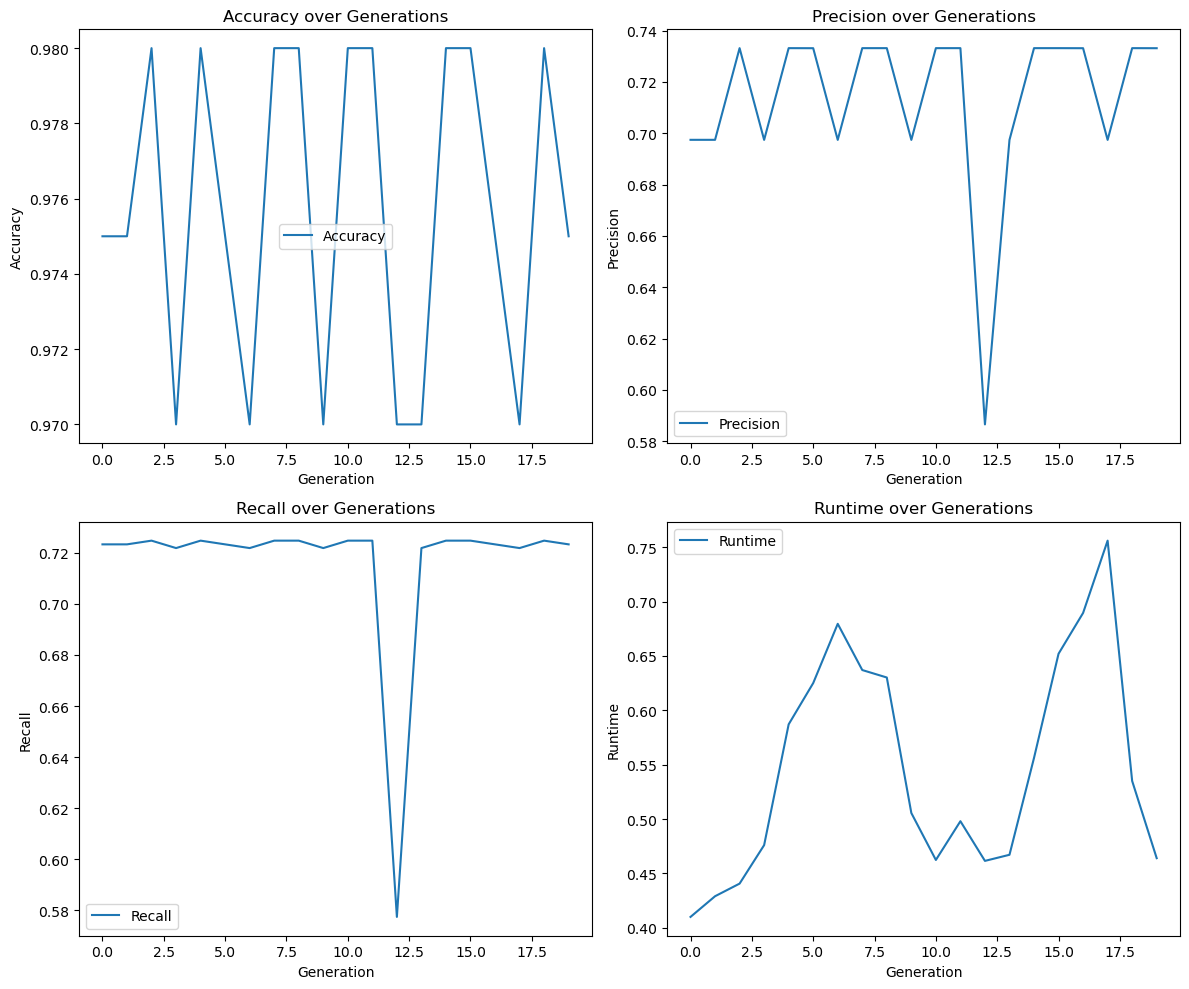


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 33.330870389938354 seconds
Average Memory Usage: 3259.94775390625 MB
Average Computational Cost: 11554.968749999998
Average Accuracy: 0.9735125

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 32.684162855148315 seconds
Average Memory Usage: 3328.7216796875 MB
Average Computational Cost: 11555.859374999998
Average Accuracy: 0.97360625

Iteration 5:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                        

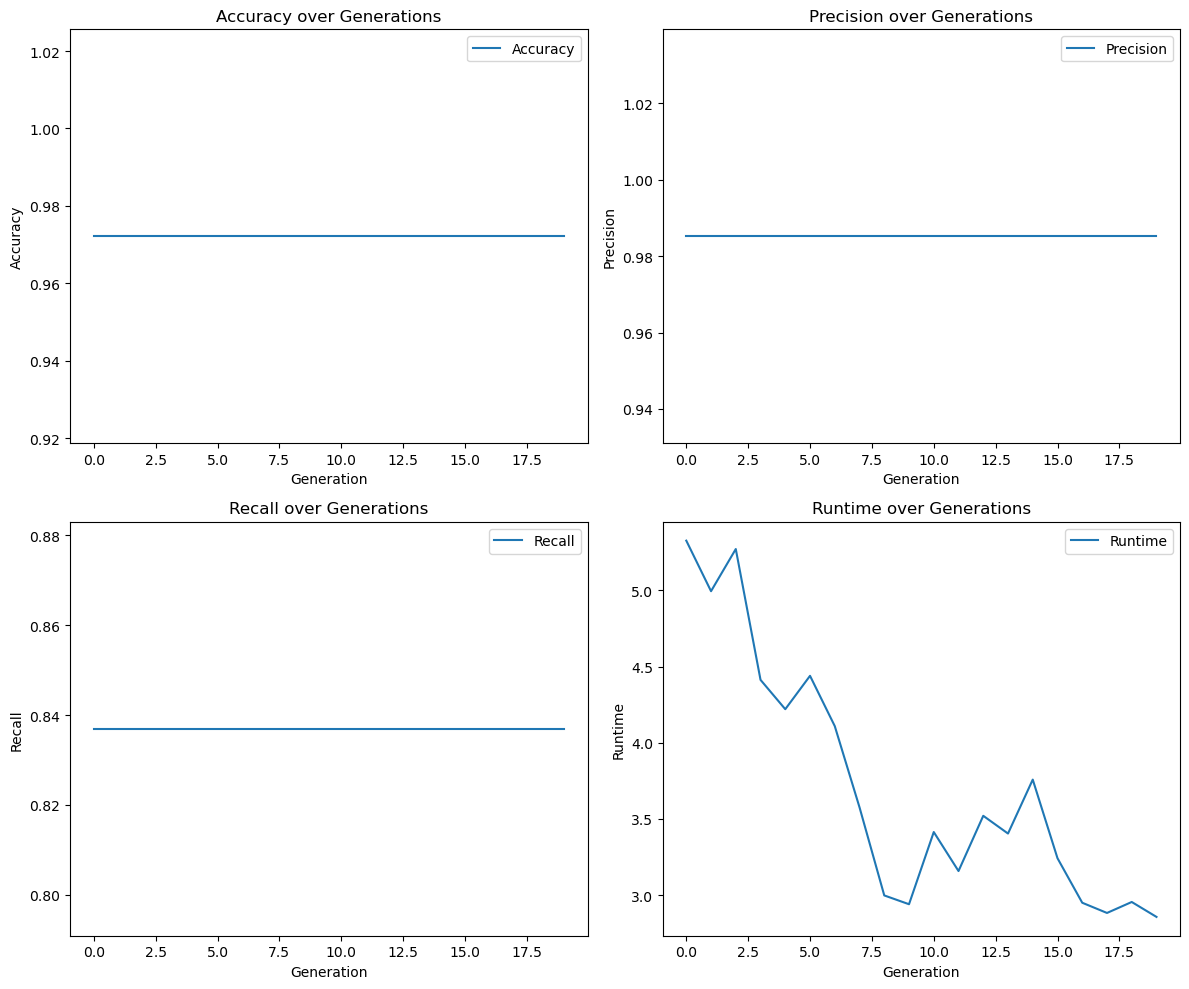

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

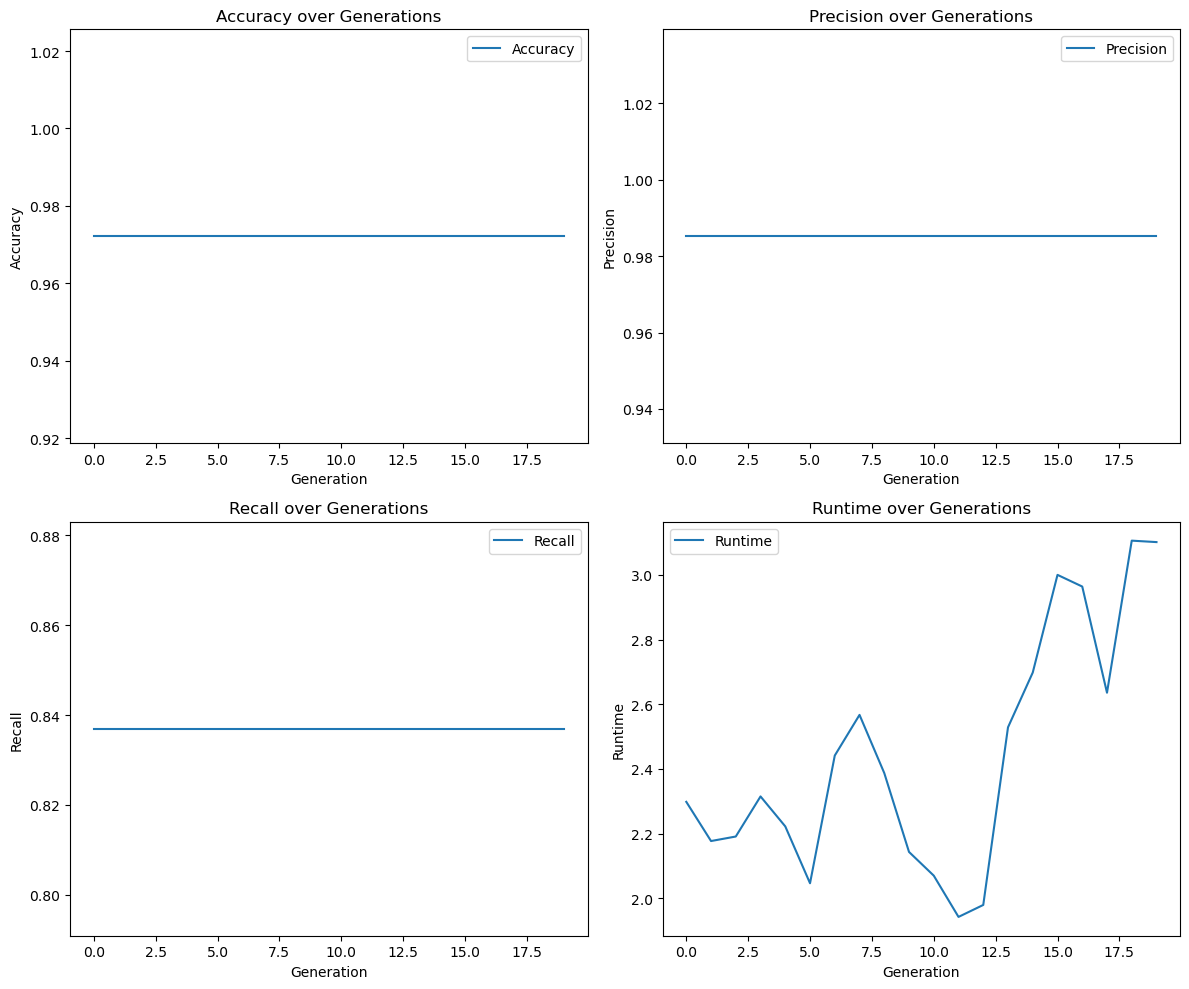

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9732500000000002
Overall Precision: 0.7065389763296369
Total Runtime: 7.704062223434448 seconds
Total Memory Usage: 3943.26171875 MB
Total Computational Cost: 11563.875


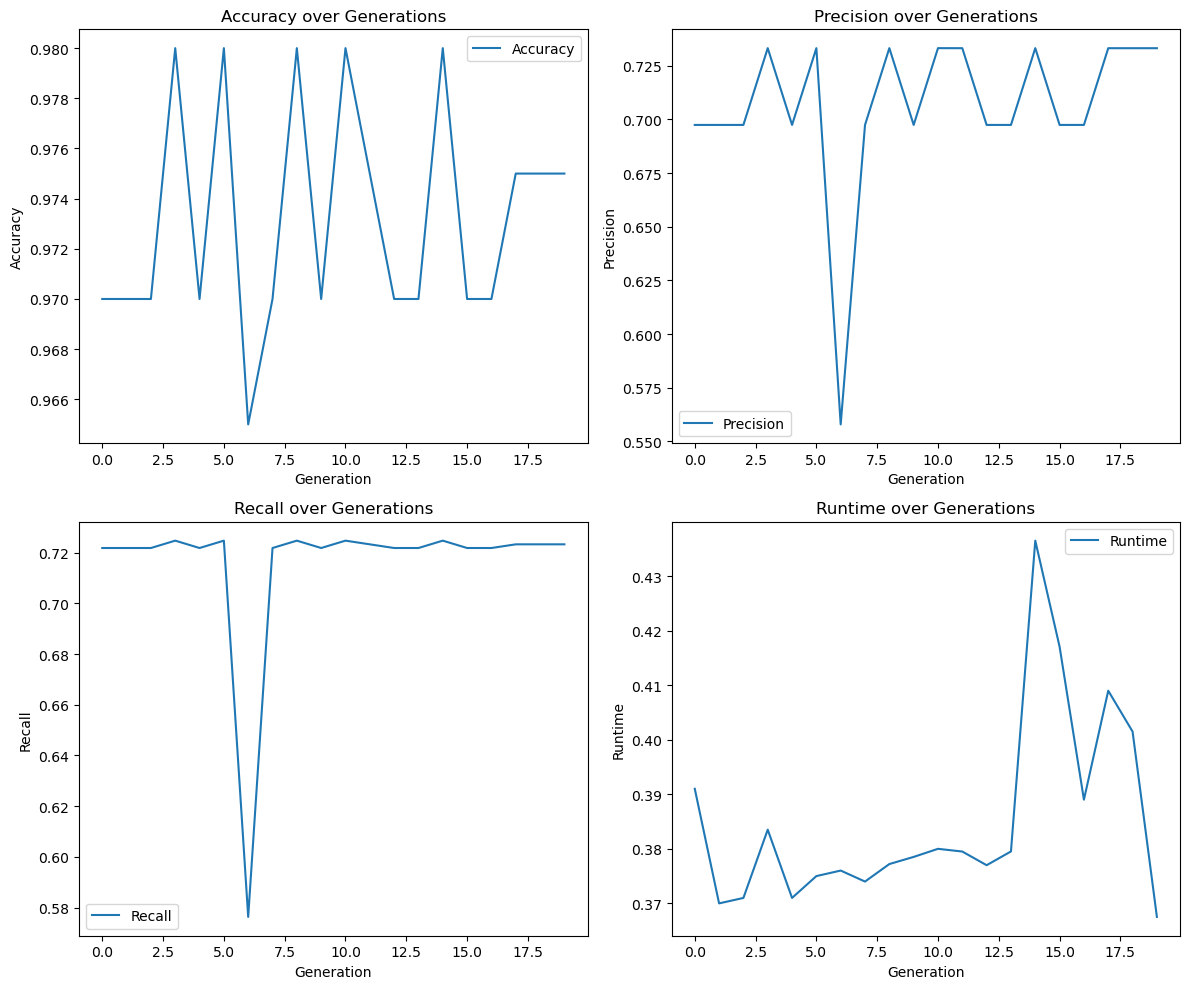

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9765
Overall Precision: 0.7186979185222071
Total Runtime: 8.55354905128479 seconds
Total Memory Usage: 4035.9375 MB
Total Computational Cost: 11575.75


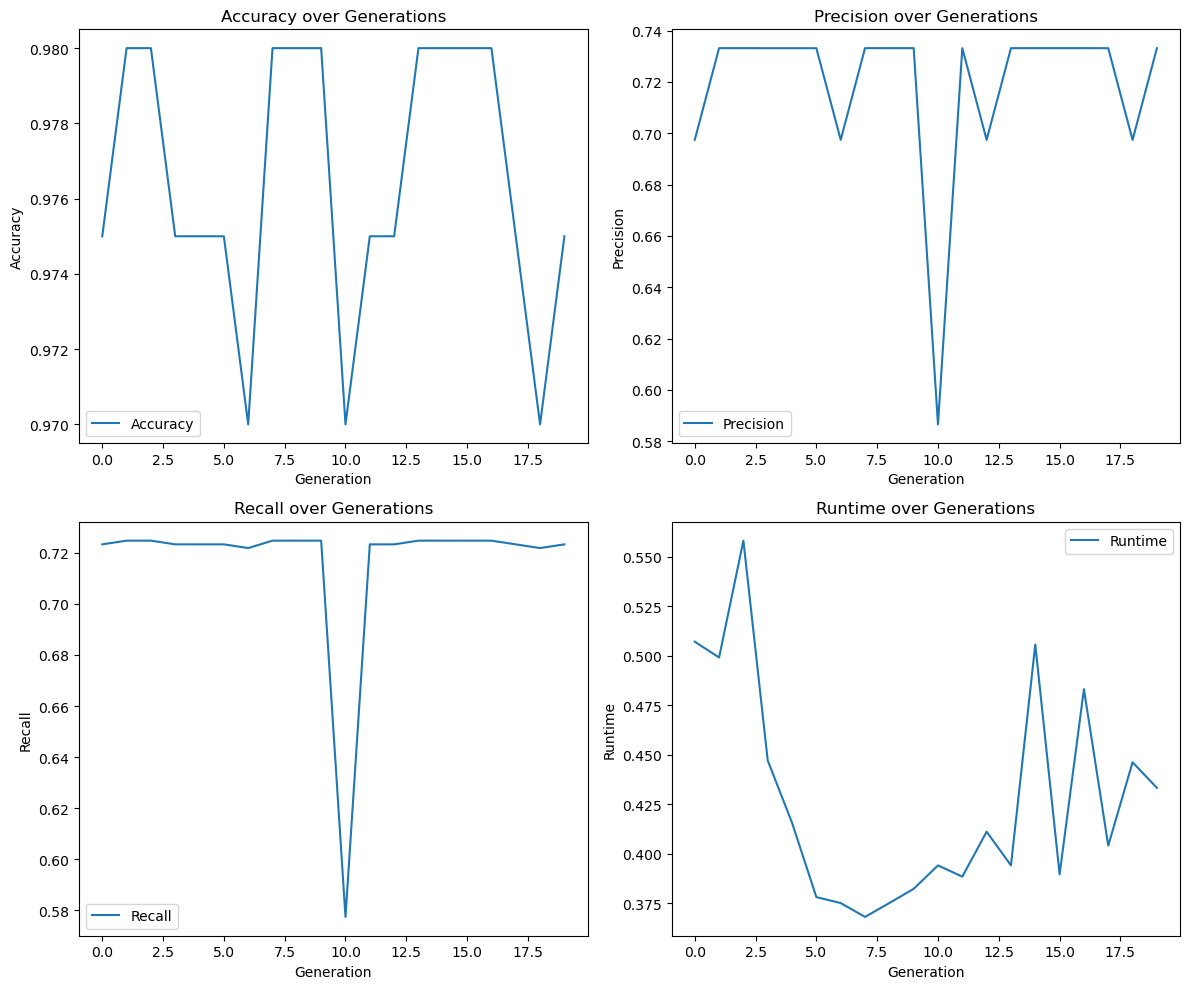


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.87789266109466 seconds
Average Memory Usage: 3377.6671875 MB
Average Computational Cost: 11554.790624999998
Average Accuracy: 0.9733499999999999

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 31.88378052711487 seconds
Average Memory Usage: 3451.92265625 MB
Average Computational Cost: 11556.690625
Average Accuracy: 0.9737499999999999

Iteration 6:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                     

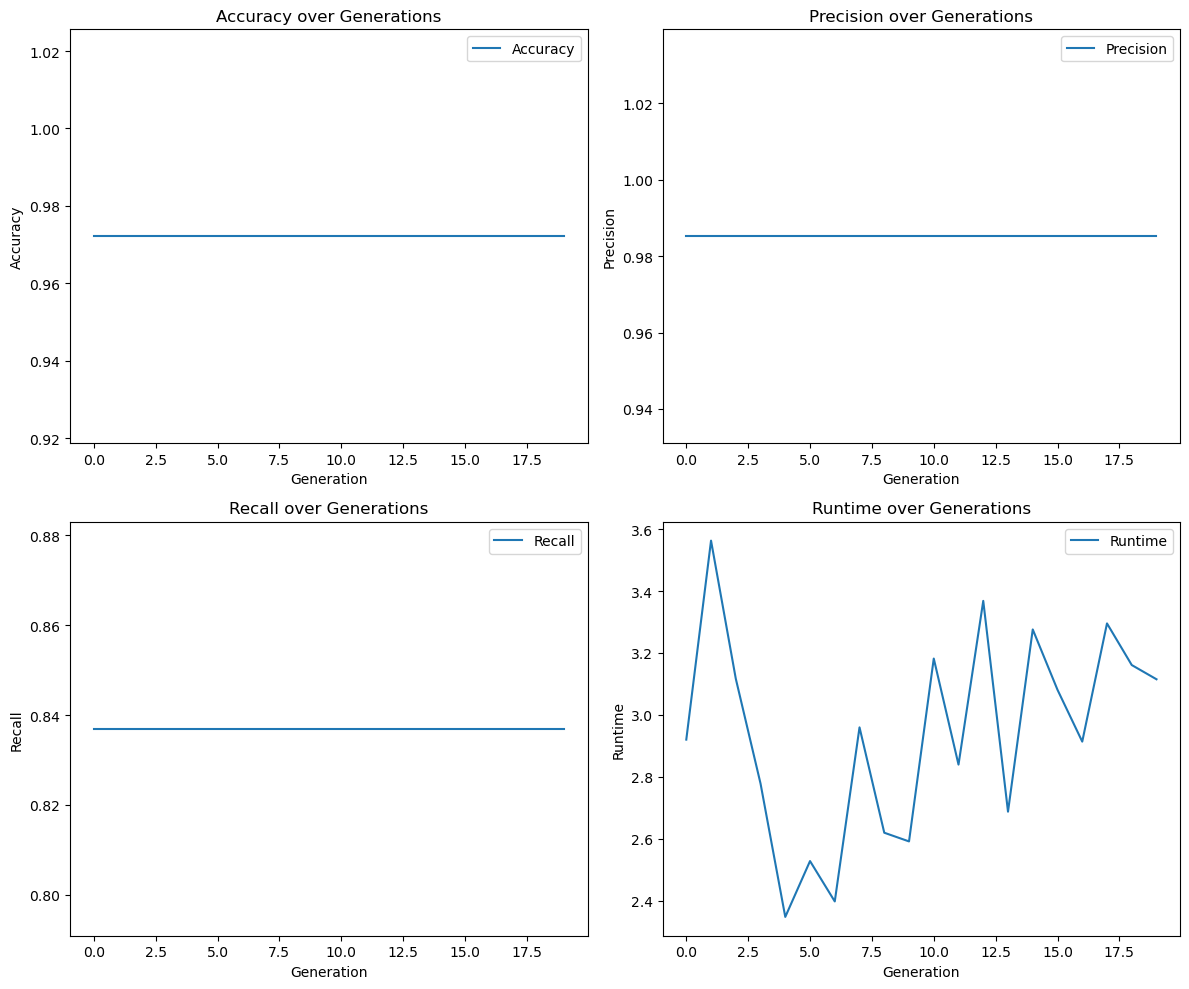

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

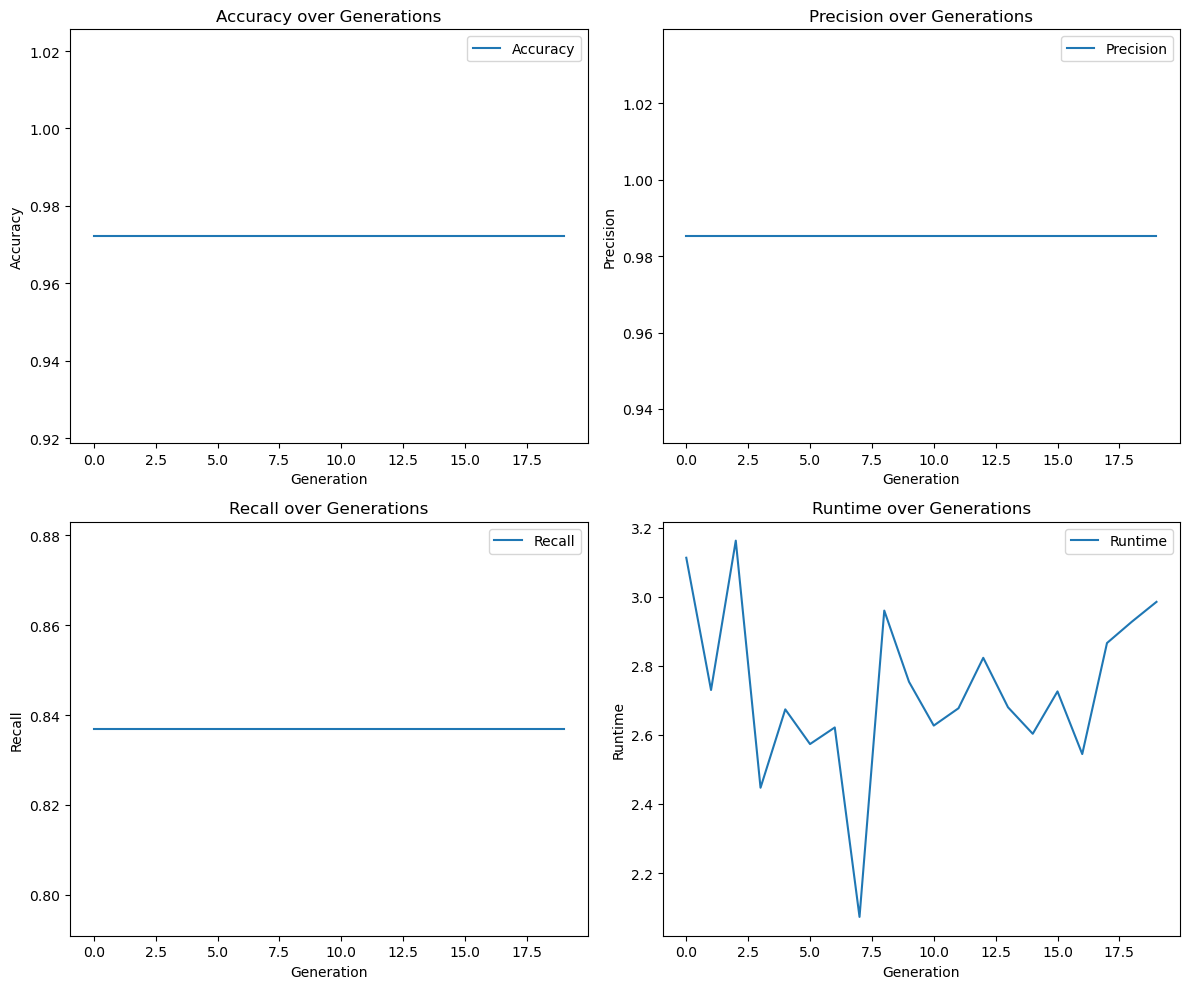

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97      

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.97425
Overall Precision: 0.686146503

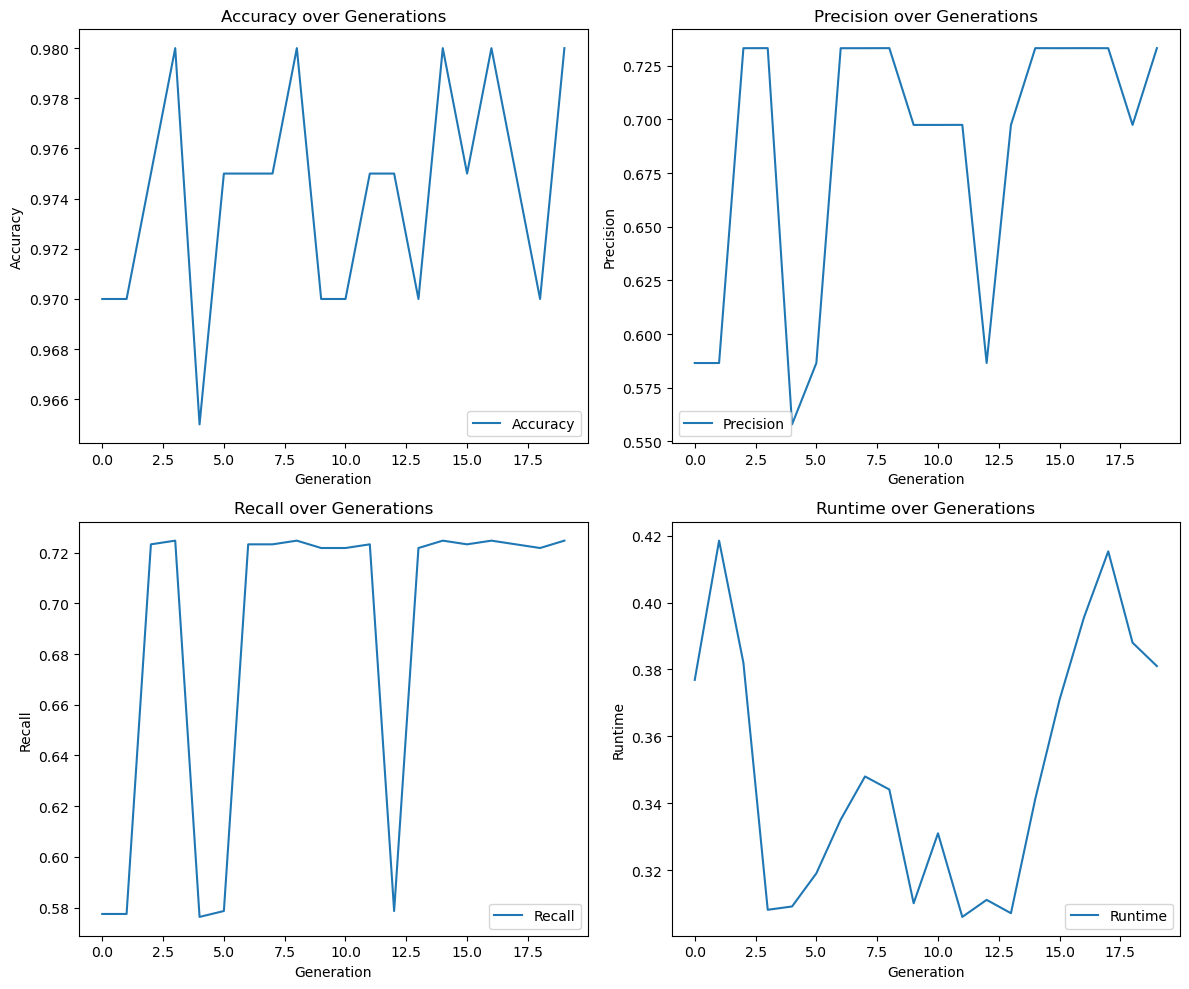

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.97475
Overall Precision: 0.704929428195

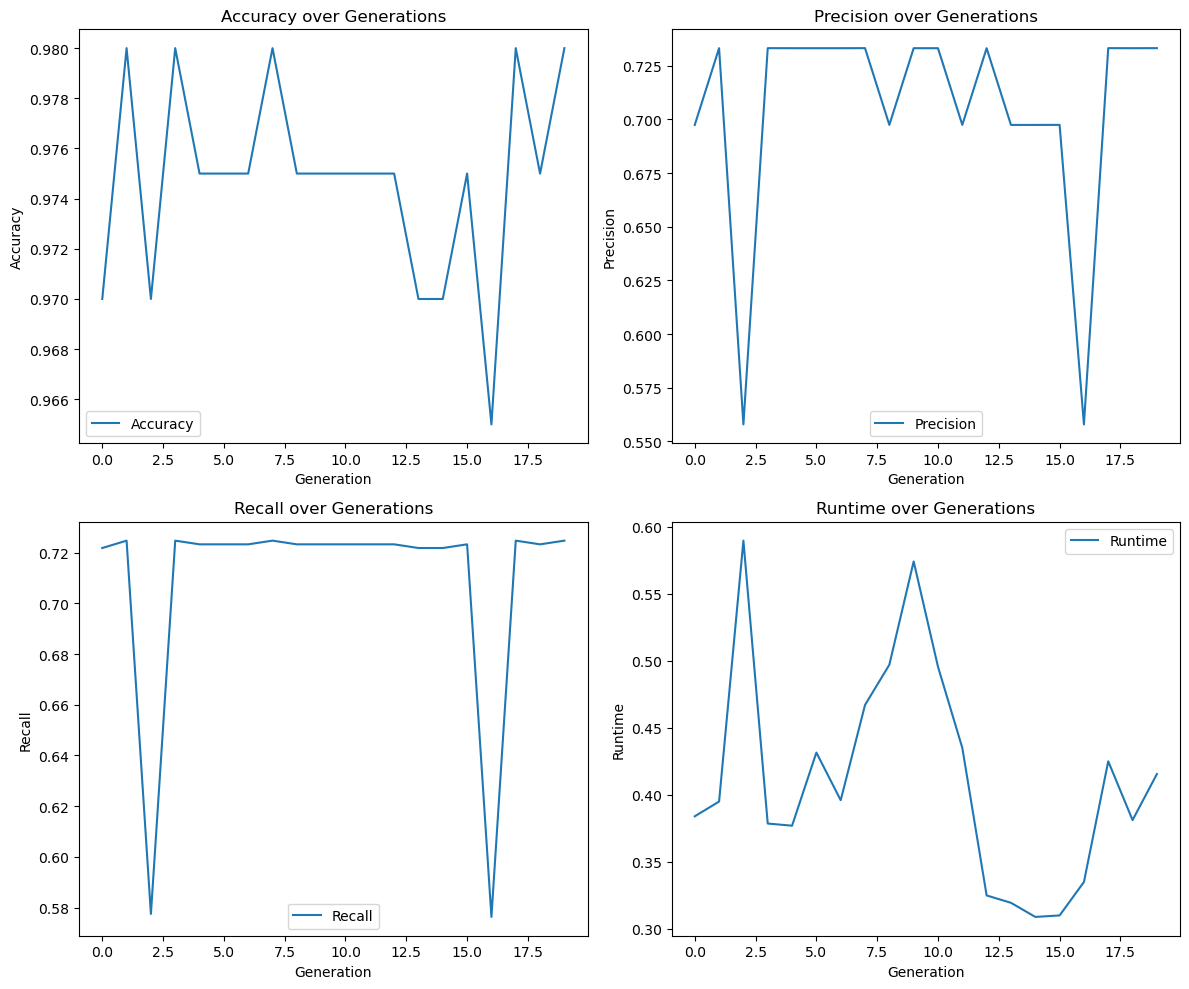


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.54295766353607 seconds
Average Memory Usage: 3438.2945963541665 MB
Average Computational Cost: 11555.265625
Average Accuracy: 0.9733249999999999

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 31.803923825422924 seconds
Average Memory Usage: 3517.8059895833335 MB
Average Computational Cost: 11556.848958333334
Average Accuracy: 0.9736999999999999

Iteration 7:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy         

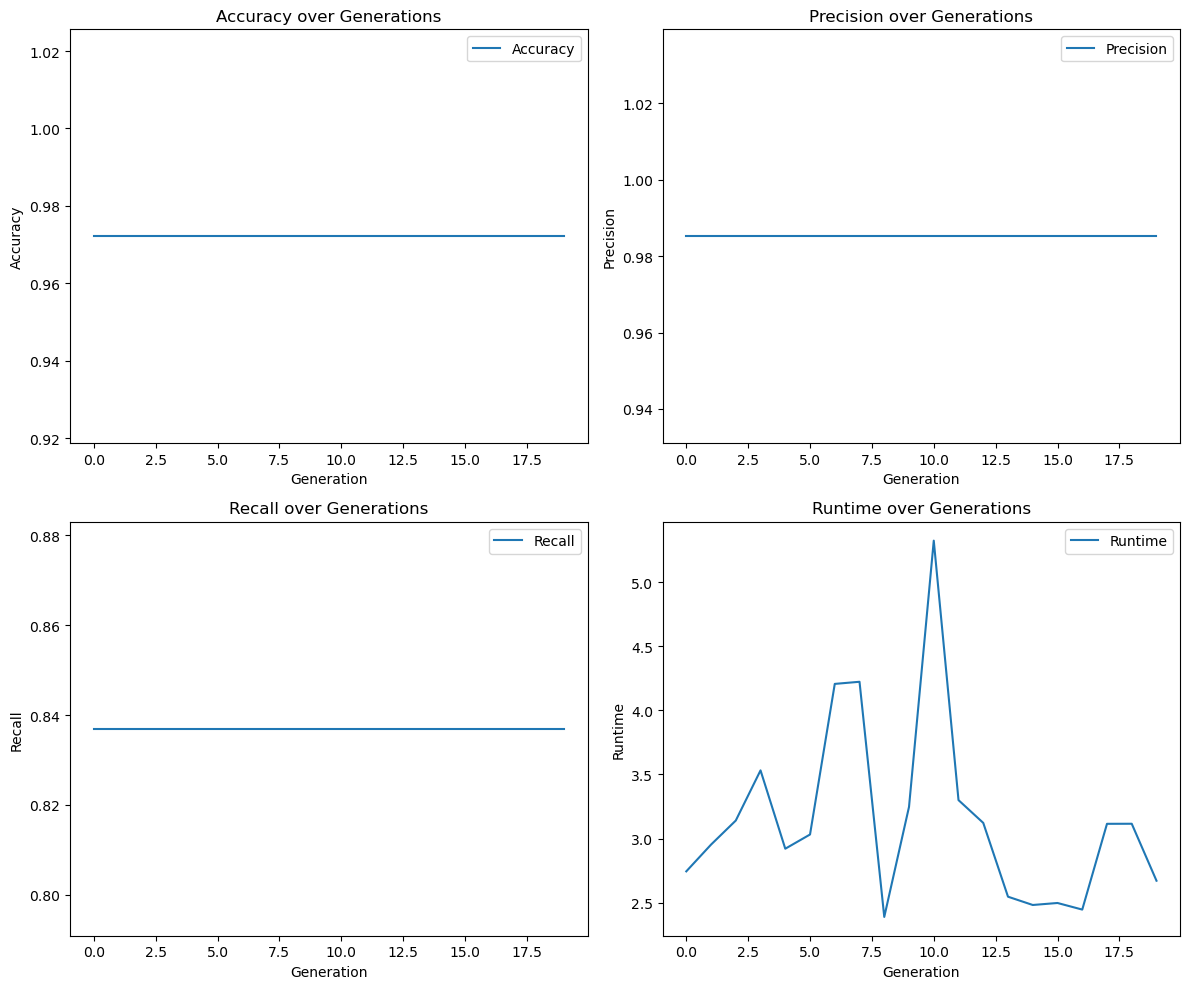

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

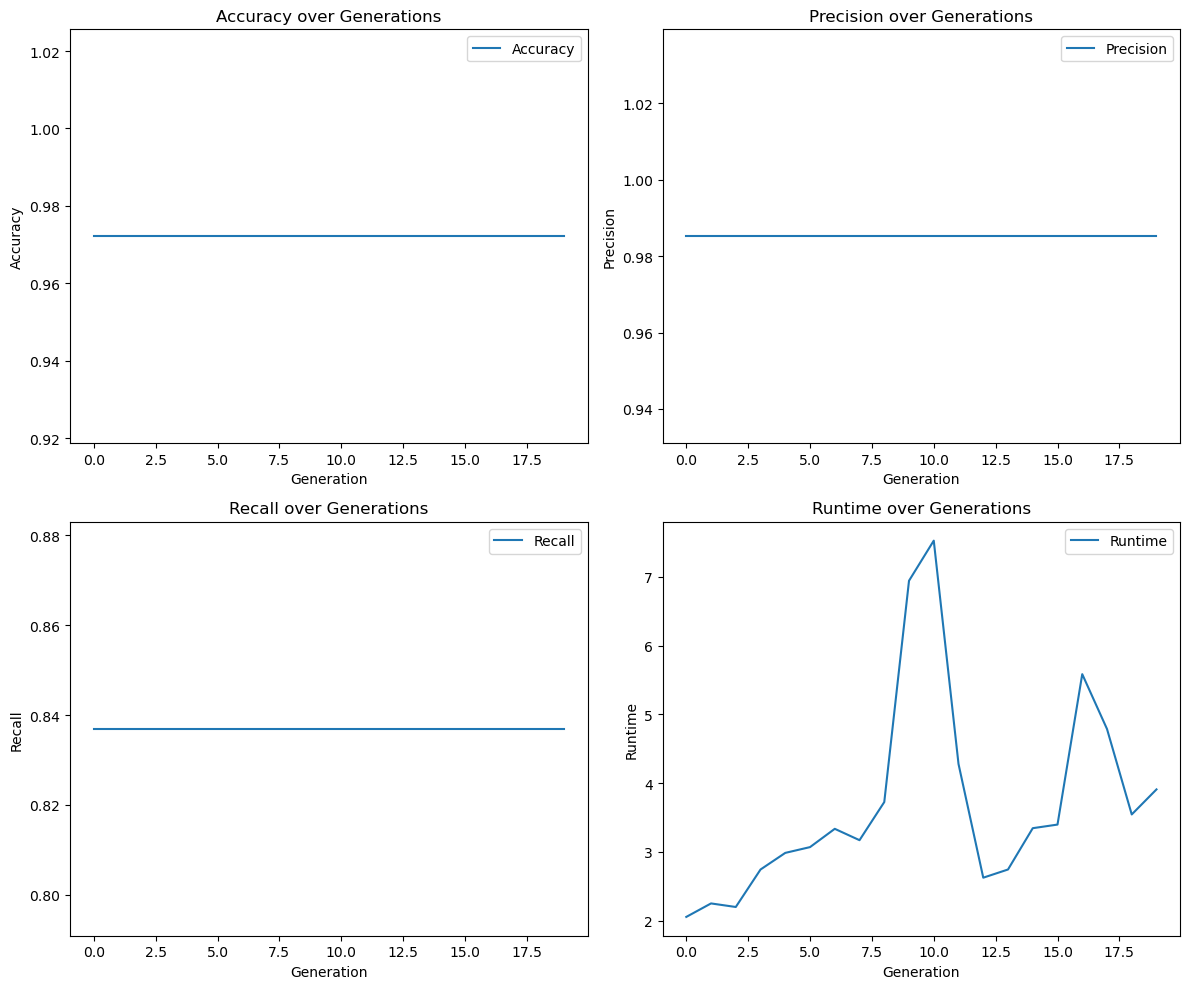

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.96       200
   macro avg       0.56      0.58      0.57       200
weighted avg       0.97      0.96      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.56      0.58      0.57       200
weighted avg       0.97      0.97      0.97    

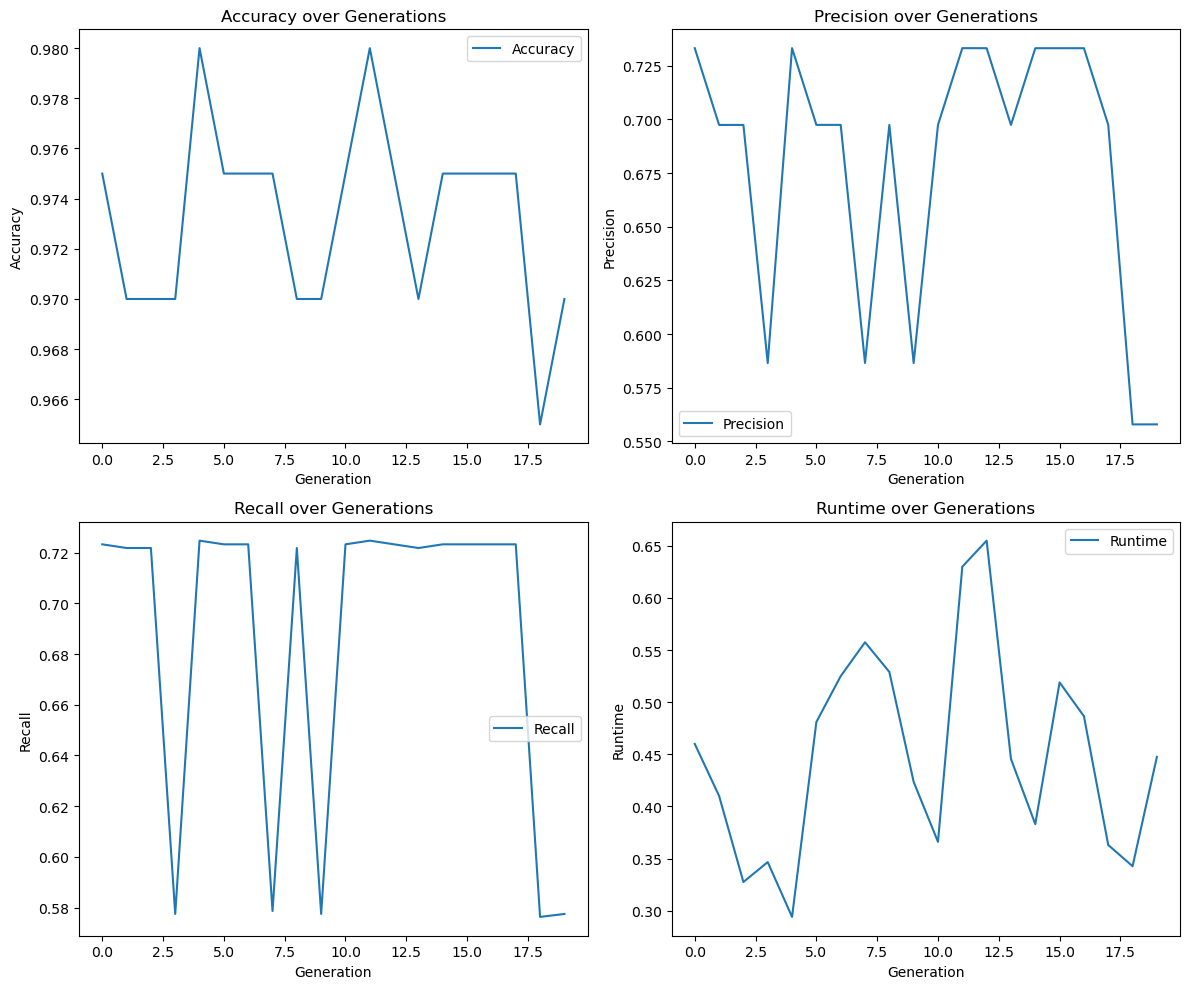

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.56      0.58      0.57       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall 

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9757500000000002
Overall Precision: 0.7154798665434531
Total Runtime: 6.8492820262908936 seconds
Total Memory Usage: 3418.5078125 MB
Total Computational Cost: 11571.0


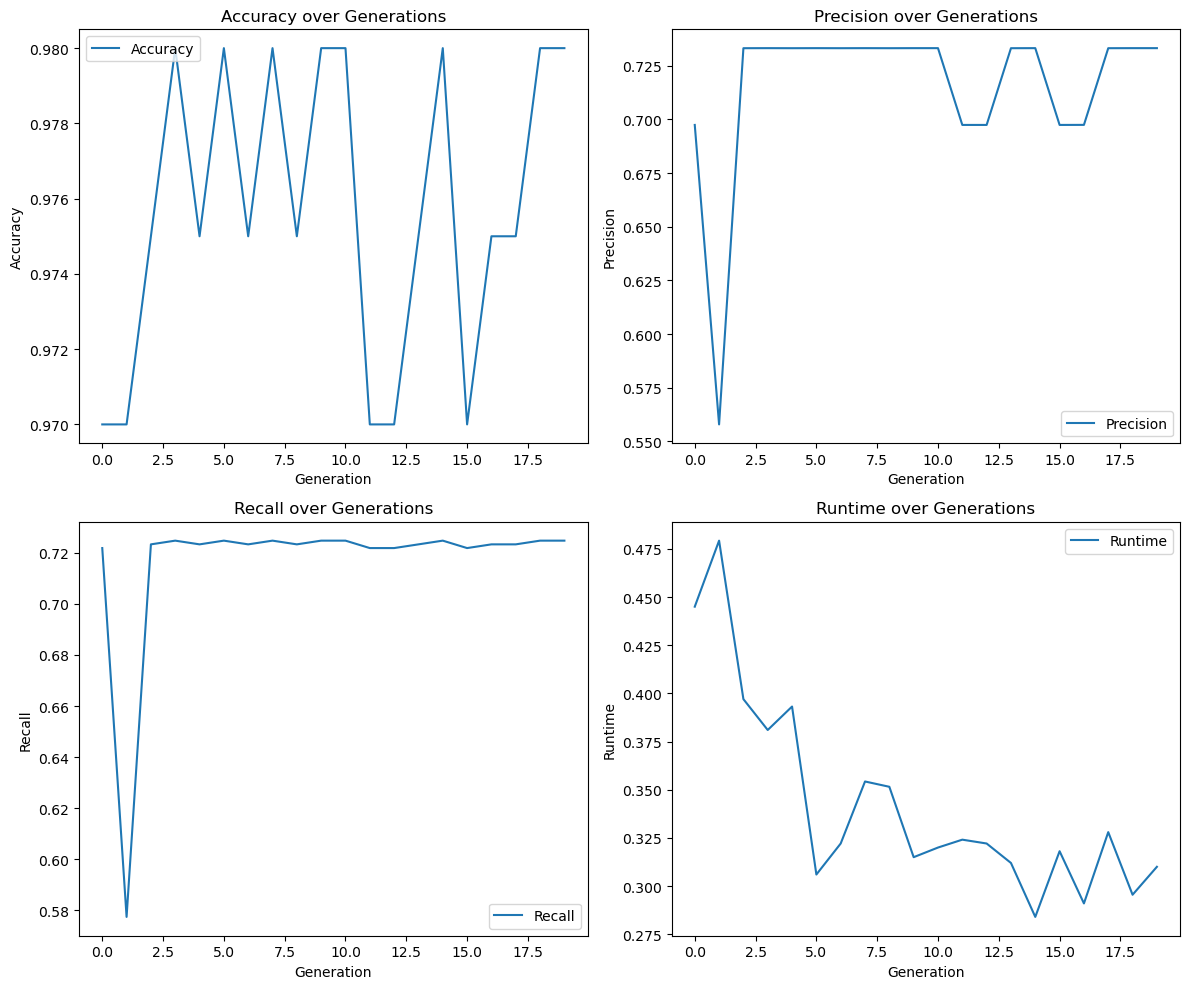


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.751752325466704 seconds
Average Memory Usage: 3477.305245535714 MB
Average Computational Cost: 11554.417410714286
Average Accuracy: 0.9732357142857141

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.051881551742554 seconds
Average Memory Usage: 3527.7659040178573 MB
Average Computational Cost: 11556.96205357143
Average Accuracy: 0.973735714285714

Iteration 8:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy     

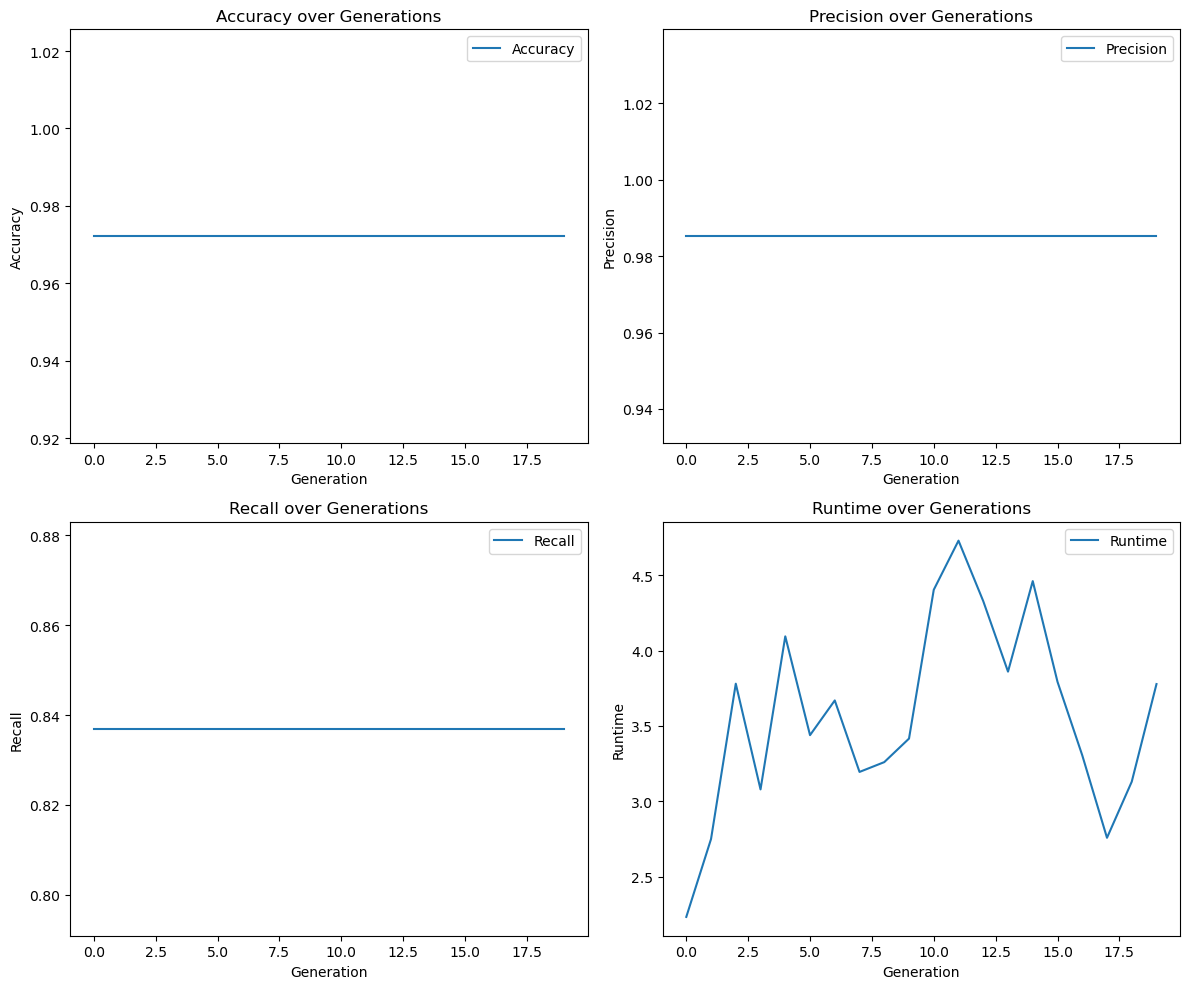

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

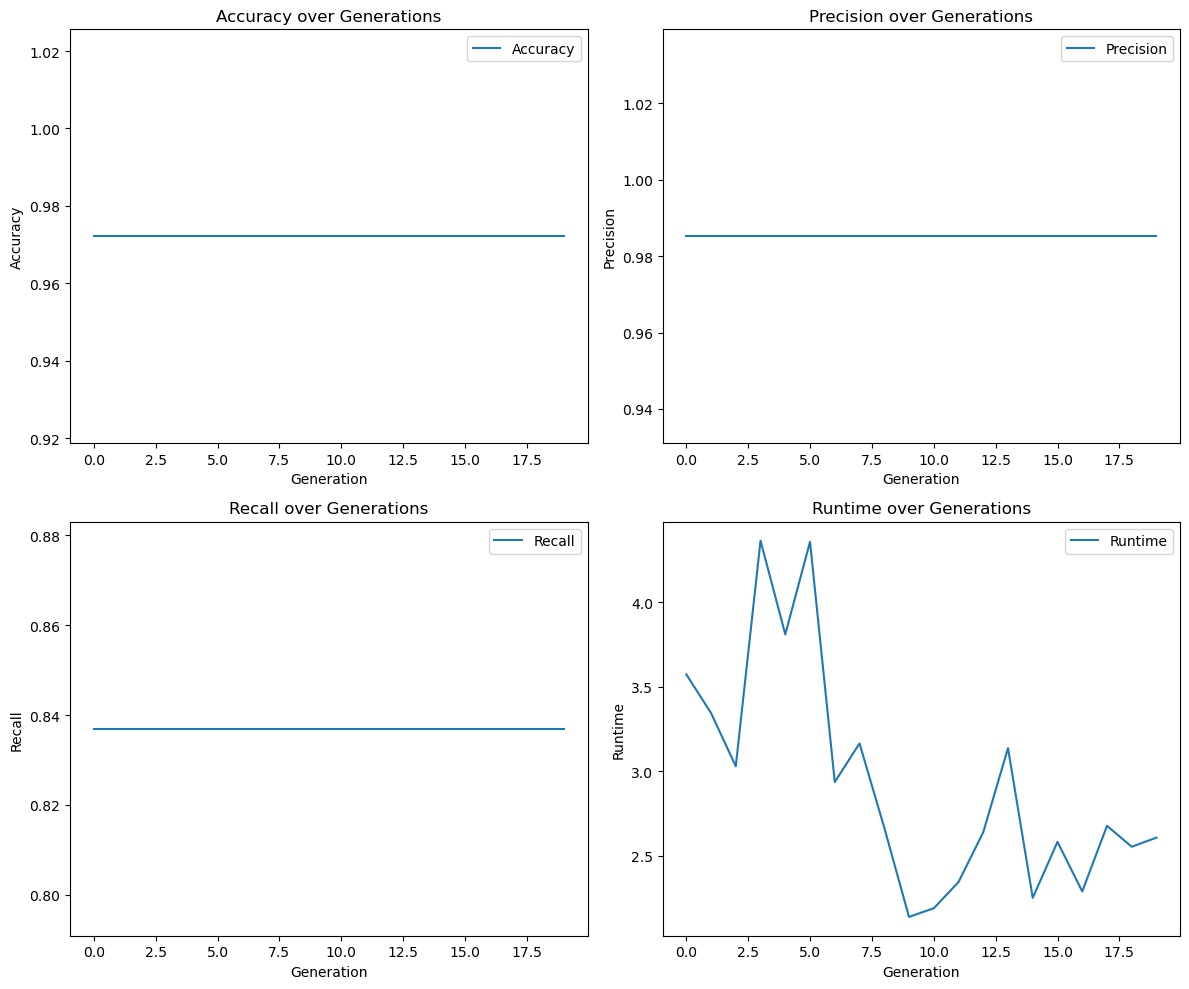

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Ov

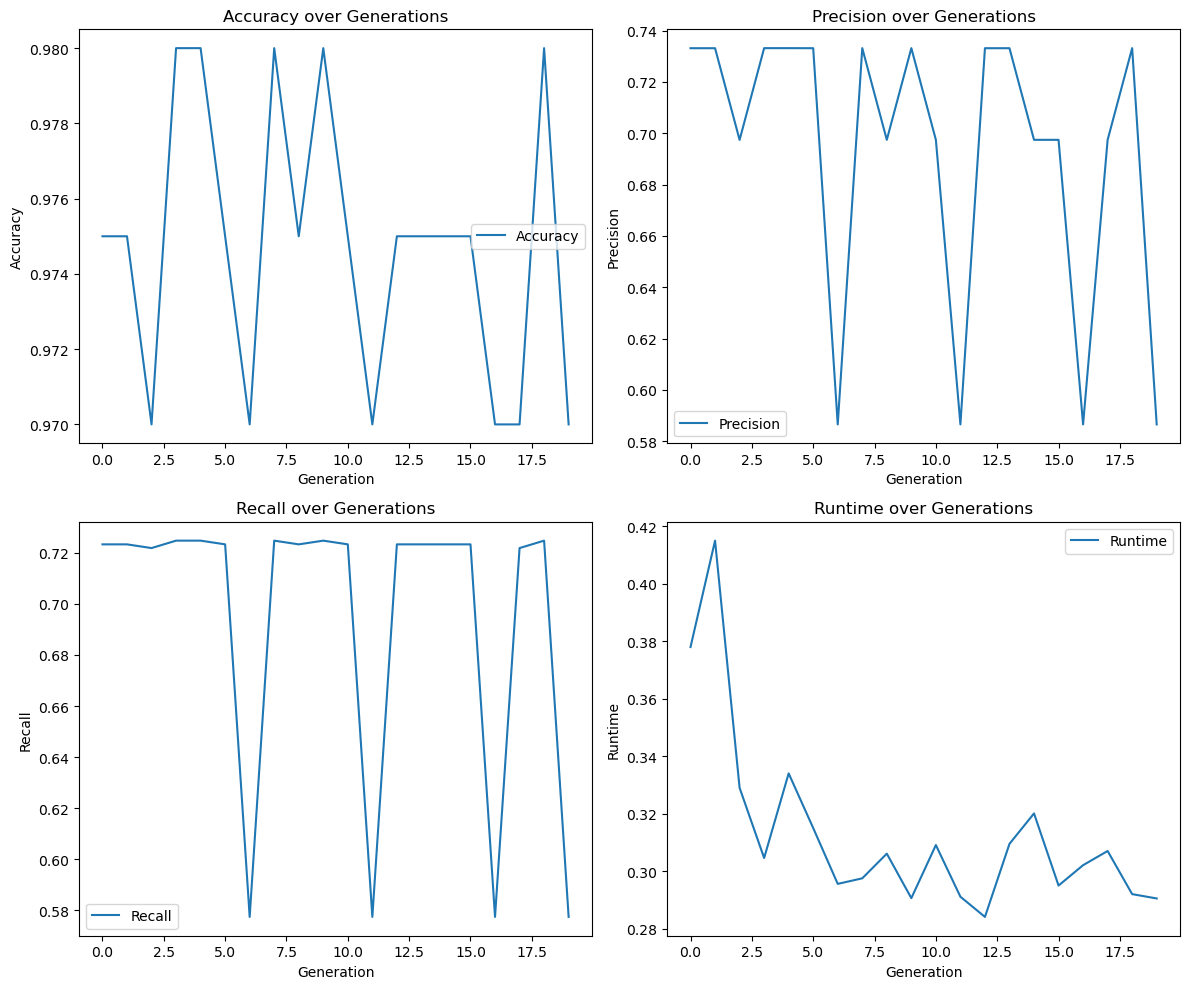

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overa

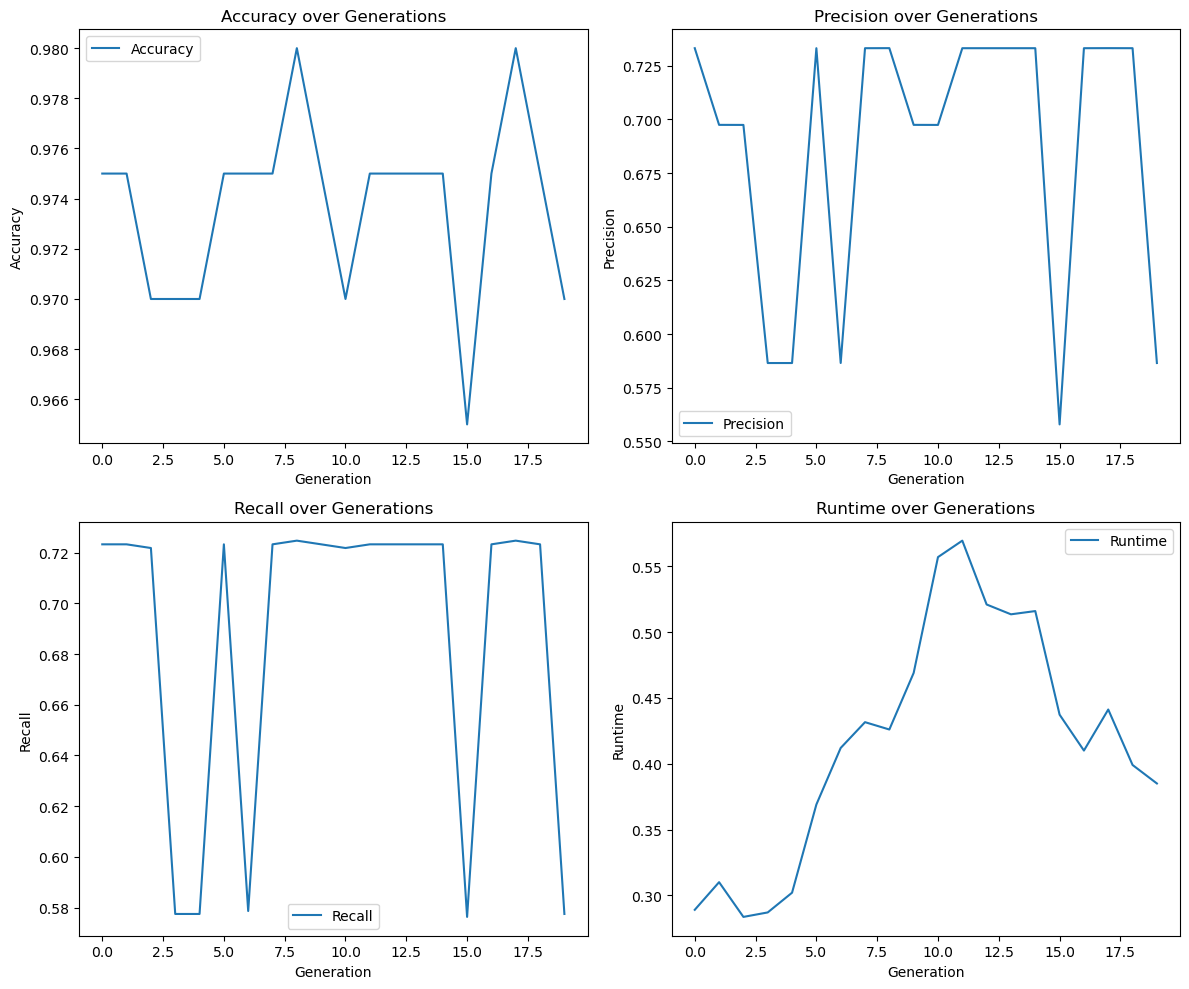


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 35.265914514660835 seconds
Average Memory Usage: 3503.5947265625 MB
Average Computational Cost: 11554.374999999998
Average Accuracy: 0.9732624999999999

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.106269150972366 seconds
Average Memory Usage: 3524.6513671875 MB
Average Computational Cost: 11557.789062499998
Average Accuracy: 0.9736374999999999

Iteration 9:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy        

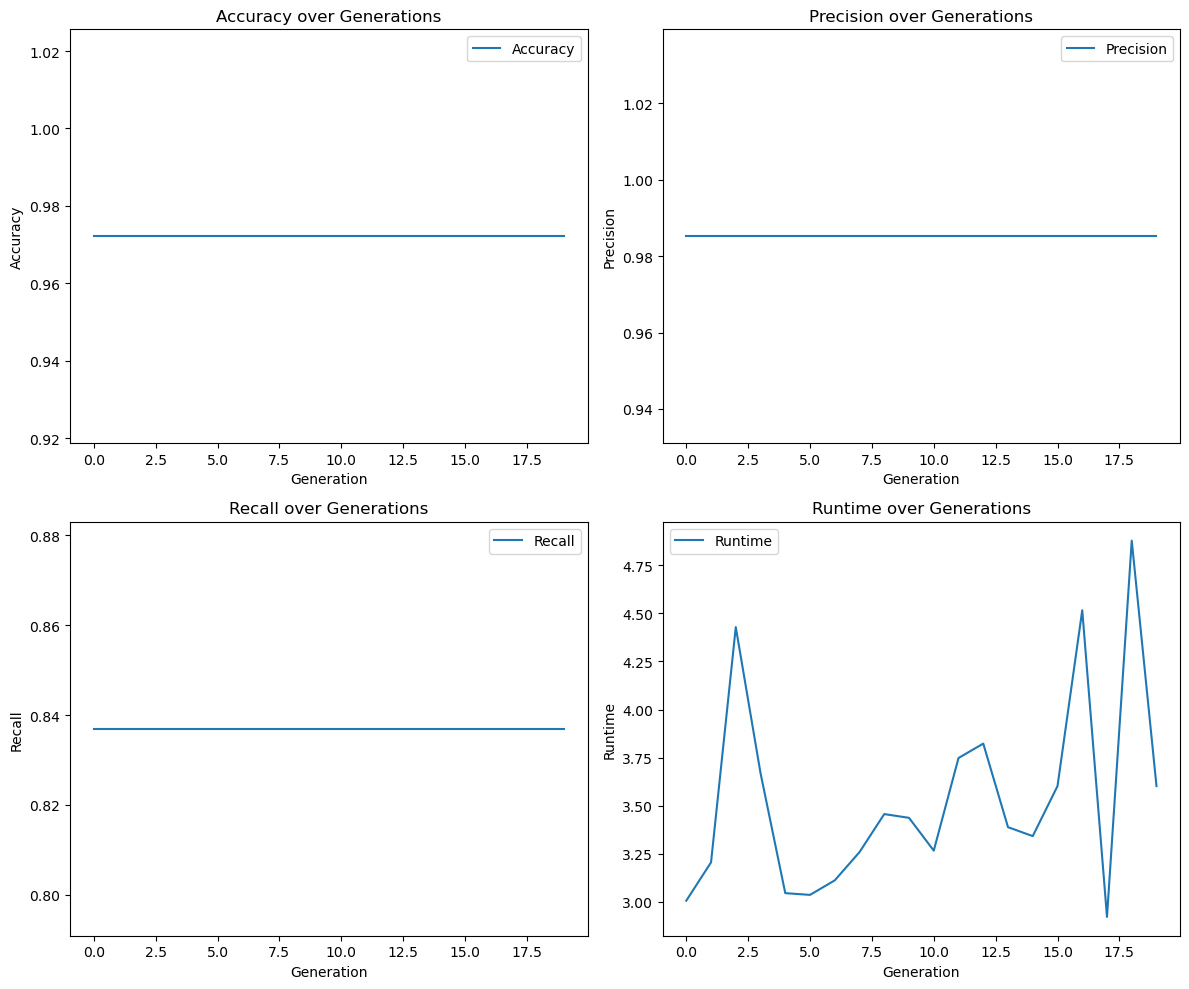

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

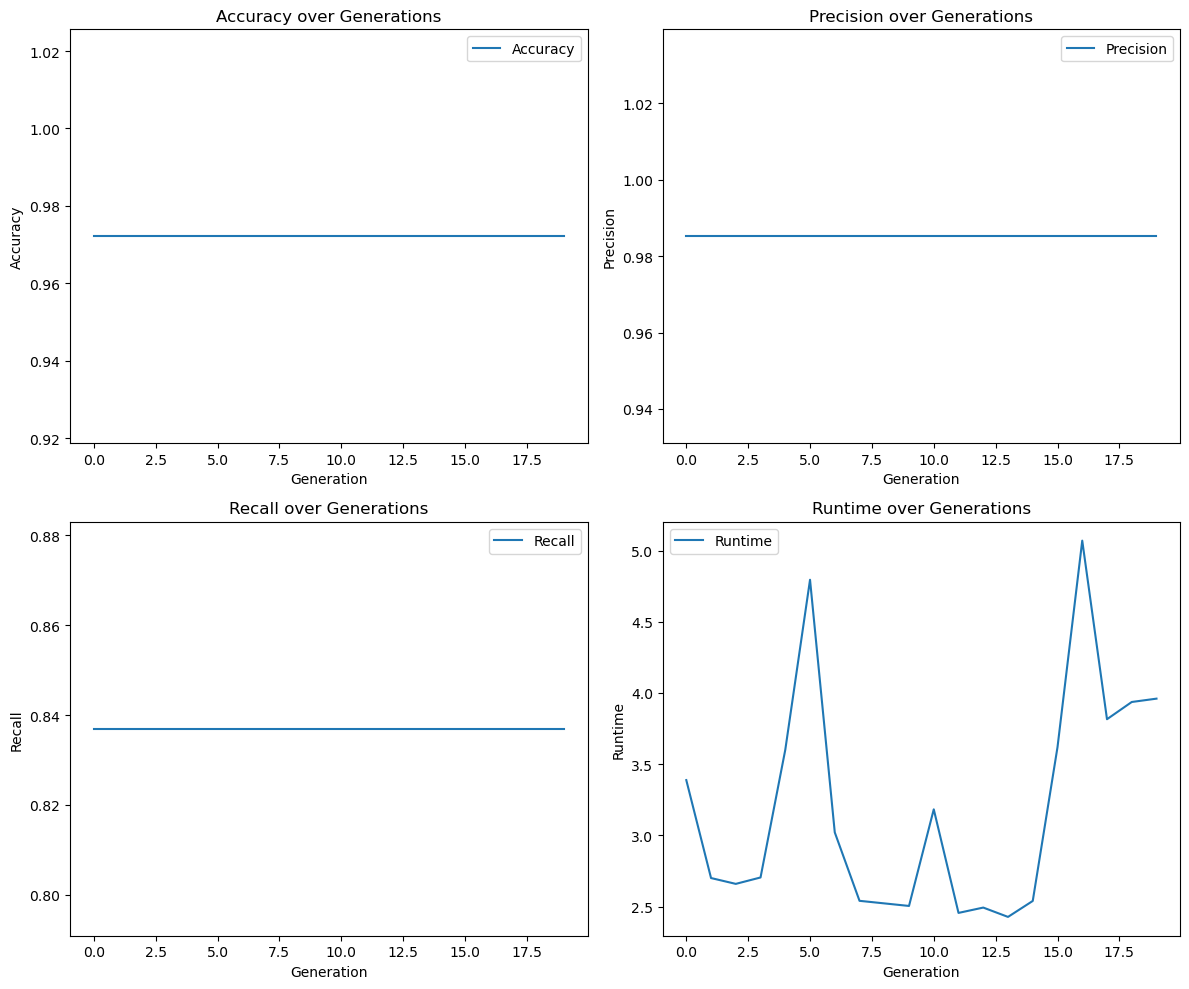

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9750000000000002
Overall Precision: 0.7223485357251683
Total Runtime: 7.819086790084839 seconds
Total Memory Usage: 3687.65625 MB
Total Computational Cost: 11566.25


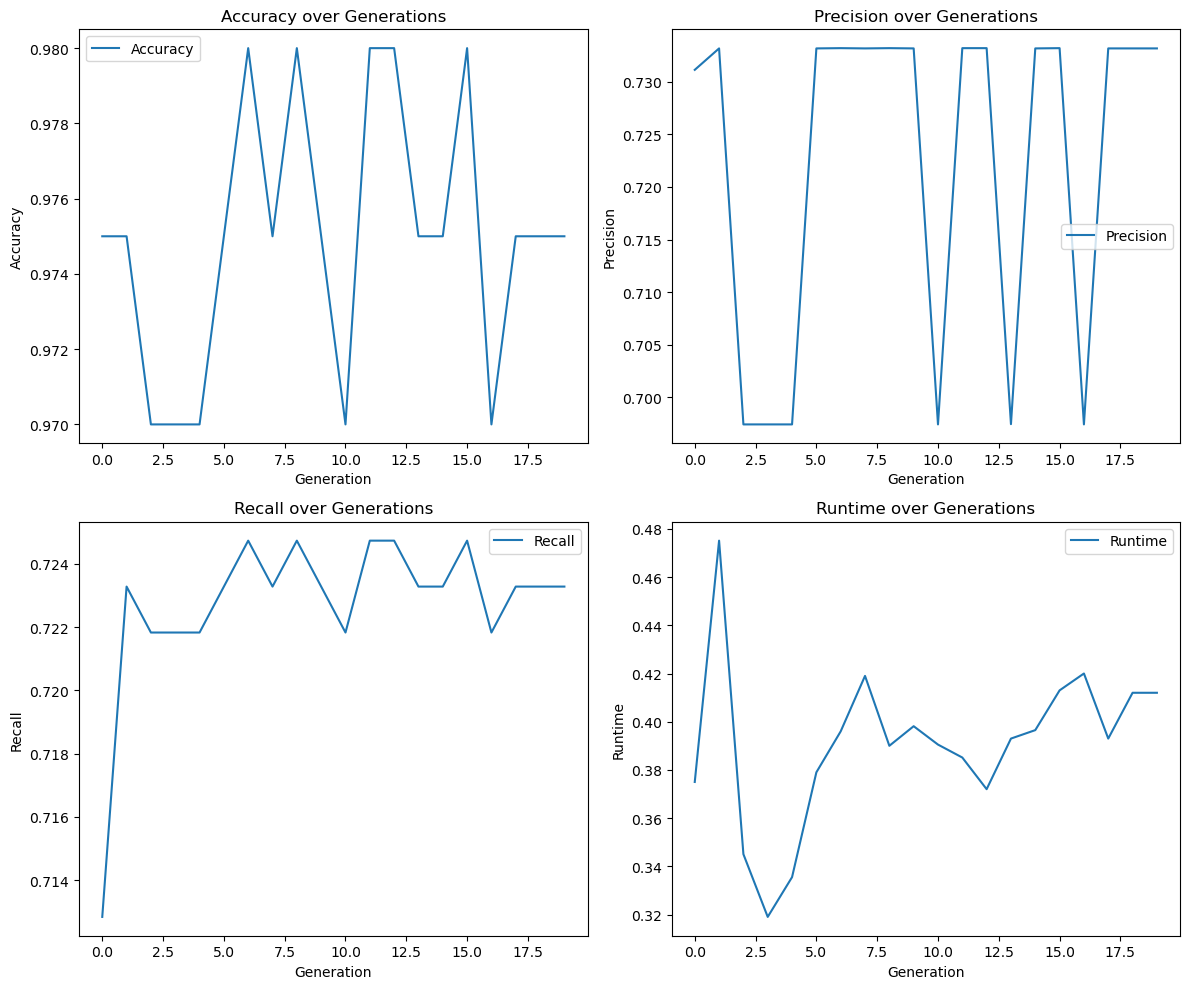

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9757500000000002
Overall Precision: 0.7206684337206983
Total Runtime: 8.673043727874756 seconds
Total Memory Usage: 3785.0 MB
Total Computational Cost: 11573.375


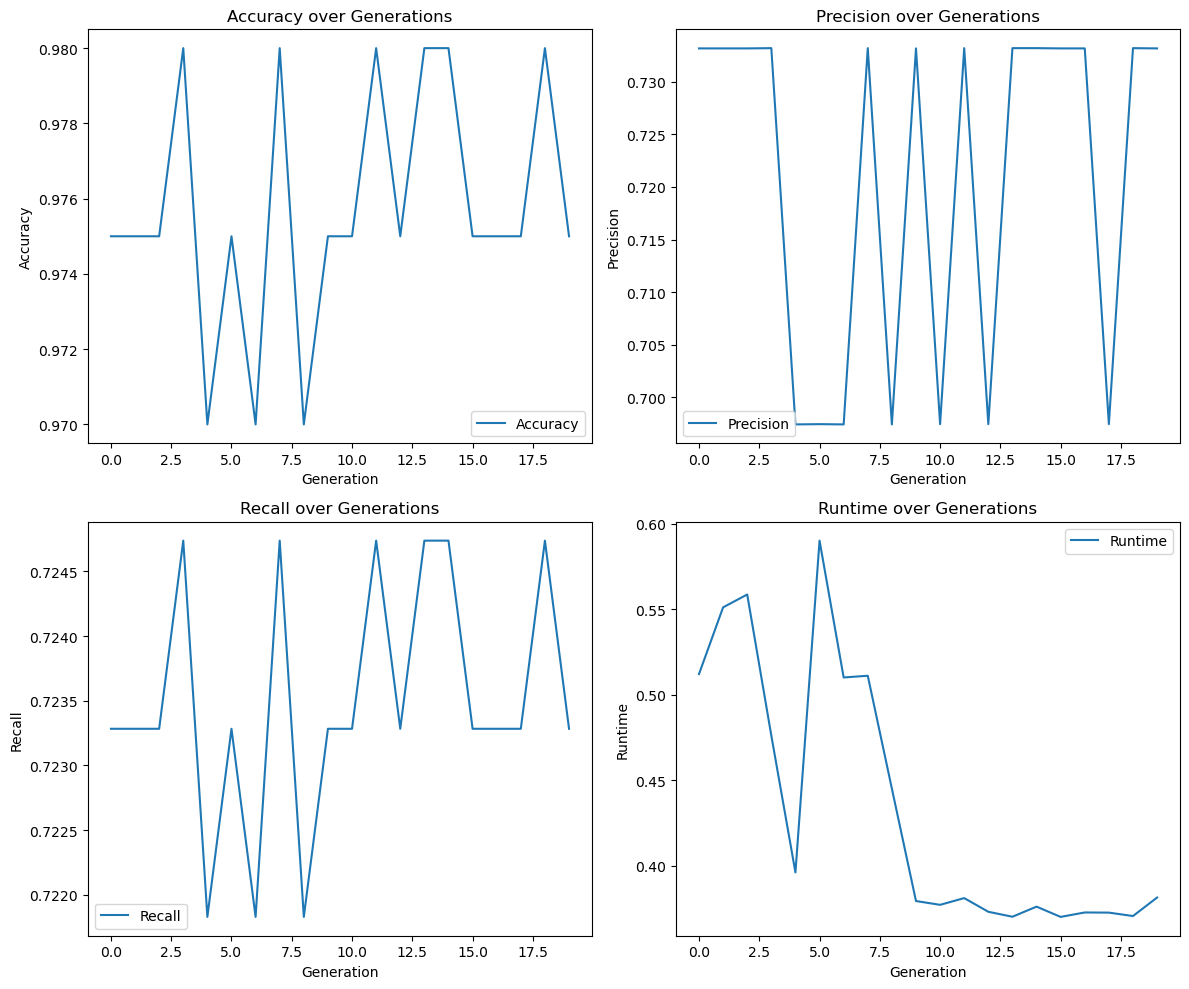


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 35.71213912963867 seconds
Average Memory Usage: 3513.410590277778 MB
Average Computational Cost: 11554.473958333332
Average Accuracy: 0.9732972222222221

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.461319671736824 seconds
Average Memory Usage: 3543.004340277778 MB
Average Computational Cost: 11557.904513888887
Average Accuracy: 0.9736722222222222

Iteration 10:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy    

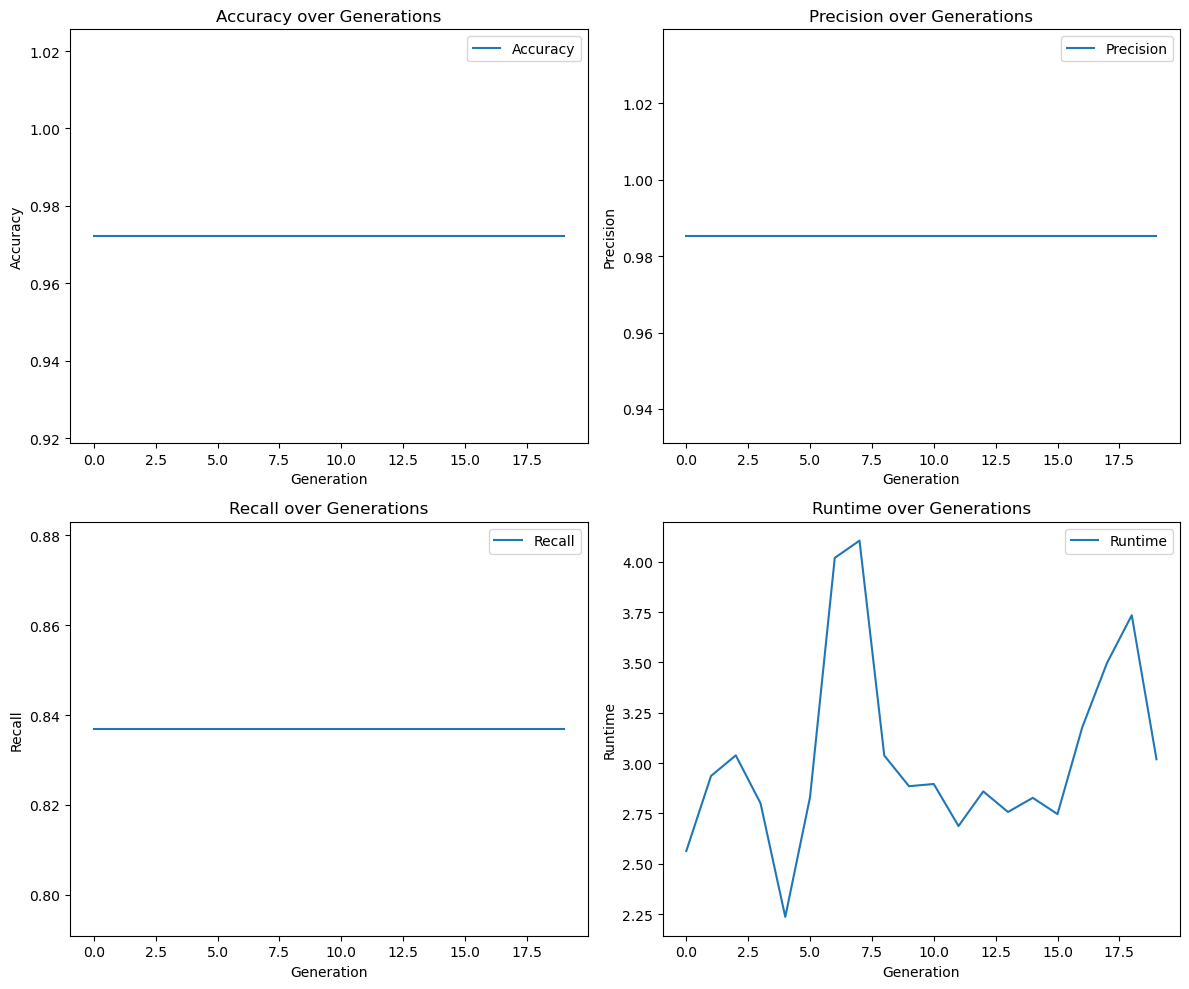

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

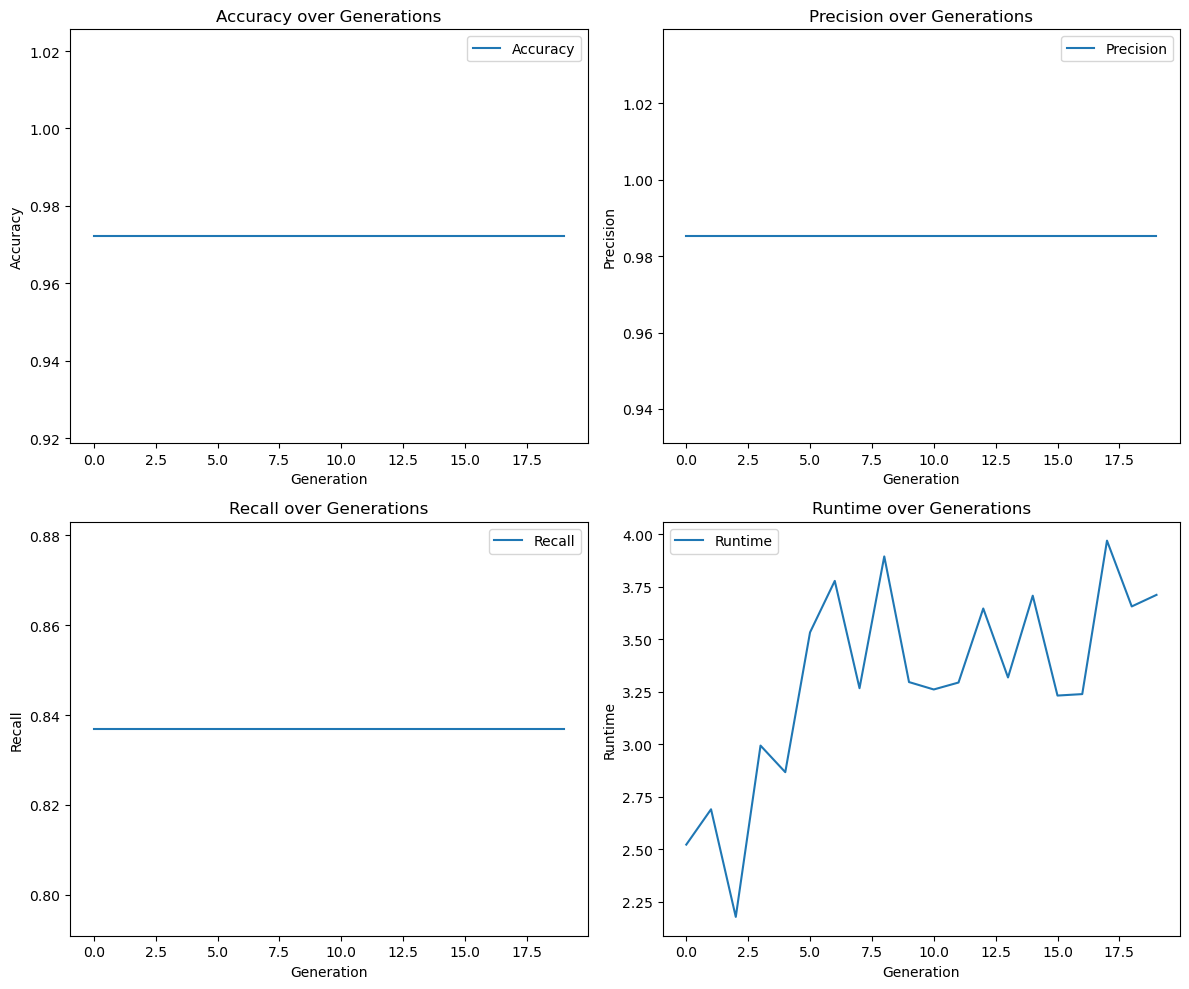

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9760000000000002
Overall Precision: 

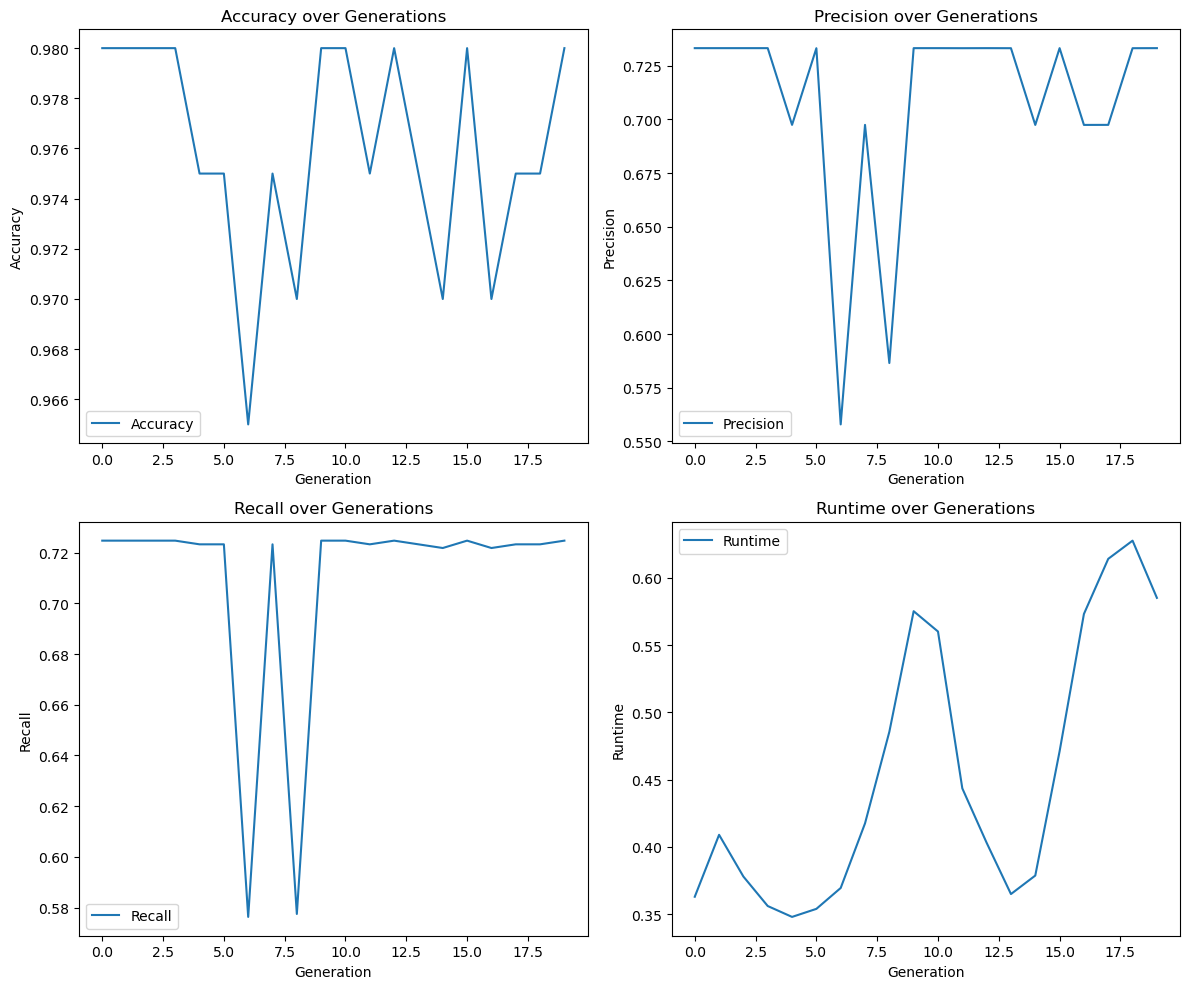

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overa

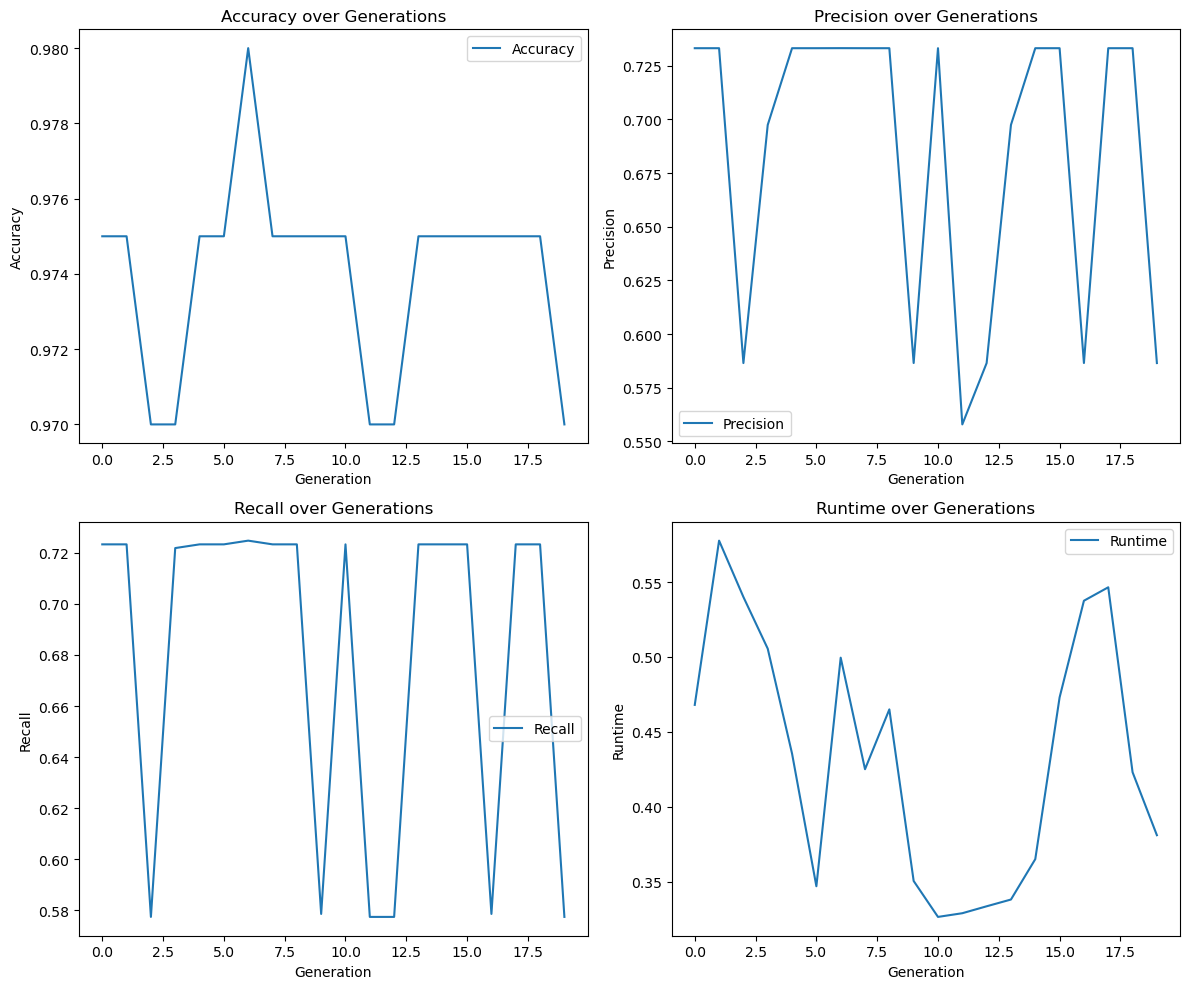


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 35.627320158481595 seconds
Average Memory Usage: 3507.288671875 MB
Average Computational Cost: 11555.028124999999
Average Accuracy: 0.9733749999999999

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.85133501291275 seconds
Average Memory Usage: 3541.7380859375 MB
Average Computational Cost: 11557.046874999998
Average Accuracy: 0.9736125

Iteration 11:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                  

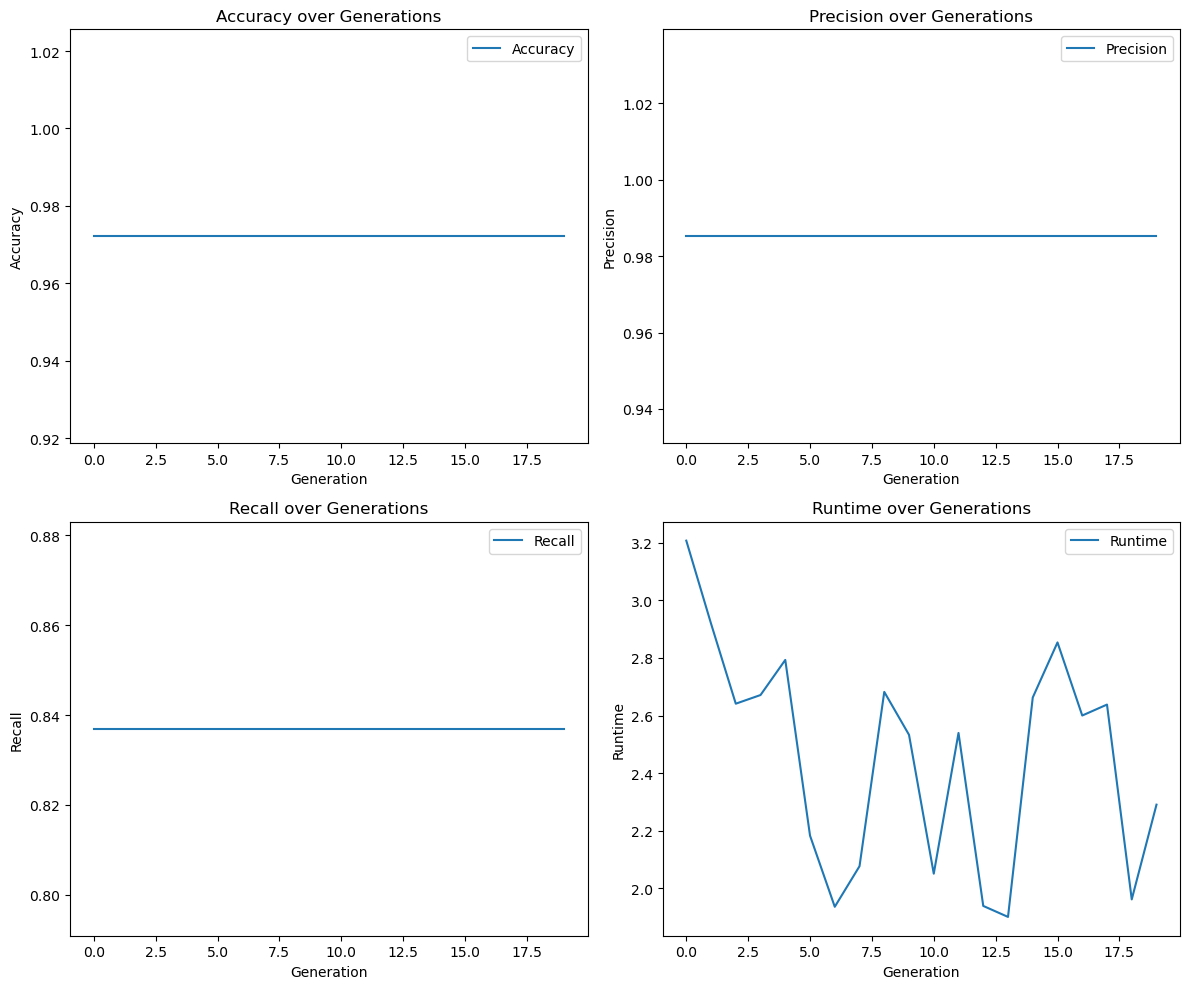

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

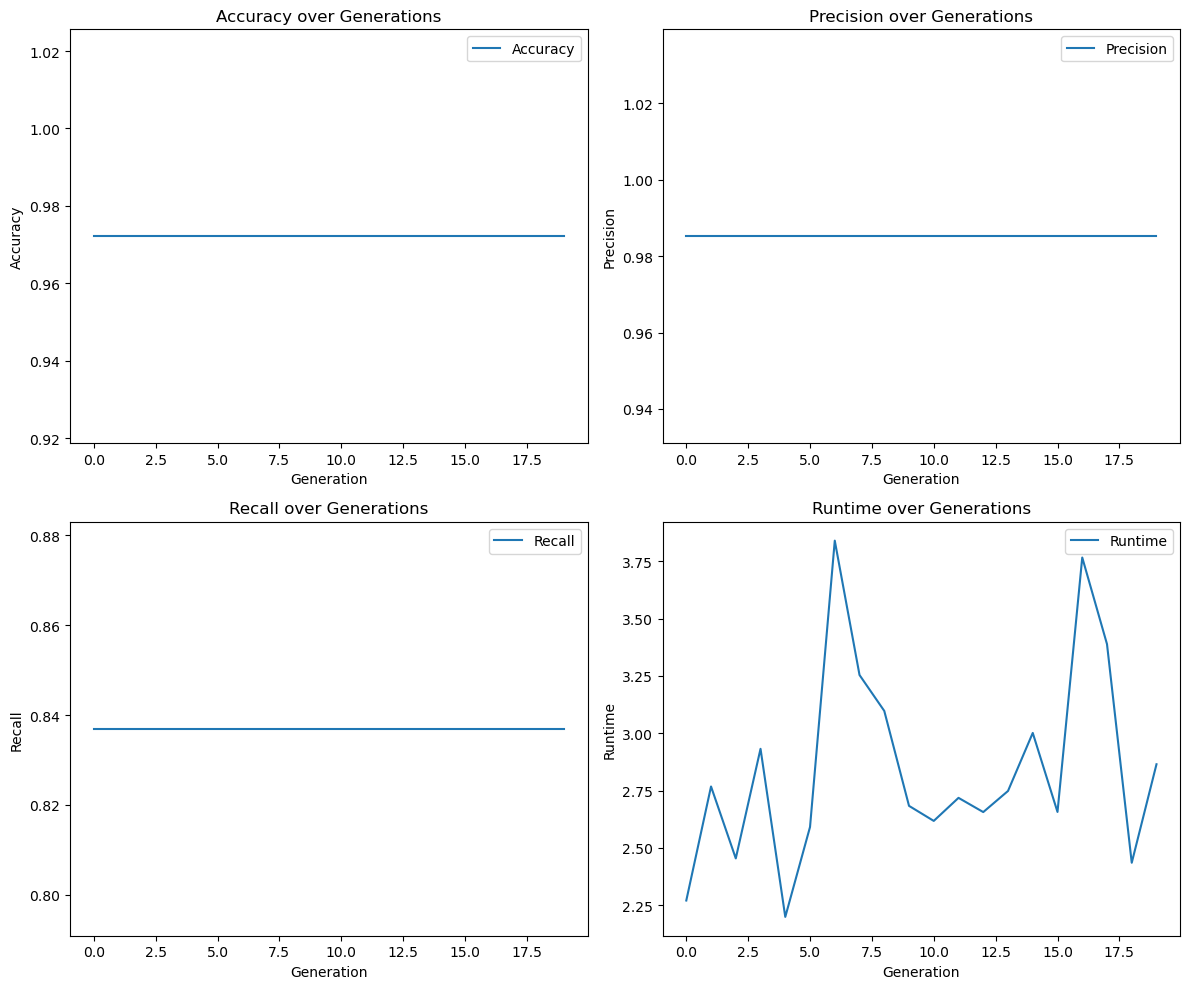

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9755000000000003
Overall Precision: 0.7187796421394397
Total Runtime: 8.000959396362305 seconds
Total Memory Usage: 3229.21875 MB
Total Computational Cost: 11540.125


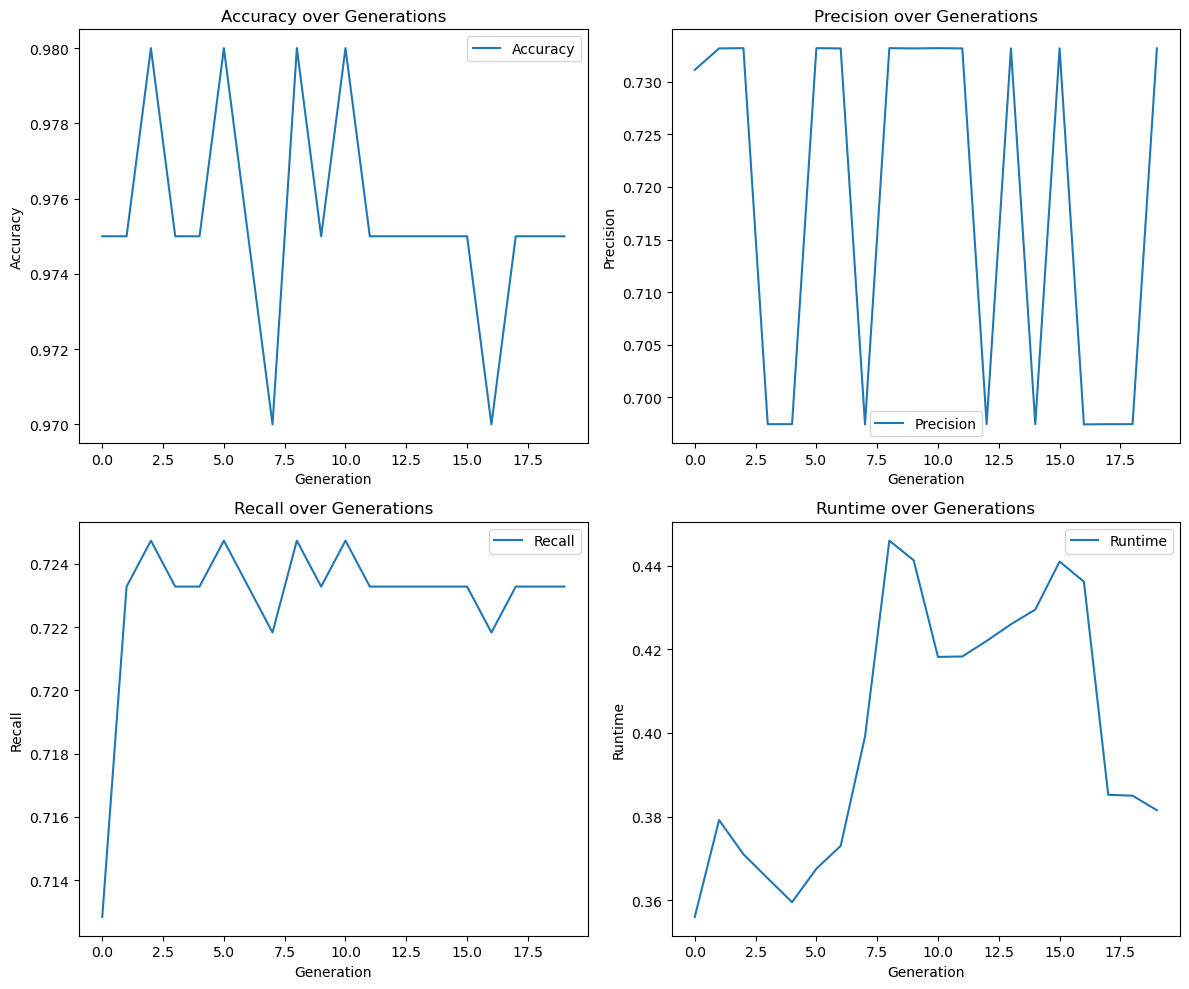

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.975
Overall Precision: 0.70117046692408

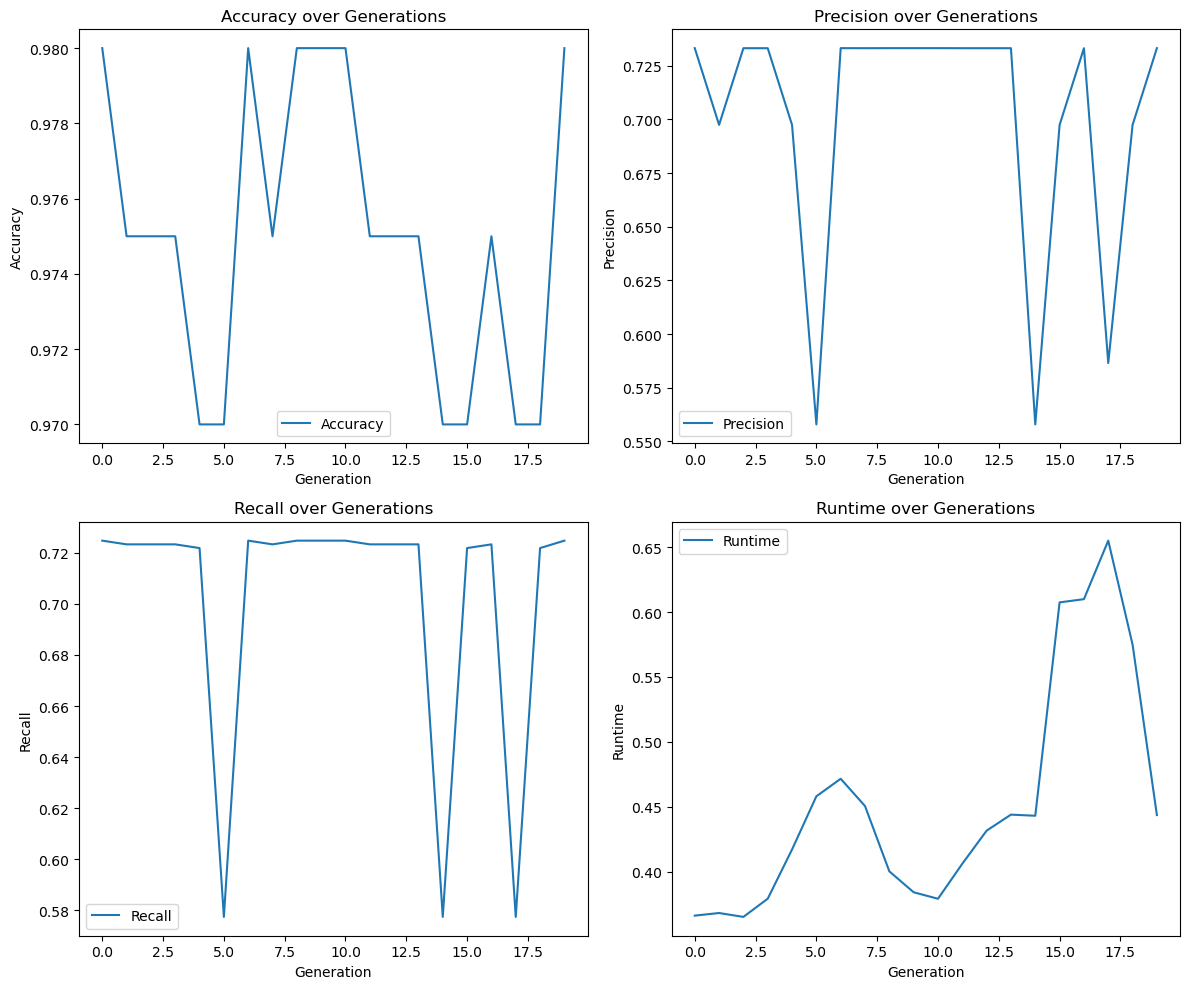


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.98305442116477 seconds
Average Memory Usage: 3505.93359375 MB
Average Computational Cost: 11553.86221590909
Average Accuracy: 0.9734159090909089

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.77399908412587 seconds
Average Memory Usage: 3545.860440340909 MB
Average Computational Cost: 11557.640624999998
Average Accuracy: 0.9736090909090909

Iteration 12:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy          

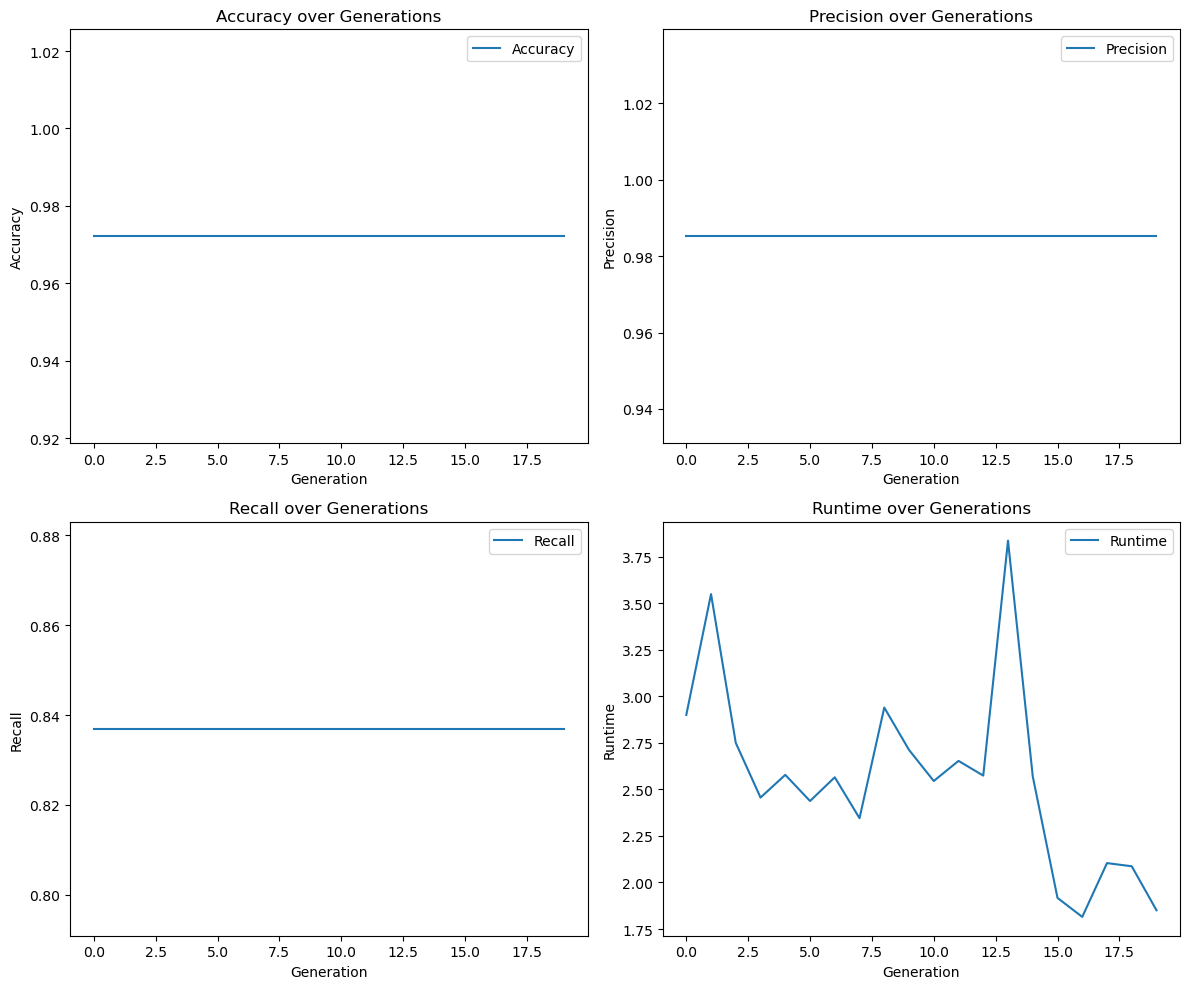

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

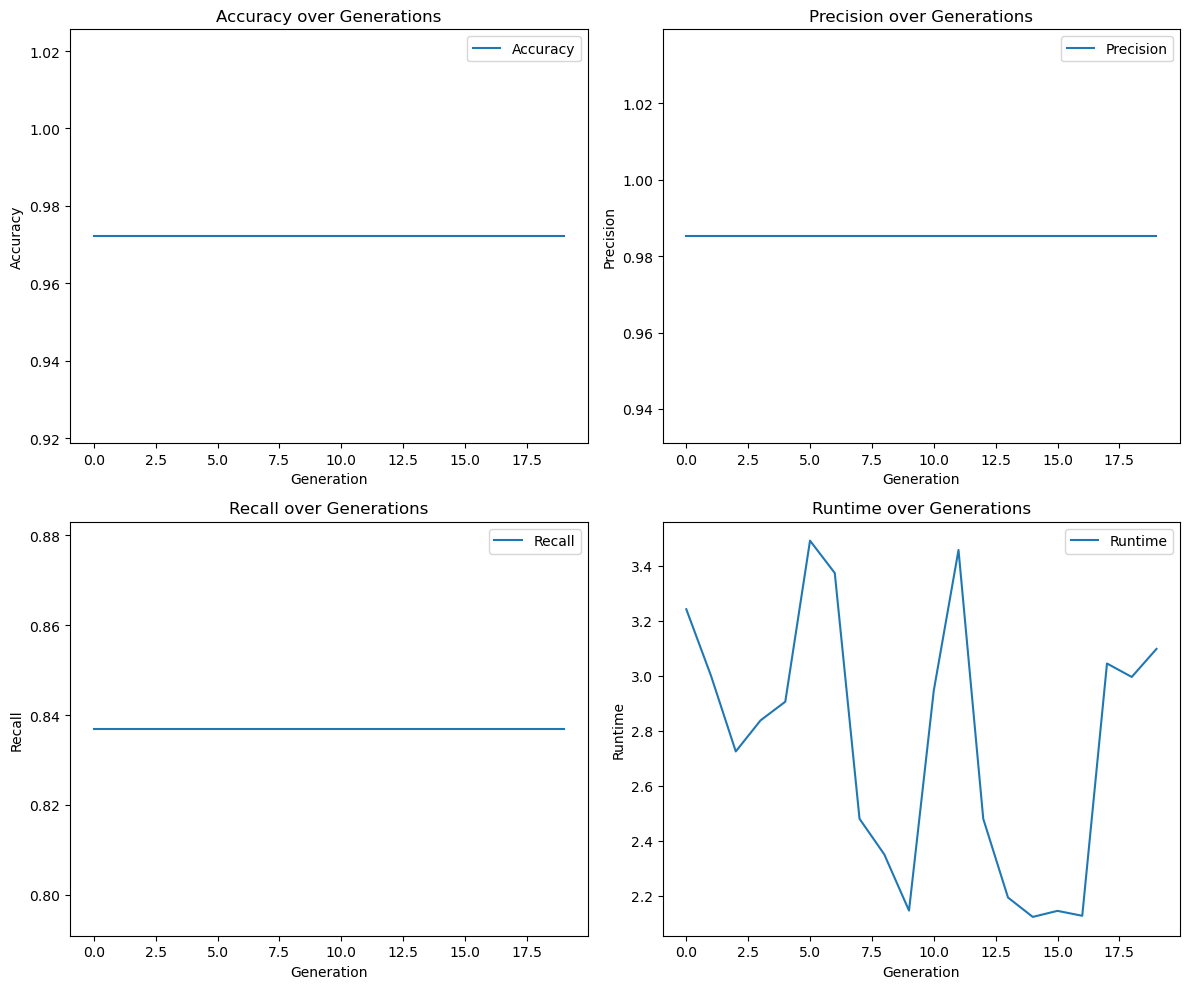

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.96       200
   macro avg       0.56      0.58      0.57       200
weighted avg       0.97      0.96      0.97       200


Overall Metrics Without Transfer Learning:
Ov

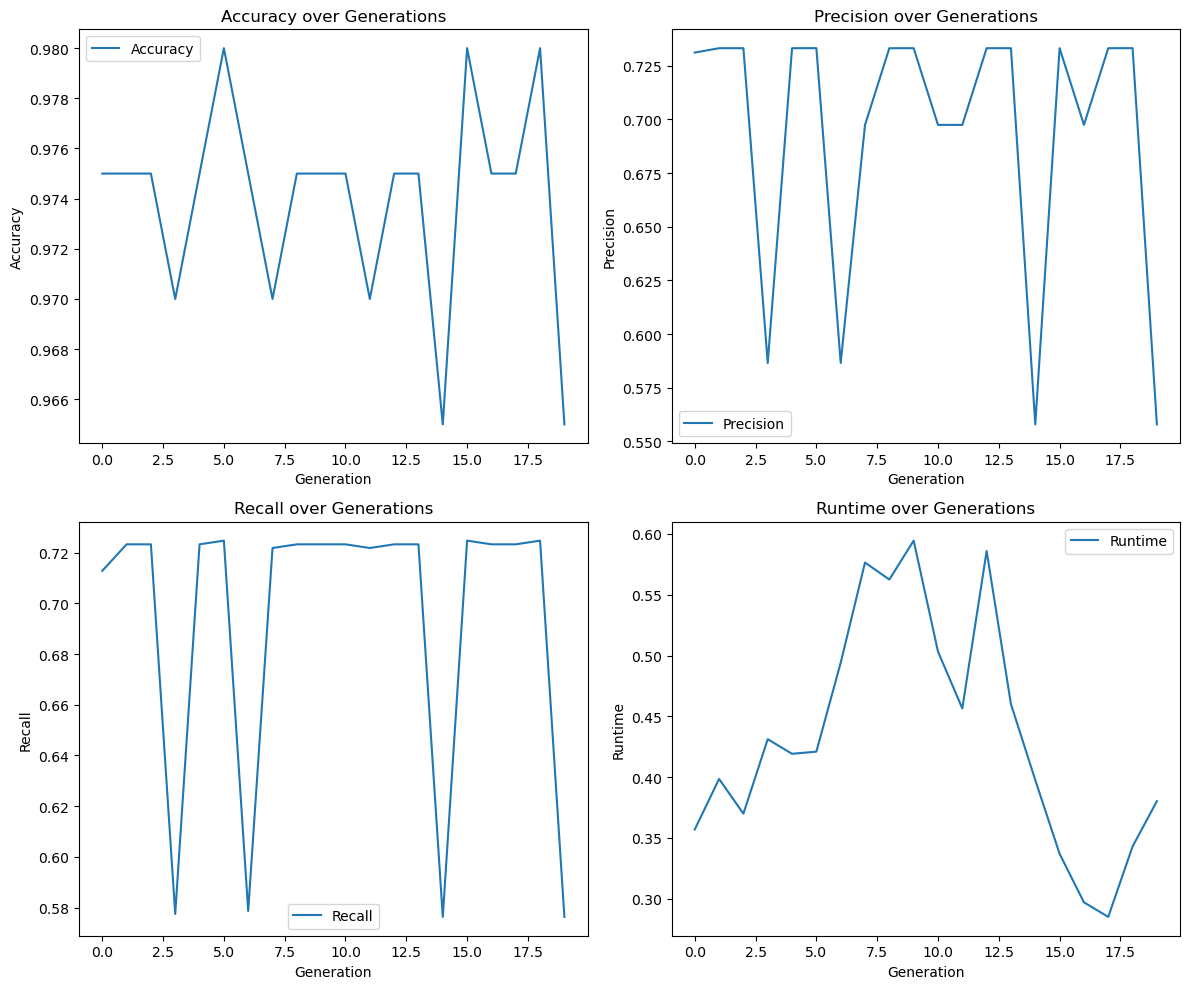

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9735000000000001
Overall Precision: 0.7

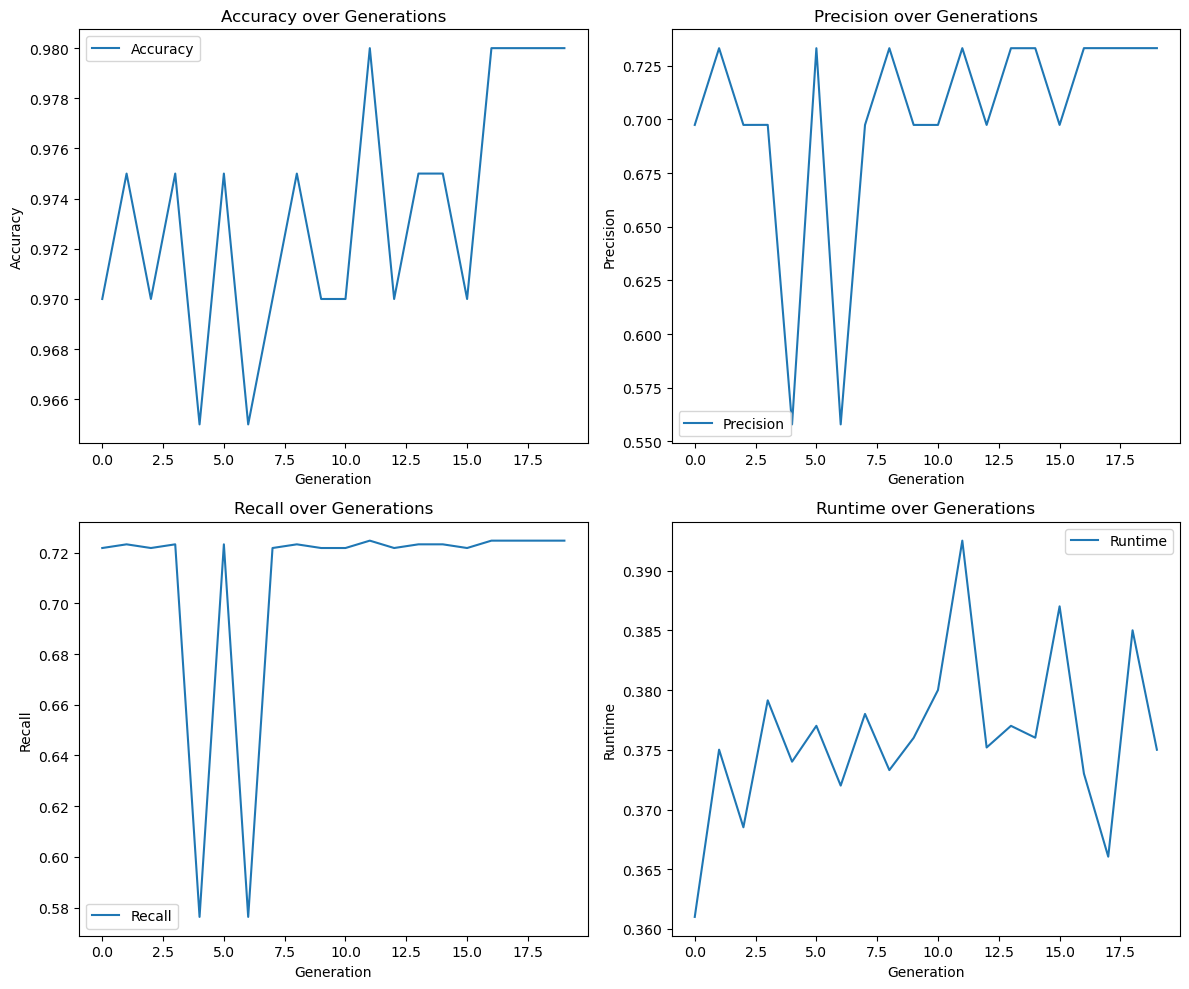


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.5617381532987 seconds
Average Memory Usage: 3517.0379231770835 MB
Average Computational Cost: 11553.979166666664
Average Accuracy: 0.9733875

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.571468691031136 seconds
Average Memory Usage: 3539.1953125 MB
Average Computational Cost: 11557.343749999998
Average Accuracy: 0.9735437499999998

Iteration 13:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                  

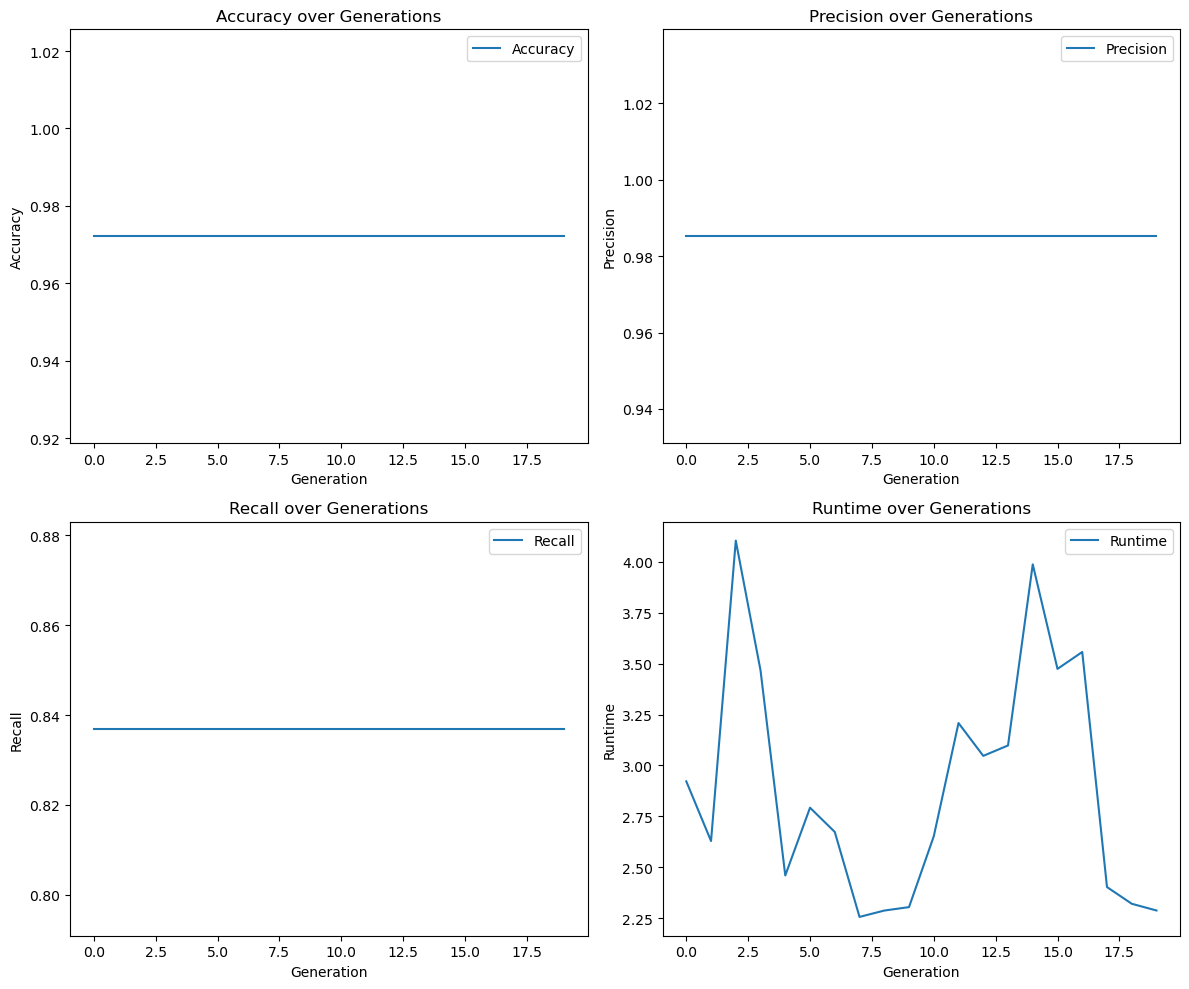

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

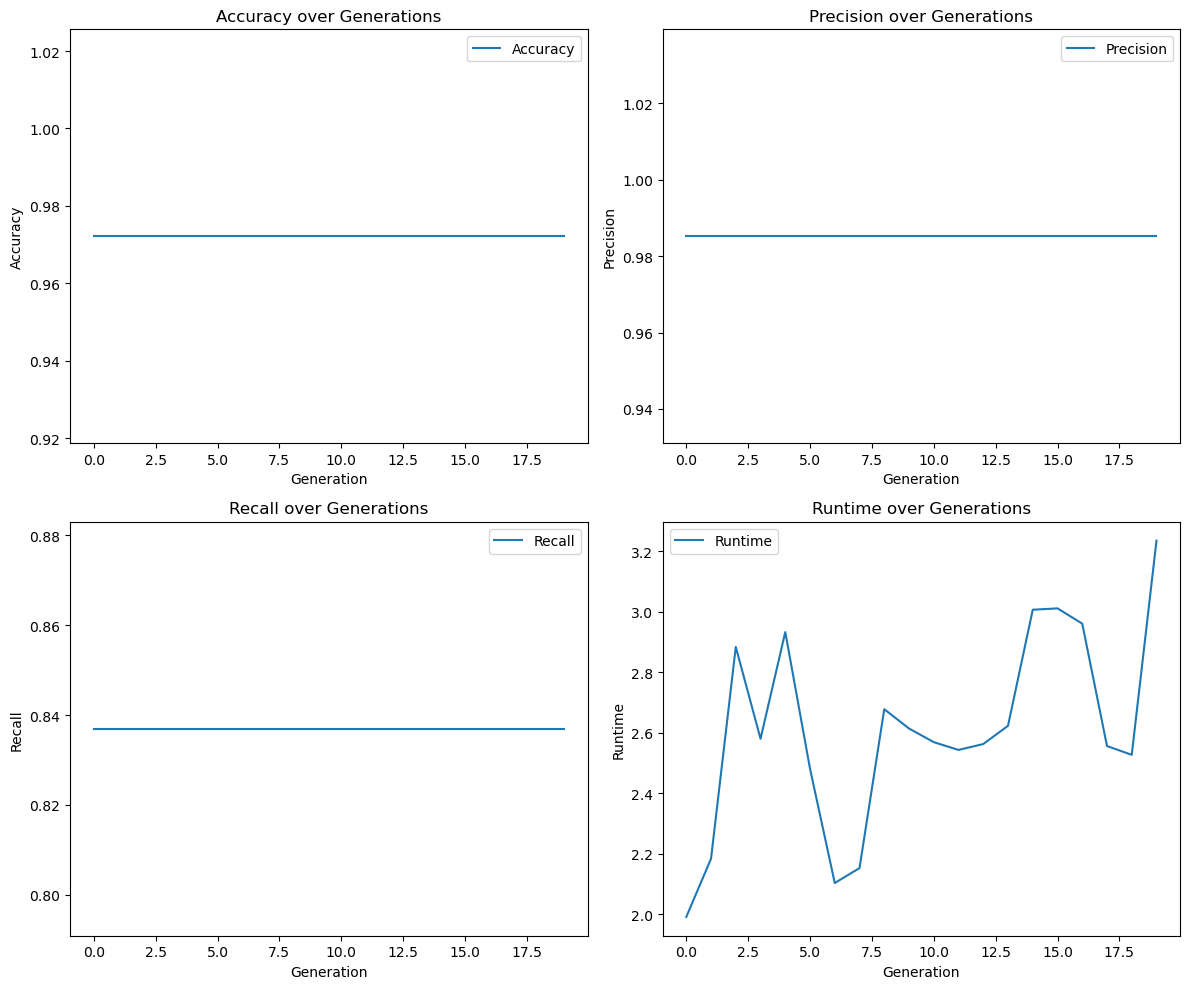

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9760000000000002
Overall Precision: 0.7186954269934049
Total Runtime: 8.078579425811768 seconds
Total Memory Usage: 3645.26953125 MB
Total Computational Cost: 11580.5


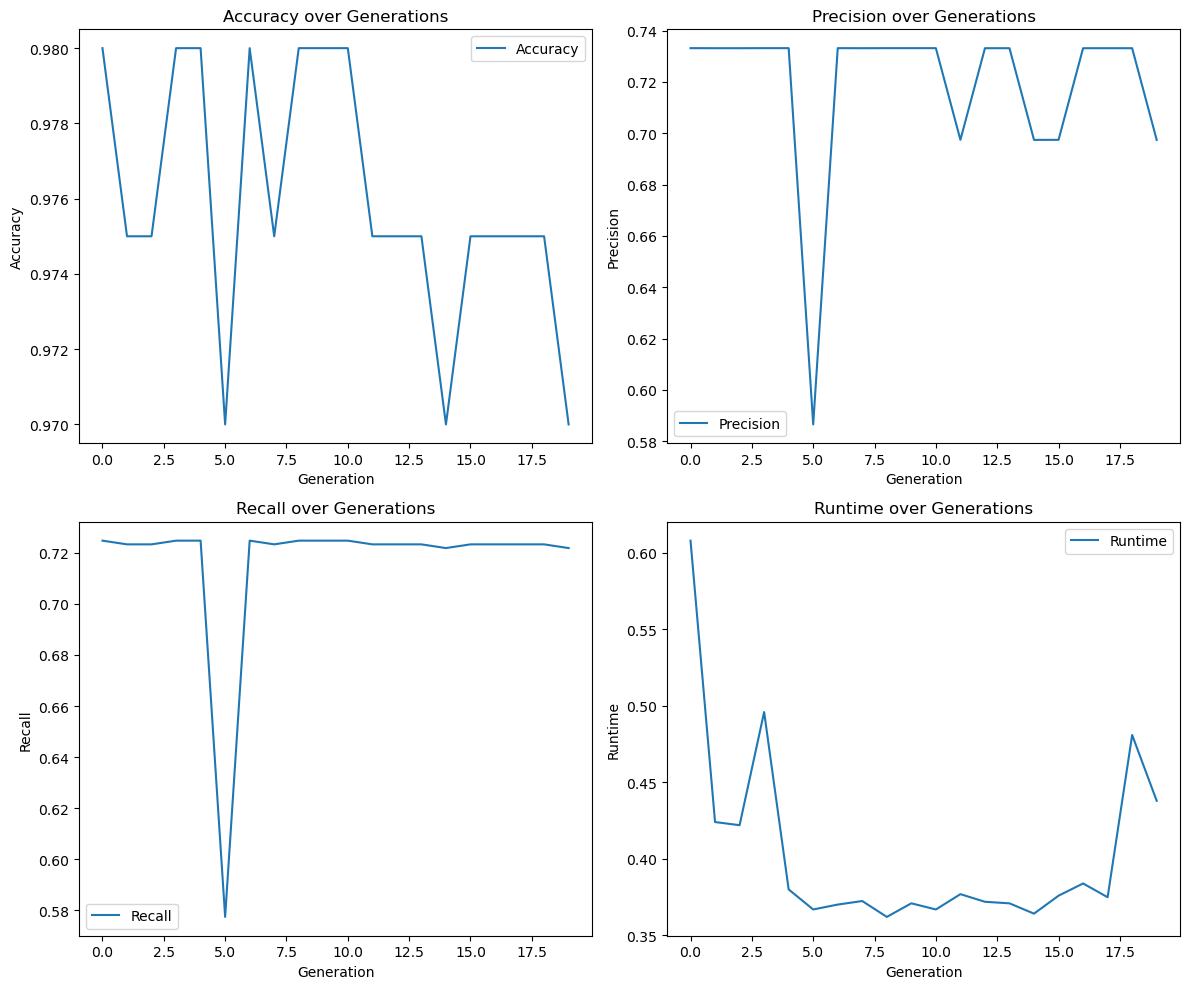

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.976
Overall Precision: 0.71136398818767

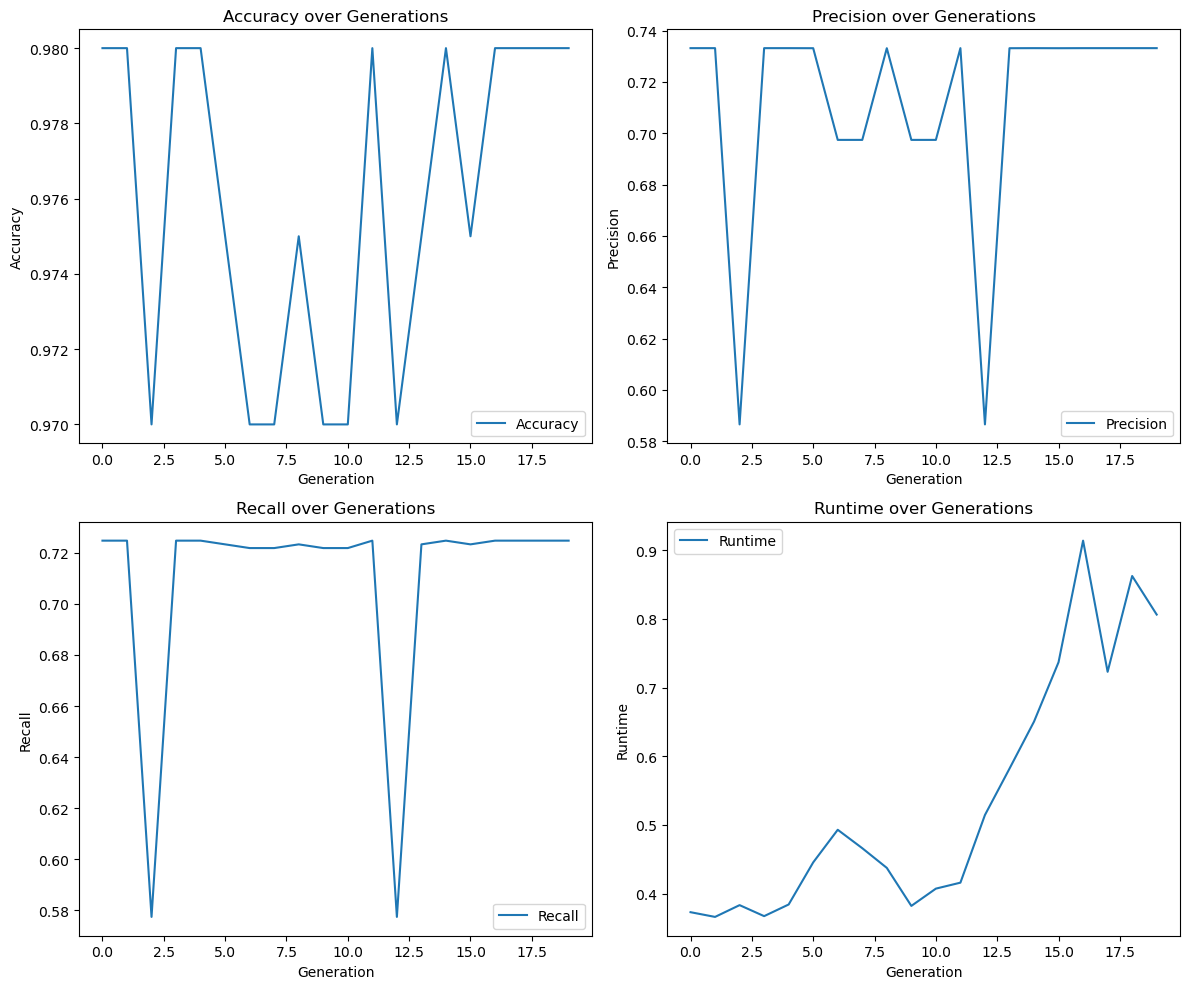


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.44199328239147 seconds
Average Memory Usage: 3519.7521033653848 MB
Average Computational Cost: 11554.294615384611
Average Accuracy: 0.9734403846153845

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.408613122426544 seconds
Average Memory Usage: 3547.3302283653848 MB
Average Computational Cost: 11556.453124999998
Average Accuracy: 0.9735846153846152

Iteration 14:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy  

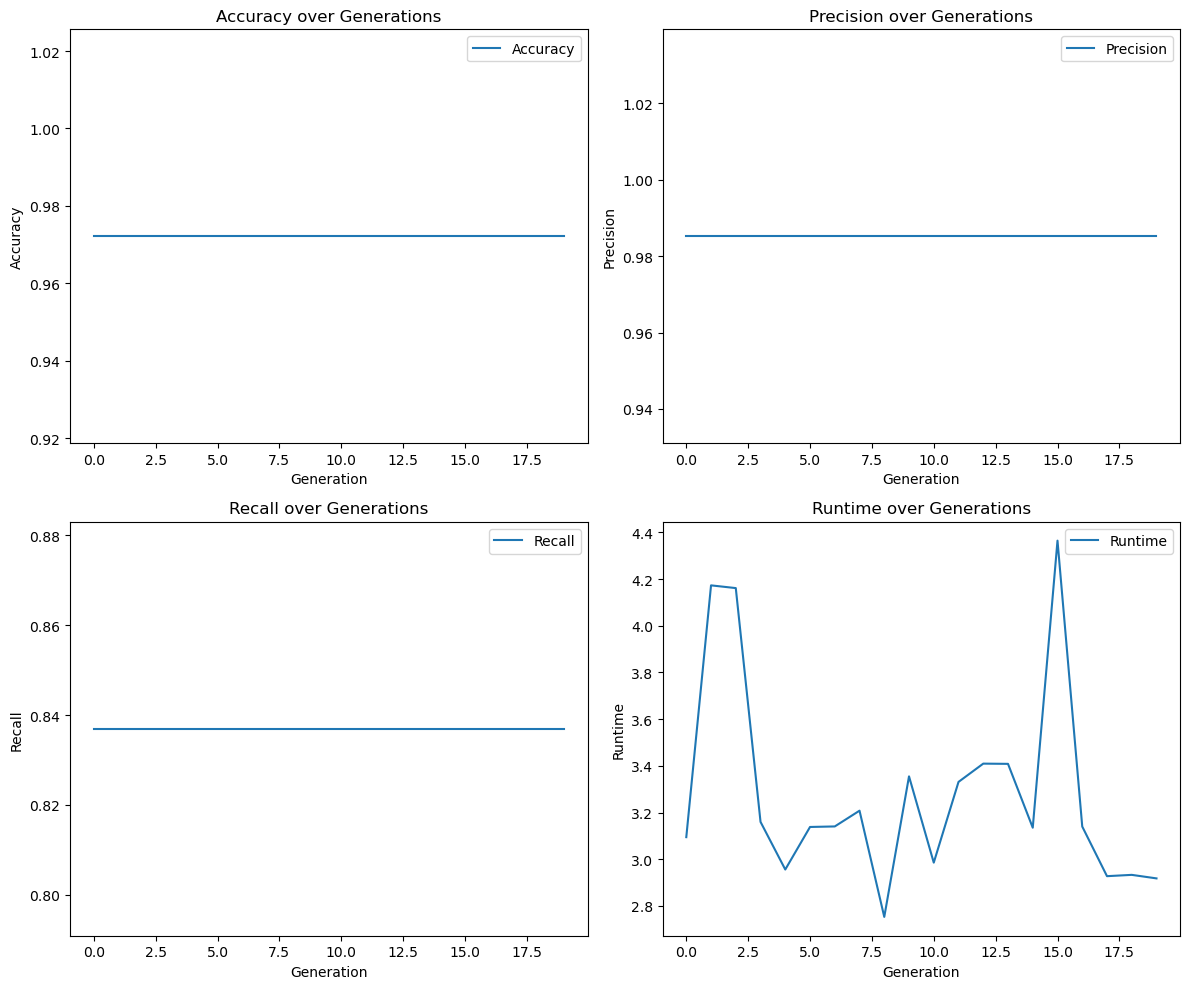

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

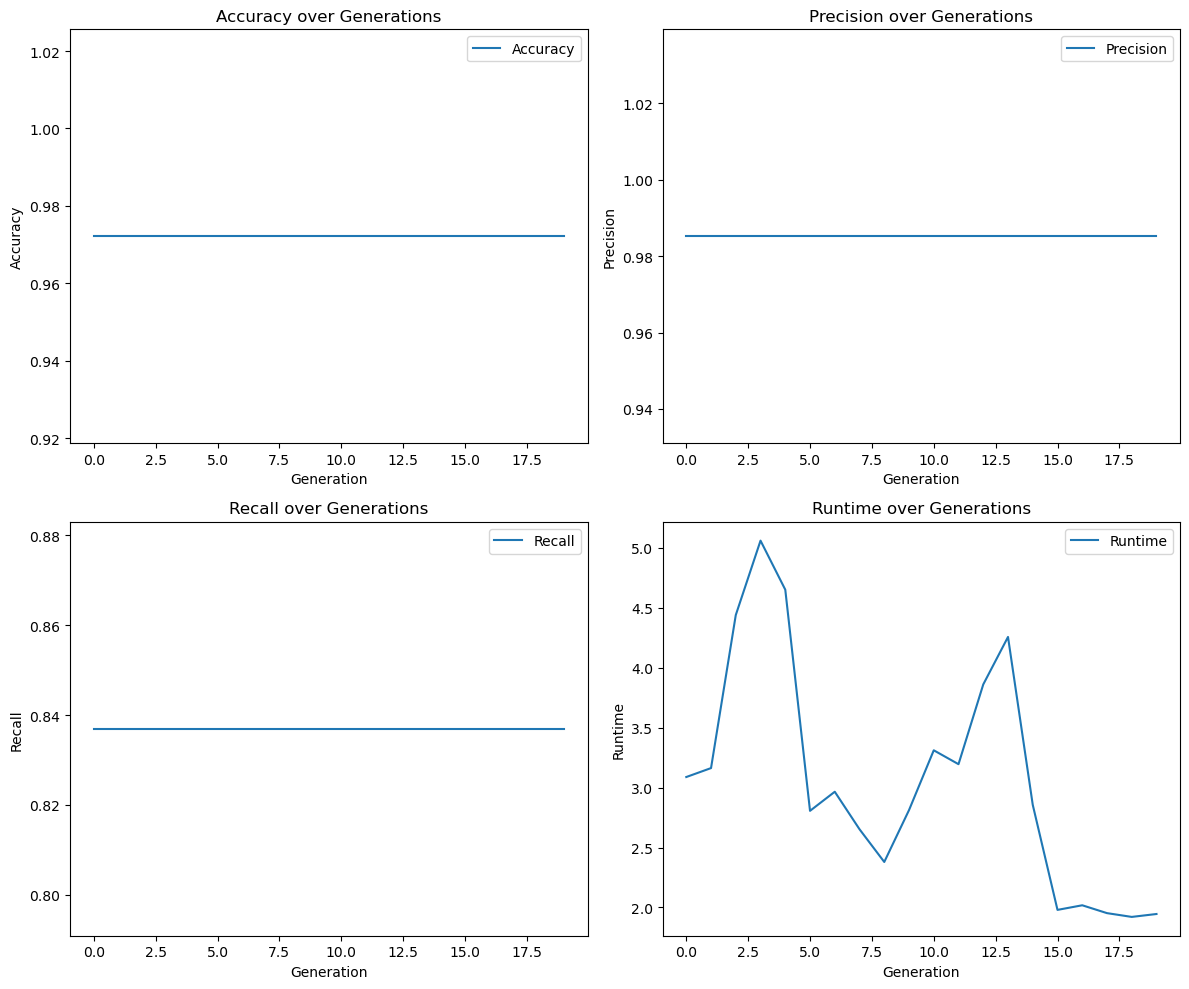

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9755000000000003
Overall Precision: 0.7169072356645212
Total Runtime: 6.884945869445801 seconds
Total Memory Usage: 3515.00390625 MB
Total Computational Cost: 11563.875


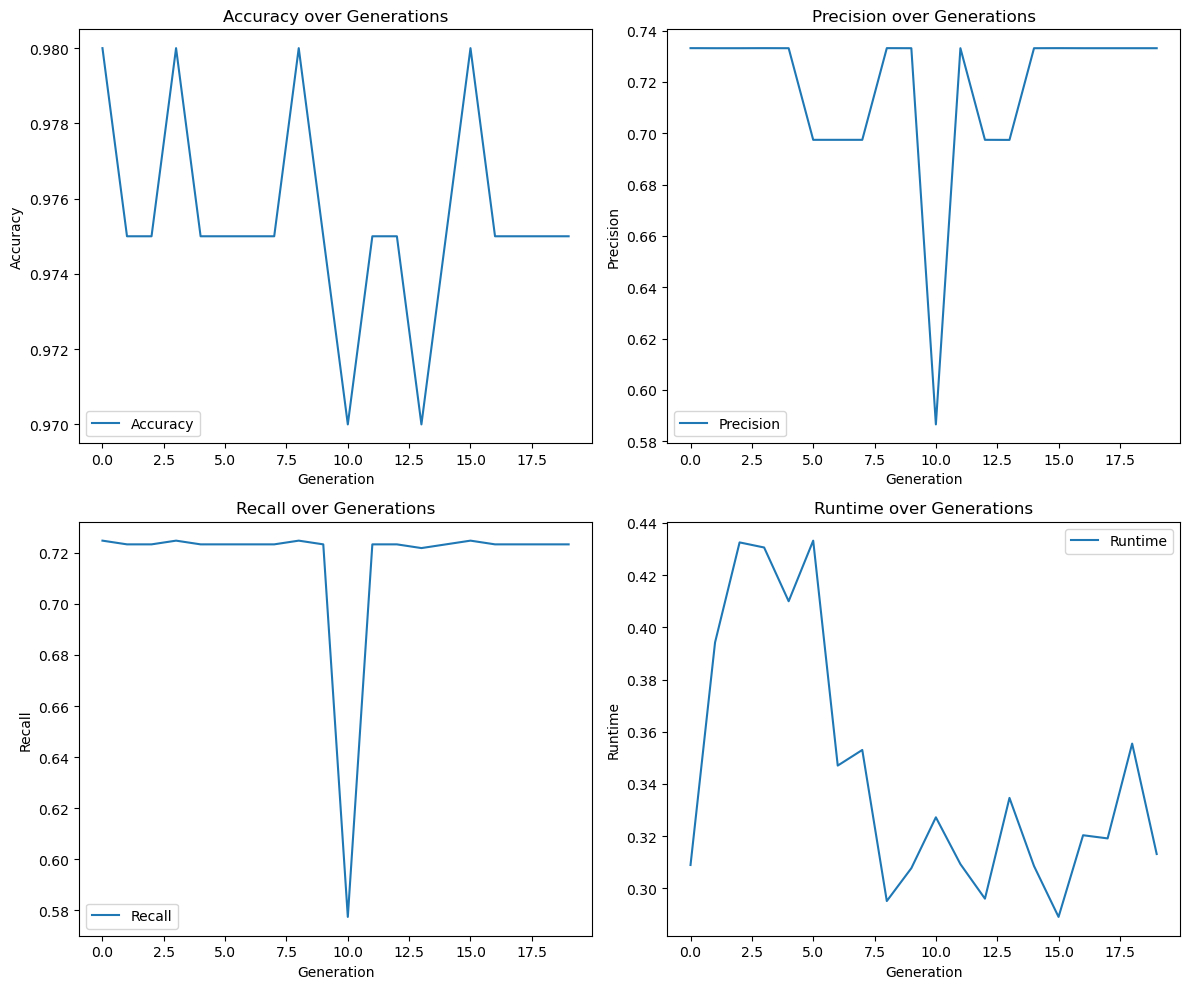

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall  f1-score   support

           0       0.95      0.90

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.98       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.98      0.98       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9752500000000002
Overall Precision: 0.7

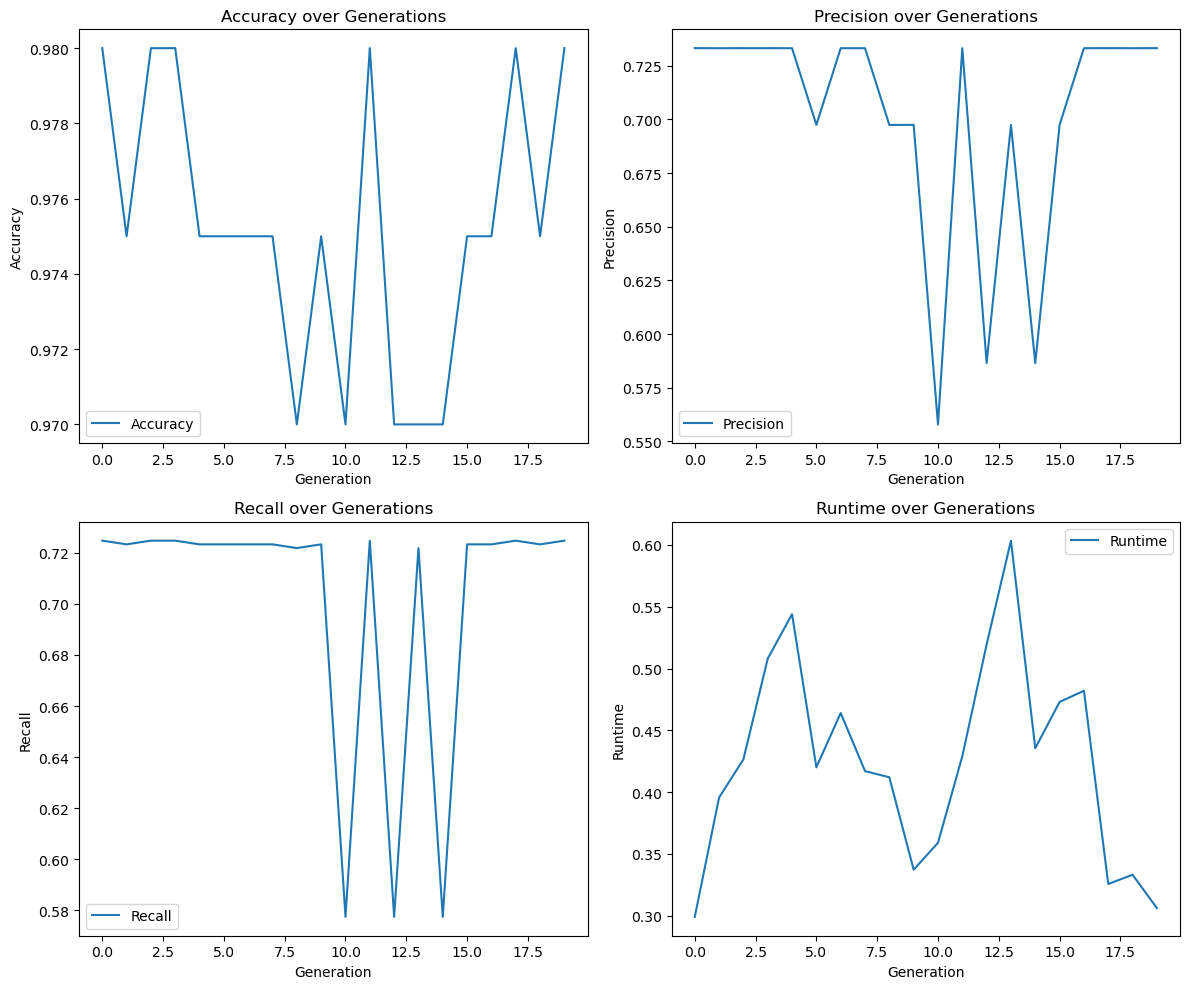


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.57391547305243 seconds
Average Memory Usage: 3511.853934151786 MB
Average Computational Cost: 11554.279151785711
Average Accuracy: 0.9734678571428571

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.51515767404011 seconds
Average Memory Usage: 3545.4070870535716 MB
Average Computational Cost: 11555.011160714284
Average Accuracy: 0.9735928571428569

Iteration 15:
Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy    

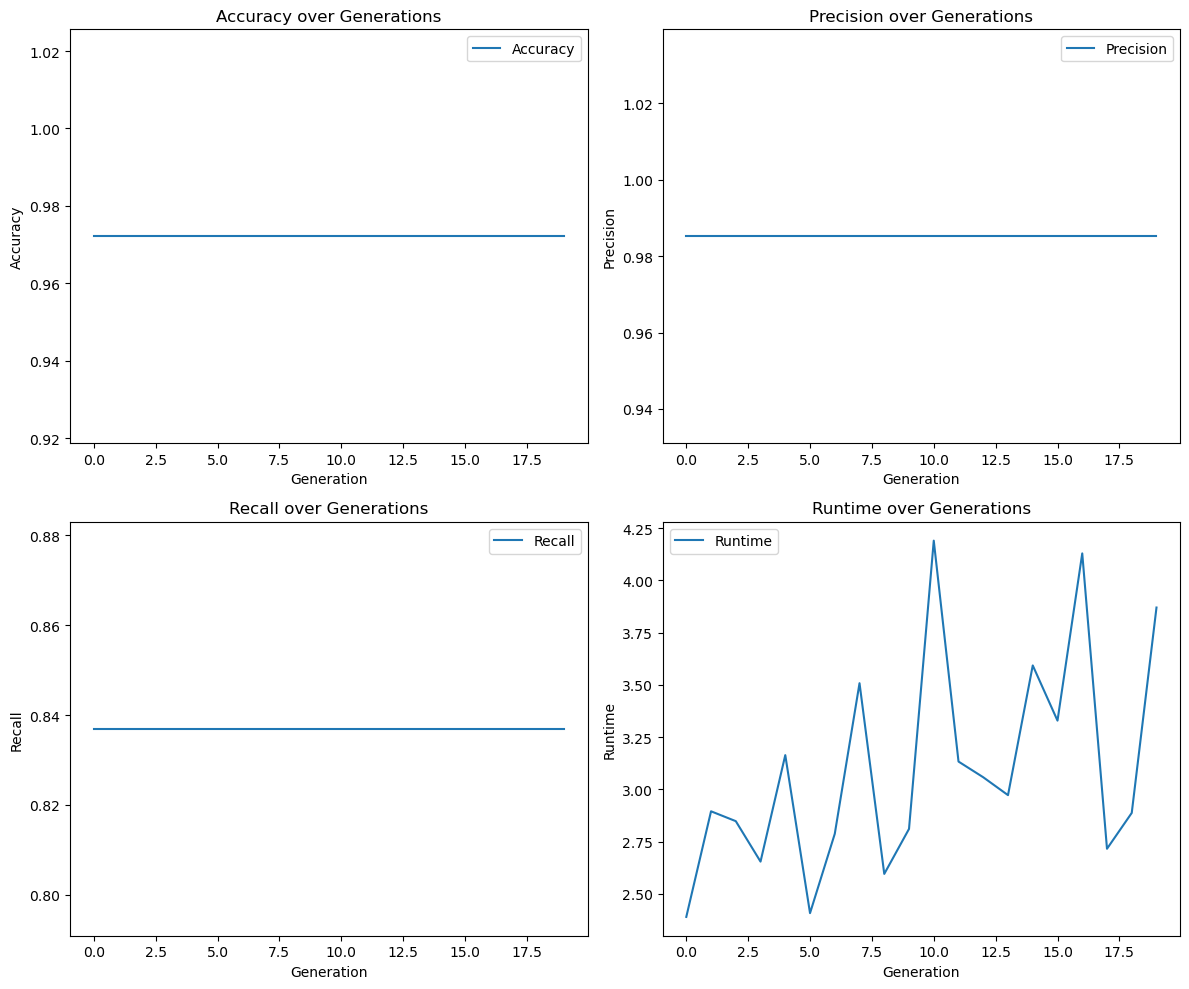

Generation 0:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Generation 2:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.9

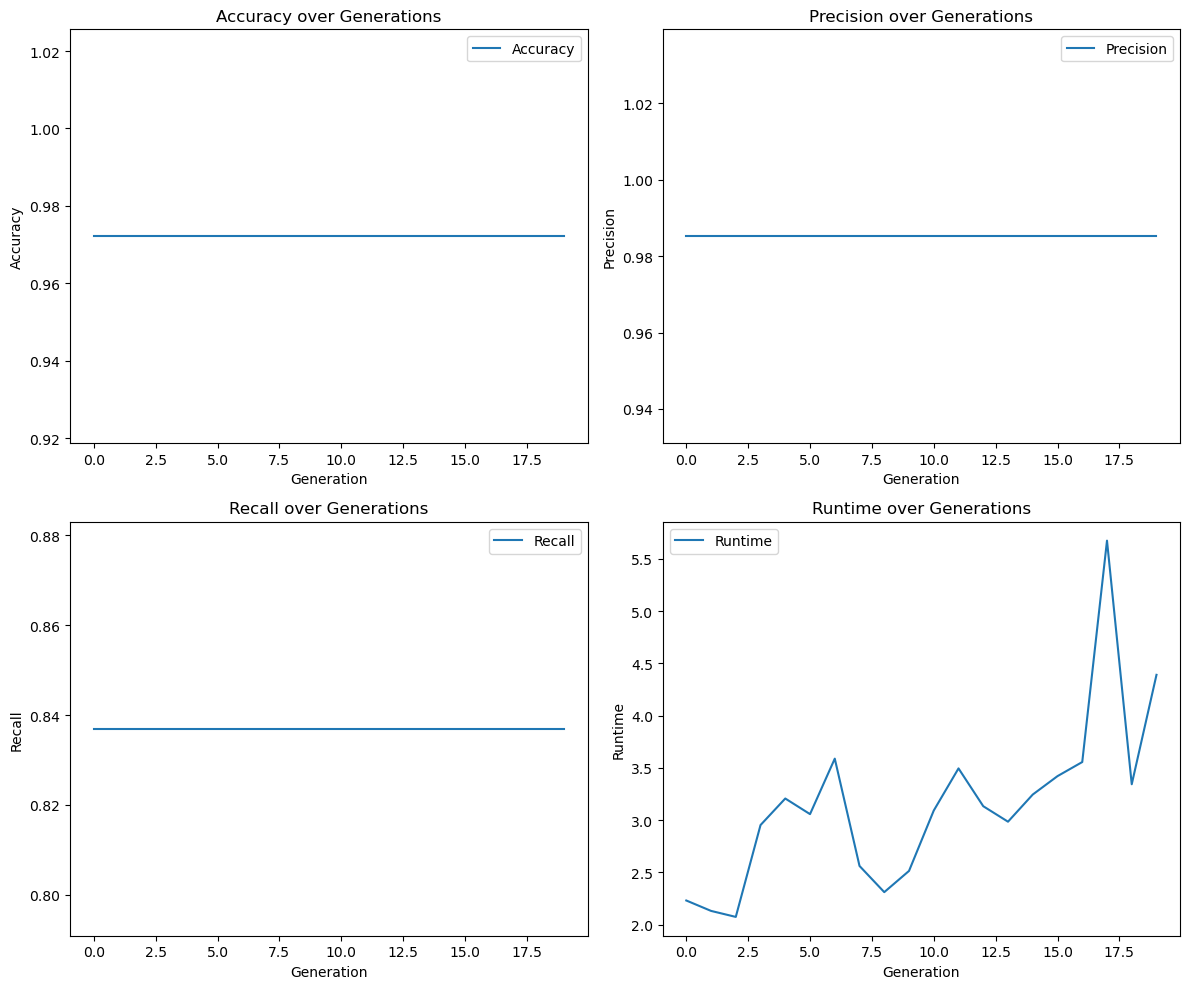

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall 

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       1.00      1.00      1.00         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics Without Transfer Learning:
Overall Accuracy: 0.9750000000000002
Overall Precision: 

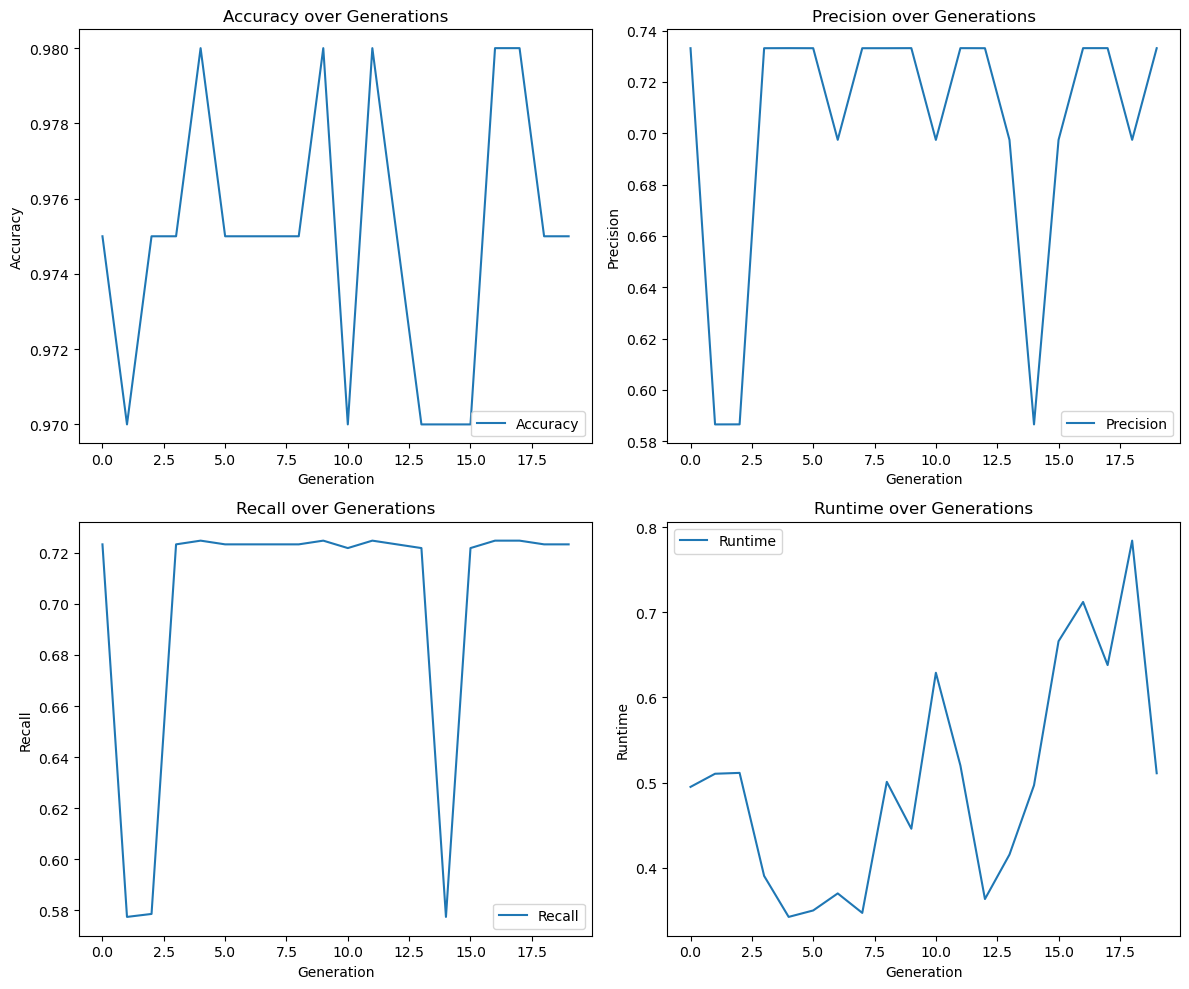

Generation 0:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.97      0.97      0.97       200

Generation 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.98      0.98       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 2:
              precision    recall 

Generation 18:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200

Generation 19:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           2       0.86      1.00      0.92         6
           3       0.98      0.99      0.99       172
           4       0.00      0.00      0.00         1

    accuracy                           0.97       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.97      0.97      0.97       200


Overall Metrics With Transfer Learning:
Overall Accuracy: 0.9742500000000002
Overall Precision: 0.6

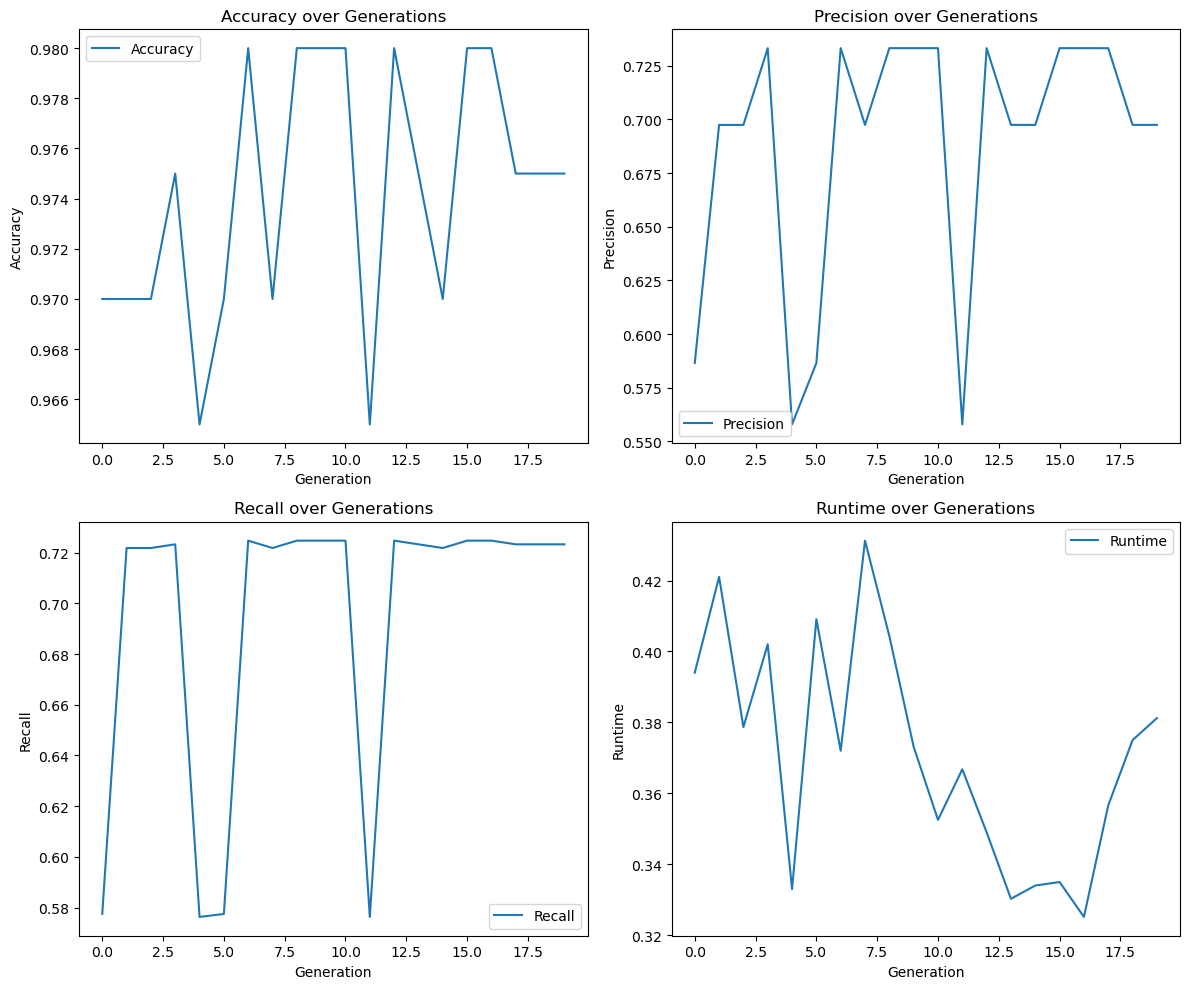


Average Metrics Without Transfer Learning (Iteration):
Average Runtime: 34.6670464515686 seconds
Average Memory Usage: 3510.9713541666665 MB
Average Computational Cost: 11554.582416666664
Average Accuracy: 0.973475

Average Metrics With Transfer Learning (Iteration):
Average Runtime: 33.627804327011106 seconds
Average Memory Usage: 3548.7419270833334 MB
Average Computational Cost: 11555.661458333332
Average Accuracy: 0.9735666666666665

Final Average Metrics Without Transfer Learning:
Average Runtime: 34.6670464515686 seconds
Average Memory Usage: 3510.9713541666665 MB
Average Computational Cost: 11554.582416666664
Average Accuracy: 0.973475

Final Average Metrics With Transfer Learning:
Average Runtime: 33.627804327011106 seconds
Average Memory Usage: 3548.7419270833334 MB
Average Computational Cost: 11555.661458333332
Average Accuracy: 0.9735666666666665


In [14]:
# Read the datasets
source_X, source_y = read_source_data('diabetes.csv')
target_X1, target_y1 = read_target_data1('diabetes_prediction_dataset.csv')
target_X2, target_y2 = read_target_data2('Dataset of Diabetes .csv')

# Split target datasets into train and test sets
target_X1_train, target_X1_test, target_y1_train, target_y1_test = train_test_split(target_X1, target_y1, test_size=0.2, random_state=42)
target_X2_train, target_X2_test, target_y2_train, target_y2_test = train_test_split(target_X2, target_y2, test_size=0.2, random_state=42)

# Grammatical Evolution parameters
max_depth = 5
population_size = 25
tournament_size = 5
mutation_rate = 0.2
crossover_rate = 0.8
generations = 20

# Define grammar for tree representation
grammar = {
    '<start>': ['<expr>'],
    '<expr>': ['DecisionTreeClassifier(max_depth=<depth>)'],
    '<depth>': ['1', '2', '3', '4', '5']
}

# Initialize variables for overall averages
total_metrics_without_tl = {'runtime': [], 'memory': [], 'computational_cost': [], 'accuracy': []}
total_metrics_with_tl = {'runtime': [], 'memory': [], 'computational_cost': [], 'accuracy': []}

# Perform the experiments and compute averages
for i in range(15):
    print(f"\nIteration {i+1}:")

    # Grammatical Evolution without Transfer Learning on target dataset 1
    best_individual, metrics, total_runtime, total_memory, total_computational_cost = grammatical_evolution_without_transfer_learning(
        target_X1_train, target_y1_train, target_X1_test, target_y1_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations
    )
    total_metrics_without_tl['runtime'].append(total_runtime)
    total_metrics_without_tl['memory'].append(total_memory)
    total_metrics_without_tl['computational_cost'].append(total_computational_cost)
    total_metrics_without_tl['accuracy'].append(np.mean(metrics['accuracy']))

    # Grammatical Evolution with Transfer Learning on target dataset 1
    best_individual, metrics, total_runtime, total_memory, total_computational_cost = grammatical_evolution_with_transfer_learning(
        source_X, source_y, target_X1_train, target_y1_train, target_X1_test, target_y1_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations
    )
    total_metrics_with_tl['runtime'].append(total_runtime)
    total_metrics_with_tl['memory'].append(total_memory)
    total_metrics_with_tl['computational_cost'].append(total_computational_cost)
    total_metrics_with_tl['accuracy'].append(np.mean(metrics['accuracy']))

    # Grammatical Evolution without Transfer Learning on target dataset 2
    best_individual, metrics, total_runtime, total_memory, total_computational_cost = grammatical_evolution_without_transfer_learning(
        target_X2_train, target_y2_train, target_X2_test, target_y2_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations
    )
    total_metrics_without_tl['runtime'].append(total_runtime)
    total_metrics_without_tl['memory'].append(total_memory)
    total_metrics_without_tl['computational_cost'].append(total_computational_cost)
    total_metrics_without_tl['accuracy'].append(np.mean(metrics['accuracy']))

    # Grammatical Evolution with Transfer Learning on target dataset 2
    best_individual, metrics, total_runtime, total_memory, total_computational_cost = grammatical_evolution_with_transfer_learning(
        source_X, source_y, target_X2_train, target_y2_train, target_X2_test, target_y2_test, grammar, max_depth, population_size, tournament_size, mutation_rate, crossover_rate, generations
    )
    total_metrics_with_tl['runtime'].append(total_runtime)
    total_metrics_with_tl['memory'].append(total_memory)
    total_metrics_with_tl['computational_cost'].append(total_computational_cost)
    total_metrics_with_tl['accuracy'].append(np.mean(metrics['accuracy']))

    # Calculate and print average metrics for each iteration
    average_metrics_without_tl = {key: np.mean(values) for key, values in total_metrics_without_tl.items()}
    average_metrics_with_tl = {key: np.mean(values) for key, values in total_metrics_with_tl.items()}

    print("\nAverage Metrics Without Transfer Learning (Iteration):")
    print(f"Average Runtime: {average_metrics_without_tl['runtime']} seconds")
    print(f"Average Memory Usage: {average_metrics_without_tl['memory']} MB")
    print(f"Average Computational Cost: {average_metrics_without_tl['computational_cost']}")
    print(f"Average Accuracy: {average_metrics_without_tl['accuracy']}")

    print("\nAverage Metrics With Transfer Learning (Iteration):")
    print(f"Average Runtime: {average_metrics_with_tl['runtime']} seconds")
    print(f"Average Memory Usage: {average_metrics_with_tl['memory']} MB")
    print(f"Average Computational Cost: {average_metrics_with_tl['computational_cost']}")
    print(f"Average Accuracy: {average_metrics_with_tl['accuracy']}")

# Final overall average metrics
final_average_metrics_without_tl = {key: np.mean(values) for key, values in total_metrics_without_tl.items()}
final_average_metrics_with_tl = {key: np.mean(values) for key, values in total_metrics_with_tl.items()}

print("\nFinal Average Metrics Without Transfer Learning:")
print(f"Average Runtime: {final_average_metrics_without_tl['runtime']} seconds")
print(f"Average Memory Usage: {final_average_metrics_without_tl['memory']} MB")
print(f"Average Computational Cost: {final_average_metrics_without_tl['computational_cost']}")
print(f"Average Accuracy: {final_average_metrics_without_tl['accuracy']}")

print("\nFinal Average Metrics With Transfer Learning:")
print(f"Average Runtime: {final_average_metrics_with_tl['runtime']} seconds")
print(f"Average Memory Usage: {final_average_metrics_with_tl['memory']} MB")
print(f"Average Computational Cost: {final_average_metrics_with_tl['computational_cost']}")
print(f"Average Accuracy: {final_average_metrics_with_tl['accuracy']}")

